## Inverse Problem

This notebook is a simple example of how to solve an inverse problem using at3d. It assumes that we have run the 'SimulateRadiances' notebook and saved the result.

In [1]:
#imports
import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)


### Load Measurements

Here we load the synthetic measurements and also all of the inputs to the solver. We will use several of these inputs to perform 'inverse crimes' whereby we fix some aspects of the problem perfectly as in the forward simulation. When using real world measurements no such short cuts are necessary.

* First, we have to look at the measurements and select a region of interest and define our `rte_grid`. 
* Then we have to model the sensor sub-pixel geometry.
* We need to analyze whether the grid and sensor geometry are consistent. The SpaceCarver is useful for this. If not then we may need to change resolution of `rte_grid` to match the resolution of the measurements etc.
* We need to decide how to represent the surface, which is currently fixed.
* We need to decide how to represent the atmosphere.
    * What scattering species are we modelling? What are their optical models? 
    * Which quantities will be unknowns and which are fixed?
    * What will be the abstract state that we will reconstruct? For this we need to set the mapping between the abstract state and the RTE solver.
* Now that we are organized we need to initialize our state vector of unknowns. The method for this initialization may itself be quite involved as starting nearer the answer is better. This typically goes hand in hand with the selection of any fixed variables.
* Lastly we perform the optimization.

In this tutorial we will reconstruct only the `extinction` and we will use forward quantities from the ground truth synthetic measurements for simplicity.

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesSmallRico.nc')

In [3]:
# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 2e-3)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, bcflag=3)
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [4]:

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e8)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
              #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}


In [5]:
# set the generator for the unknown scatterer using ground truth optical properties
# and unknown extinction.
# GridToOpticalProperties holds the fixed optical properties and forms a full set of optical properties
# when it is called with extinction as the argument.

optical_properties = solvers[0.66].medium['cloud'].copy(deep=True)
optical_properties = optical_properties.drop_vars('extinction')

# We are using the ground_truth rte_grid.
grid_to_optical_properties = at3d.medium.GridToOpticalProperties(
    rte_grid,'cloud', 0.66,optical_properties
)

# UnknownScatterers is a container for all of the unknown variables.
# Each unknown_scatterer also records the transforms from the abstract state vector
# to the gridded data in physical coordinates.
unknown_scatterers = at3d.containers.UnknownScatterers(
    at3d.medium.UnknownScatterer(grid_to_optical_properties,
    extinction=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)))
)

OrderedDict([('extinction', (array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
   

In [6]:
# now we form state_gen which updates the solvers with an input_state.
solvers_reconstruct = at3d.containers.SolversDict()

state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                         unknown_scatterers, surfaces,
                                         numerical_parameters, sources, background_optical_scatterers,
                                         num_stokes)

In [7]:
# get bounds automatically.
min_bounds, max_bounds = state_gen.transform_bounds()

In [8]:
# transform initial physical state to abstract state. 
initial_gridded_extinction = carved_volume.mask.data.astype(float)*0
initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['extinction'].state_to_grid.inverse_transform(initial_gridded_extinction)
x0 = state_gen._unknown_scatterers['cloud'].variables['extinction'].coordinate_transform.inverse_transform(initial_1d_extinction)


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


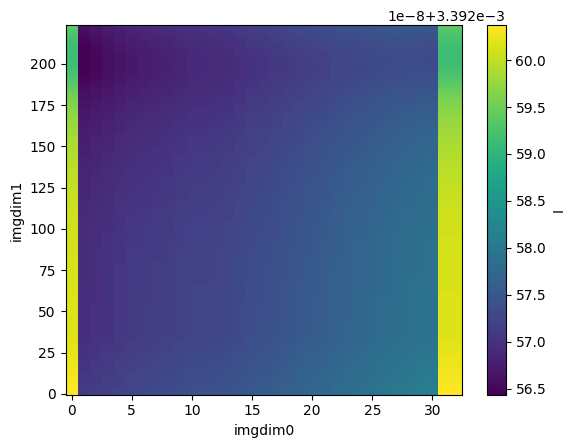

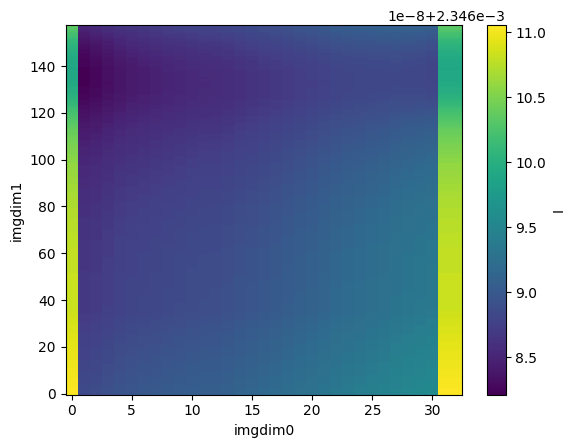

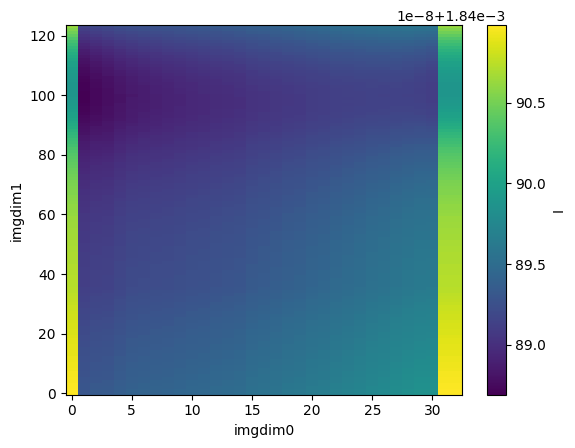

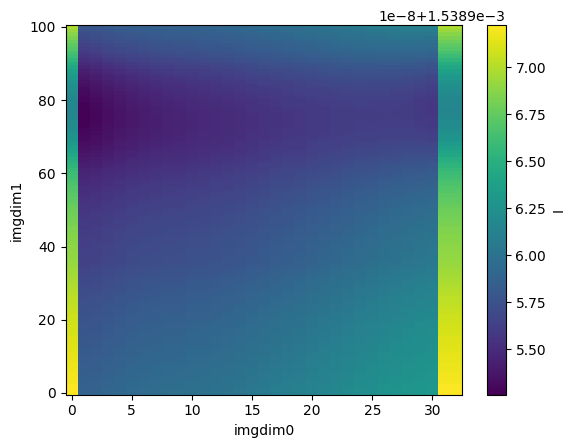

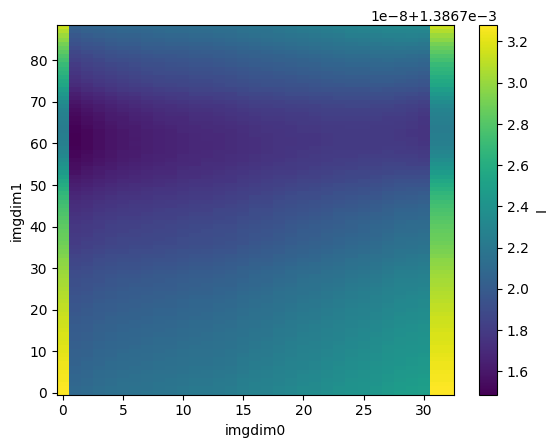

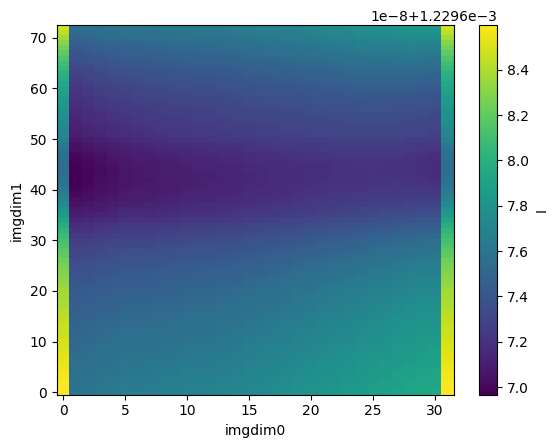

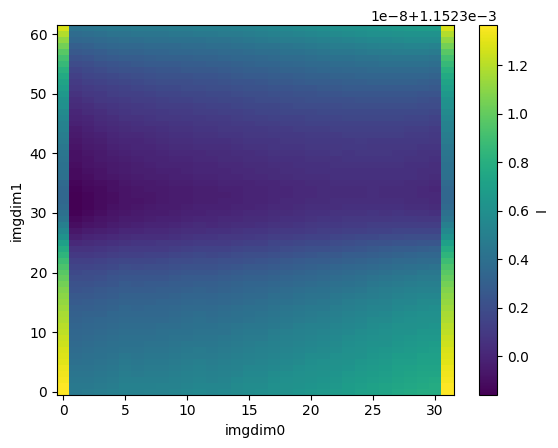

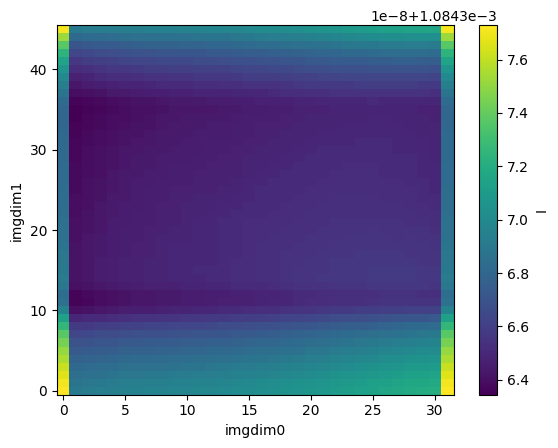

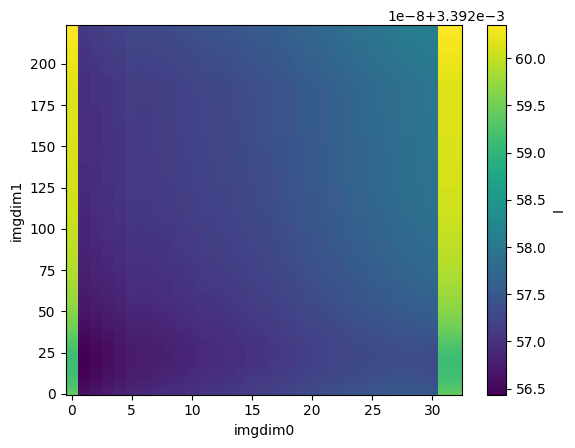

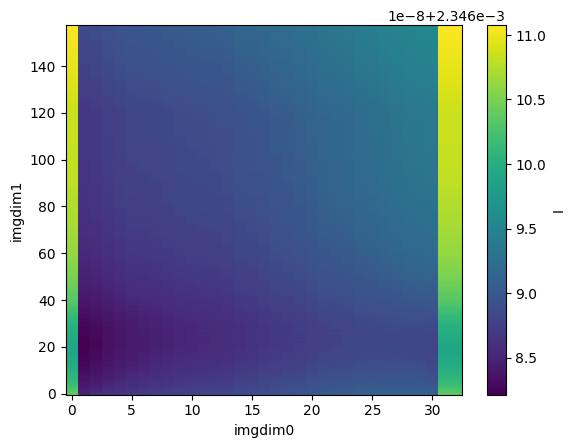

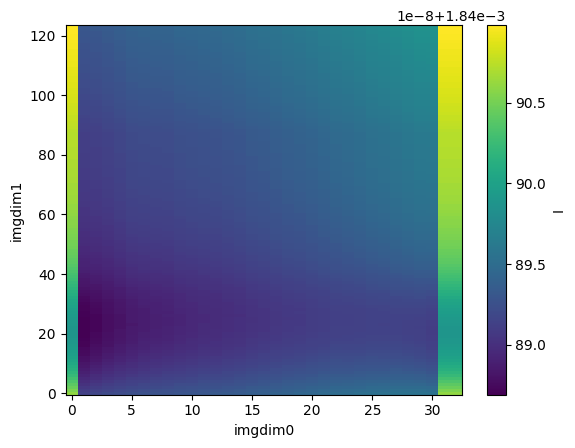

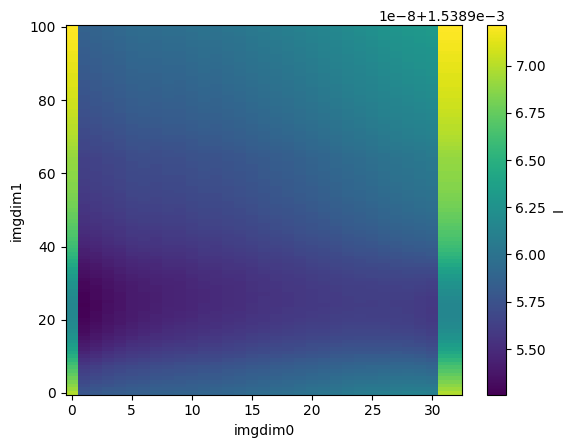

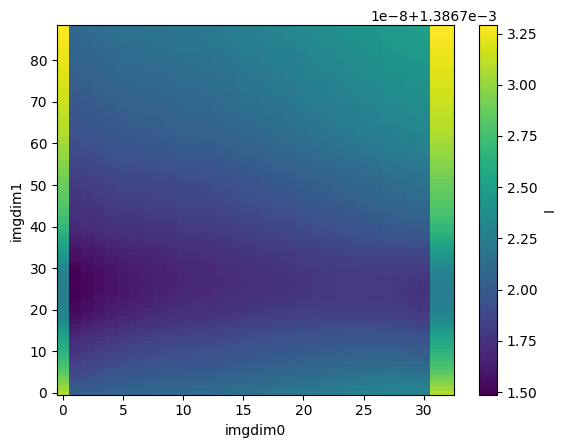

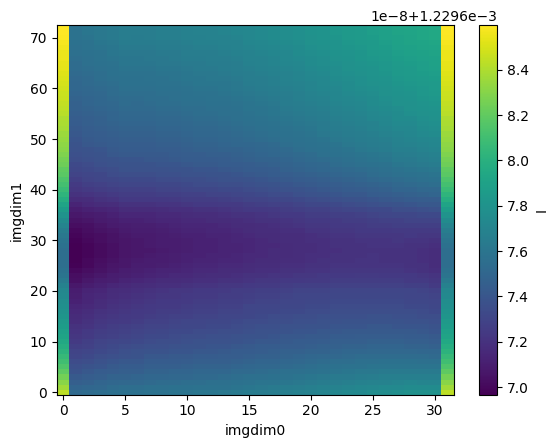

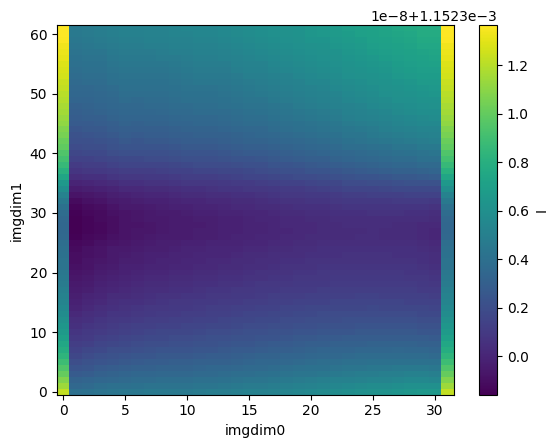

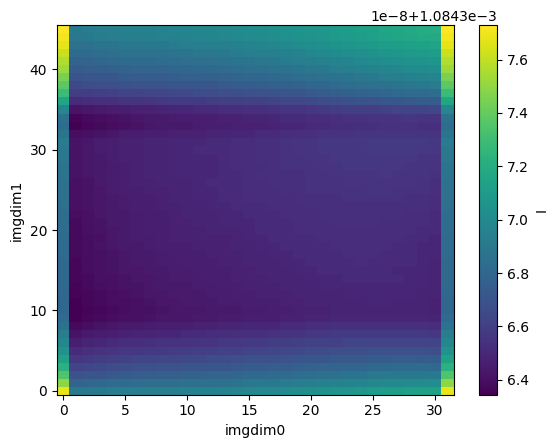

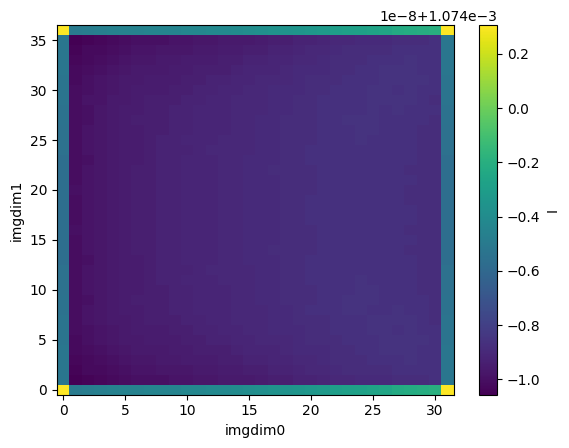

In [9]:
#visualize the initial state
state_gen(x0)
forward_sensors.get_measurements(solvers_reconstruct)

for instrument in forward_sensors:
    for im in forward_sensors.get_images(instrument):
        py.figure()
        im.I.T.plot()

In [10]:

objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
    sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
  state_gen.project_gradient_to_state,
    parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
  gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
  uncertainty_kwargs={'add_noise': False},
  min_bounds=min_bounds, max_bounds=max_bounds)

In [11]:
%matplotlib inline
def plot(xk, convergence=0):
    print(convergence)
    py.figure()
    py.plot(solvers_reconstruct[0.66].medium['cloud'].extinction.data.ravel(), 
            solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
    py.plot([0,130],[0,130])
    py.show()
    return False


In [12]:
from scipy.optimize import differential_evolution
bounds = [[min_bounds[i], max_bounds[i]] for i in range(len(max_bounds))]

# Define a custom initial population function
def generate_initial_population(bounds, popsize):
    dim = len(bounds)
    # Create a population where all initial candidates are at the lower bound
    initial_population = np.full((popsize, dim), [b[0] for b in bounds])
    
    # Optionally fill in the remaining population with random values within bounds
    # You can adjust this to fit specific needs
    for i in range(popsize-1):
        random_population = np.random.uniform(low=[b[0] for b in bounds], 
                                            high=[i+1 for b in bounds], 
                                            size=(1, dim))
        initial_population[i+1] = random_population
    
    return initial_population

def objective_fn_no_grad(state):
    return objective_function(state)[0]

# Generate custom initial population
popsize = 300
initial_population = generate_initial_population(bounds, popsize)

optimizer = differential_evolution(objective_fn_no_grad, bounds, callback=plot, strategy='best1bin', 
                                maxiter=5, 
                                popsize=popsize, 
                                tol=1e-6, 
                                disp=True,
                                init=initial_population,
                                polish = False)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.204  0.796E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -2.520  0.781E-01    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -4.223  0.549E-01    32007    79.04  0.309   [Radiance 0.660 micron]
     4  -4.126  0.282E-01    32100    79.38  0.310   [Radiance 0.660 micron]
 ! Iterations:      4     Final Criterion:  0.000075   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.986  0.153E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -2.022  0.145E+00    31968    78.82  0.308   [Radiance 0.660 micron]
    

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0196049213409424'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.621  0.540E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.115  0.658E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.321  0.715E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.468  0.604E+00    31978    78.88  0.308   [Radiance 0.660 micron]
     5  -1.786  0.394E+00    32053    79.18  0.309   [Radiance 0.660 micron]
     6  -1.963  0.232E+00    33347    85.16  0.333   [Radiance 0.660 micron]
     7  -1.915  0.147E+00    38849   105.70  0.413   [Radiance 0.660 micron]
     8  -2.151  0.123E+00    42838   117.99  0.461   [Radiance 0.660 micron]
     9  -2.184  0.885E-01    55079   144.63  0.565   [Radiance 0.660 micron]
    10  -2.299  0.726E-01    65752   160.20  0.626   [Radiance 0.660 micron]
    11  -2.391  0.586E-01    81407   175.11  0.684   [Radiance 0.660 micron]
    12  -2.452  0.479E-01   101719   188.17  0.735   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.0478763580322266'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.622  0.622E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.122  0.715E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.319  0.757E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.460  0.688E+00    31972    78.85  0.308   [Radiance 0.660 micron]
     5  -1.763  0.430E+00    32042    79.19  0.309   [Radiance 0.660 micron]
     6  -1.932  0.252E+00    33073    83.67  0.327   [Radiance 0.660 micron]
     7  -1.885  0.161E+00    37590   101.64  0.397   [Radiance 0.660 micron]
     8  -2.152  0.135E+00    41118   113.27  0.442   [Radiance 0.660 micron]
     9  -2.143  0.936E-01    53568   142.51  0.557   [Radiance 0.660 micron]
    10  -2.296  0.787E-01    62407   156.25  0.610   [Radiance 0.660 micron]
    11  -2.327  0.616E-01    79443   174.09  0.680   [Radiance 0.660 micron]
    12  -2.399  0.527E-01    94331   184.17  0.719   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.0174245834350586'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.622  0.594E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.125  0.671E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.322  0.703E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.459  0.633E+00    31976    78.87  0.308   [Radiance 0.660 micron]
     5  -1.752  0.411E+00    32061    79.23  0.309   [Radiance 0.660 micron]
     6  -1.917  0.244E+00    33323    84.87  0.332   [Radiance 0.660 micron]
     7  -1.853  0.159E+00    38562   105.33  0.411   [Radiance 0.660 micron]
     8  -2.132  0.137E+00    41983   116.08  0.453   [Radiance 0.660 micron]
     9  -2.140  0.954E-01    54244   143.47  0.560   [Radiance 0.660 micron]
    10  -2.272  0.791E-01    63847   157.76  0.616   [Radiance 0.660 micron]
    11  -2.370  0.629E-01    80144   174.33  0.681   [Radiance 0.660 micron]
    12  -2.353  0.508E-01   102259   188.53  0.736   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.0634565353393555'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.623  0.534E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.130  0.656E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.323  0.713E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.458  0.611E+00    31984    78.91  0.308   [Radiance 0.660 micron]
     5  -1.733  0.403E+00    32063    79.24  0.310   [Radiance 0.660 micron]
     6  -1.908  0.245E+00    33328    84.99  0.332   [Radiance 0.660 micron]
     7  -1.880  0.160E+00    38639   105.26  0.411   [Radiance 0.660 micron]
     8  -2.106  0.133E+00    42822   118.11  0.461   [Radiance 0.660 micron]
     9  -2.154  0.962E-01    54088   142.89  0.558   [Radiance 0.660 micron]
    10  -2.261  0.781E-01    64959   159.15  0.622   [Radiance 0.660 micron]
    11  -2.367  0.631E-01    80860   174.82  0.683   [Radiance 0.660 micron]
    12  -2.360  0.509E-01   102879   188.48  0.736   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0276191234588623'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.622  0.495E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.128  0.601E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.321  0.651E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.455  0.555E+00    31974    78.86  0.308   [Radiance 0.660 micron]
     5  -1.736  0.371E+00    32085    79.35  0.310   [Radiance 0.660 micron]
     6  -1.888  0.231E+00    33776    86.97  0.340   [Radiance 0.660 micron]
     7  -1.872  0.155E+00    39231   107.31  0.419   [Radiance 0.660 micron]
     8  -2.082  0.130E+00    43764   120.79  0.472   [Radiance 0.660 micron]
     9  -2.170  0.962E-01    54680   144.46  0.564   [Radiance 0.660 micron]
    10  -2.265  0.761E-01    66790   161.63  0.631   [Radiance 0.660 micron]
    11  -2.320  0.616E-01    83087   176.39  0.689   [Radiance 0.660 micron]
    12  -2.427  0.525E-01   100580   187.59  0.733   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '5'. Max cell optical depth: '2.3154780864715576'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.622  0.545E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.132  0.681E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.320  0.733E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.451  0.650E+00    31982    78.90  0.308   [Radiance 0.660 micron]
     5  -1.715  0.417E+00    32058    79.23  0.309   [Radiance 0.660 micron]
     6  -1.893  0.257E+00    33029    83.72  0.327   [Radiance 0.660 micron]
     7  -1.890  0.167E+00    37772   102.46  0.400   [Radiance 0.660 micron]
     8  -2.080  0.136E+00    42114   116.34  0.454   [Radiance 0.660 micron]
     9  -2.161  0.100E+00    52440   140.42  0.549   [Radiance 0.660 micron]
    10  -2.247  0.795E-01    64264   158.56  0.619   [Radiance 0.660 micron]
    11  -2.323  0.648E-01    78367   172.46  0.674   [Radiance 0.660 micron]
    12  -2.383  0.541E-01    95992   184.60  0.721   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3'. Max cell optical depth: '2.1448161602020264'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.618  0.606E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.131  0.711E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.323  0.758E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.455  0.642E+00    31974    78.86  0.308   [Radiance 0.660 micron]
     5  -1.727  0.424E+00    32029    79.10  0.309   [Radiance 0.660 micron]
     6  -1.892  0.261E+00    32989    83.51  0.326   [Radiance 0.660 micron]
     7  -1.833  0.170E+00    37549   101.55  0.397   [Radiance 0.660 micron]
     8  -2.126  0.146E+00    40461   111.34  0.435   [Radiance 0.660 micron]
     9  -2.115  0.100E+00    52992   141.61  0.553   [Radiance 0.660 micron]
    10  -2.252  0.837E-01    61702   155.23  0.606   [Radiance 0.660 micron]
    11  -2.310  0.664E-01    77644   171.64  0.670   [Radiance 0.660 micron]
    12  -2.361  0.557E-01    94883   184.06  0.719   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.1493899822235107'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.620  0.632E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.135  0.713E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.326  0.747E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.459  0.620E+00    31974    78.86  0.308   [Radiance 0.660 micron]
     5  -1.734  0.429E+00    32043    79.20  0.309   [Radiance 0.660 micron]
     6  -1.894  0.258E+00    33099    83.95  0.328   [Radiance 0.660 micron]
     7  -1.856  0.169E+00    37845   102.58  0.401   [Radiance 0.660 micron]
     8  -2.096  0.143E+00    41385   114.44  0.447   [Radiance 0.660 micron]
     9  -2.134  0.102E+00    52513   140.41  0.548   [Radiance 0.660 micron]
    10  -2.228  0.828E-01    62966   156.45  0.611   [Radiance 0.660 micron]
    11  -2.317  0.677E-01    76971   171.36  0.669   [Radiance 0.660 micron]
    12  -2.265  0.558E-01    95665   184.83  0.722   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.0212419033050537'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.619  0.566E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.136  0.691E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.323  0.752E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.453  0.644E+00    31976    78.87  0.308   [Radiance 0.660 micron]
     5  -1.722  0.421E+00    32063    79.27  0.310   [Radiance 0.660 micron]
     6  -1.881  0.257E+00    33313    84.71  0.331   [Radiance 0.660 micron]
     7  -1.837  0.170E+00    38192   103.90  0.406   [Radiance 0.660 micron]
     8  -2.099  0.145E+00    41669   115.02  0.449   [Radiance 0.660 micron]
     9  -2.119  0.102E+00    53244   141.40  0.552   [Radiance 0.660 micron]
    10  -2.238  0.838E-01    63421   156.94  0.613   [Radiance 0.660 micron]
    11  -2.307  0.673E-01    79000   172.90  0.675   [Radiance 0.660 micron]
    12  -2.274  0.561E-01    96488   184.88  0.722   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.1583328247070312'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.618  0.554E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.136  0.644E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.326  0.696E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.457  0.597E+00    31982    78.90  0.308   [Radiance 0.660 micron]
     5  -1.714  0.393E+00    32082    79.18  0.309   [Radiance 0.660 micron]
     6  -1.884  0.246E+00    33536    85.76  0.335   [Radiance 0.660 micron]
     7  -1.850  0.164E+00    38871   106.06  0.414   [Radiance 0.660 micron]
     8  -2.095  0.138E+00    42794   118.32  0.462   [Radiance 0.660 micron]
     9  -2.145  0.990E-01    54321   143.86  0.562   [Radiance 0.660 micron]
    10  -2.235  0.797E-01    66180   160.75  0.628   [Radiance 0.660 micron]
    11  -2.325  0.654E-01    81360   175.02  0.684   [Radiance 0.660 micron]
    12  -2.275  0.540E-01   101005   187.66  0.733   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.1188416481018066'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.621  0.510E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.141  0.623E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.326  0.675E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.454  0.577E+00    31990    78.95  0.308   [Radiance 0.660 micron]
     5  -1.694  0.385E+00    32088    79.33  0.310   [Radiance 0.660 micron]
     6  -1.866  0.246E+00    33591    86.25  0.337   [Radiance 0.660 micron]
     7  -1.862  0.165E+00    38573   105.38  0.412   [Radiance 0.660 micron]
     8  -2.066  0.136E+00    43202   119.80  0.468   [Radiance 0.660 micron]
     9  -2.122  0.101E+00    54583   144.46  0.564   [Radiance 0.660 micron]
    10  -2.238  0.820E-01    65192   159.42  0.623   [Radiance 0.660 micron]
    11  -2.279  0.659E-01    81211   174.73  0.683   [Radiance 0.660 micron]
    12  -2.291  0.567E-01    96616   185.08  0.723   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '4'. Max cell optical depth: '2.2350106239318848'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.620  0.560E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.138  0.677E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.322  0.733E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.450  0.643E+00    31980    78.89  0.308   [Radiance 0.660 micron]
     5  -1.710  0.412E+00    32061    79.25  0.310   [Radiance 0.660 micron]
     6  -1.875  0.257E+00    33277    84.75  0.331   [Radiance 0.660 micron]
     7  -1.836  0.170E+00    38511   105.19  0.411   [Radiance 0.660 micron]
     8  -2.083  0.144E+00    42176   116.80  0.456   [Radiance 0.660 micron]
     9  -2.117  0.103E+00    53852   142.93  0.558   [Radiance 0.660 micron]
    10  -2.230  0.842E-01    64021   158.20  0.618   [Radiance 0.660 micron]
    11  -2.274  0.678E-01    79316   173.41  0.677   [Radiance 0.660 micron]
    12  -2.384  0.582E-01    94490   183.81  0.718   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.2754948139190674'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.621  0.603E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.142  0.706E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.327  0.755E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.454  0.640E+00    31974    78.86  0.308   [Radiance 0.660 micron]
     5  -1.709  0.427E+00    32029    79.13  0.309   [Radiance 0.660 micron]
     6  -1.871  0.264E+00    33094    83.87  0.328   [Radiance 0.660 micron]
     7  -1.806  0.175E+00    37616   101.99  0.398   [Radiance 0.660 micron]
     8  -2.079  0.152E+00    40534   111.46  0.435   [Radiance 0.660 micron]
     9  -2.100  0.107E+00    51548   138.50  0.541   [Radiance 0.660 micron]
    10  -2.231  0.879E-01    60919   153.94  0.601   [Radiance 0.660 micron]
    11  -2.256  0.695E-01    76244   170.79  0.667   [Radiance 0.660 micron]
    12  -2.347  0.602E-01    89589   180.51  0.705   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.196455717086792'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.619  0.522E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.142  0.651E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.327  0.713E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.453  0.604E+00    31988    78.93  0.308   [Radiance 0.660 micron]
     5  -1.684  0.401E+00    32079    79.29  0.310   [Radiance 0.660 micron]
     6  -1.860  0.256E+00    33592    85.90  0.336   [Radiance 0.660 micron]
     7  -1.844  0.171E+00    38630   105.06  0.410   [Radiance 0.660 micron]
     8  -2.074  0.142E+00    42701   117.58  0.459   [Radiance 0.660 micron]
     9  -2.125  0.103E+00    54087   142.75  0.558   [Radiance 0.660 micron]
    10  -2.229  0.831E-01    65160   158.76  0.620   [Radiance 0.660 micron]
    11  -2.301  0.672E-01    81455   174.59  0.682   [Radiance 0.660 micron]
    12  -2.401  0.562E-01   100486   187.08  0.731   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.0423173904418945'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.619  0.503E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.143  0.614E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.326  0.662E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.451  0.577E+00    31978    78.88  0.308   [Radiance 0.660 micron]
     5  -1.701  0.382E+00    32126    79.45  0.310   [Radiance 0.660 micron]
     6  -1.854  0.242E+00    33873    87.37  0.341   [Radiance 0.660 micron]
     7  -1.818  0.165E+00    39456   108.15  0.422   [Radiance 0.660 micron]
     8  -2.082  0.142E+00    43106   119.32  0.466   [Radiance 0.660 micron]
     9  -2.135  0.101E+00    55004   144.84  0.566   [Radiance 0.660 micron]
    10  -2.212  0.808E-01    67221   161.60  0.631   [Radiance 0.660 micron]
    11  -2.298  0.669E-01    81981   175.35  0.685   [Radiance 0.660 micron]
    12  -2.355  0.560E-01   100712   187.20  0.731   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6'. Max cell optical depth: '2.3451809883117676'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.619  0.553E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.145  0.641E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.328  0.681E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.452  0.591E+00    31974    78.86  0.308   [Radiance 0.660 micron]
     5  -1.702  0.388E+00    32096    79.39  0.310   [Radiance 0.660 micron]
     6  -1.853  0.249E+00    33681    86.65  0.338   [Radiance 0.660 micron]
     7  -1.822  0.169E+00    38676   105.52  0.412   [Radiance 0.660 micron]
     8  -2.079  0.144E+00    42666   117.96  0.461   [Radiance 0.660 micron]
     9  -2.110  0.103E+00    54519   144.02  0.563   [Radiance 0.660 micron]
    10  -2.230  0.841E-01    65154   159.36  0.623   [Radiance 0.660 micron]
    11  -2.307  0.674E-01    81674   174.92  0.683   [Radiance 0.660 micron]
    12  -2.374  0.559E-01   101191   187.56  0.733   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6'. Max cell optical depth: '2.1593072414398193'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.619  0.571E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.149  0.687E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.331  0.740E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.455  0.595E+00    31974    78.86  0.308   [Radiance 0.660 micron]
     5  -1.697  0.416E+00    32036    79.14  0.309   [Radiance 0.660 micron]
     6  -1.855  0.262E+00    33466    85.51  0.334   [Radiance 0.660 micron]
     7  -1.745  0.176E+00    38205   103.76  0.405   [Radiance 0.660 micron]
     8  -2.109  0.162E+00    39995   109.83  0.429   [Radiance 0.660 micron]
     9  -2.072  0.107E+00    53510   142.62  0.557   [Radiance 0.660 micron]
    10  -2.198  0.899E-01    61852   155.49  0.607   [Radiance 0.660 micron]
    11  -2.254  0.725E-01    76753   171.08  0.668   [Radiance 0.660 micron]
    12  -2.296  0.615E-01    92721   182.63  0.713   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '9'. Max cell optical depth: '2.3132145404815674'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.619  0.525E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.149  0.659E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.329  0.718E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.451  0.610E+00    31984    78.91  0.308   [Radiance 0.660 micron]
     5  -1.681  0.402E+00    32122    79.38  0.310   [Radiance 0.660 micron]
     6  -1.852  0.259E+00    33566    86.17  0.337   [Radiance 0.660 micron]
     7  -1.846  0.174E+00    38781   105.79  0.413   [Radiance 0.660 micron]
     8  -2.055  0.144E+00    43109   119.21  0.466   [Radiance 0.660 micron]
     9  -2.084  0.105E+00    53513   142.03  0.555   [Radiance 0.660 micron]
    10  -2.197  0.878E-01    63198   156.72  0.612   [Radiance 0.660 micron]
    11  -2.299  0.714E-01    77769   171.70  0.671   [Radiance 0.660 micron]
    12  -2.313  0.581E-01    98650   185.98  0.726   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '4'. Max cell optical depth: '2.5973591804504395'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.623  0.607E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.152  0.699E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.334  0.742E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.457  0.616E+00    31978    78.88  0.308   [Radiance 0.660 micron]
     5  -1.696  0.419E+00    32064    79.14  0.309   [Radiance 0.660 micron]
     6  -1.854  0.264E+00    33370    85.21  0.333   [Radiance 0.660 micron]
     7  -1.787  0.178E+00    38164   103.76  0.405   [Radiance 0.660 micron]
     8  -2.083  0.156E+00    40801   112.33  0.439   [Radiance 0.660 micron]
     9  -2.087  0.108E+00    53610   143.08  0.559   [Radiance 0.660 micron]
    10  -2.201  0.892E-01    63416   157.80  0.616   [Radiance 0.660 micron]
    11  -2.285  0.721E-01    78192   172.62  0.674   [Radiance 0.660 micron]
    12  -2.260  0.595E-01    96238   184.97  0.723   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '10'. Max cell optical depth: '2.3967888355255127'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.621  0.611E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.154  0.705E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.334  0.740E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.455  0.607E+00    31976    78.87  0.308   [Radiance 0.660 micron]
     5  -1.693  0.422E+00    32049    79.20  0.309   [Radiance 0.660 micron]
     6  -1.851  0.267E+00    33341    85.26  0.333   [Radiance 0.660 micron]
     7  -1.807  0.180E+00    38020   103.65  0.405   [Radiance 0.660 micron]
     8  -2.064  0.154E+00    41361   114.58  0.448   [Radiance 0.660 micron]
     9  -2.072  0.109E+00    52882   141.61  0.553   [Radiance 0.660 micron]
    10  -2.192  0.914E-01    62126   156.12  0.610   [Radiance 0.660 micron]
    11  -2.243  0.738E-01    76428   170.92  0.668   [Radiance 0.660 micron]
    12  -2.361  0.629E-01    91285   182.01  0.711   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.5947329998016357'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.621  0.580E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.155  0.688E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.331  0.738E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.451  0.641E+00    31976    78.87  0.308   [Radiance 0.660 micron]
     5  -1.683  0.417E+00    32082    79.28  0.310   [Radiance 0.660 micron]
     6  -1.838  0.266E+00    33508    85.79  0.335   [Radiance 0.660 micron]
     7  -1.801  0.181E+00    38431   104.46  0.408   [Radiance 0.660 micron]
     8  -2.068  0.155E+00    41465   114.45  0.447   [Radiance 0.660 micron]
     9  -2.089  0.109E+00    52938   141.02  0.551   [Radiance 0.660 micron]
    10  -2.186  0.893E-01    63060   156.55  0.612   [Radiance 0.660 micron]
    11  -2.287  0.732E-01    77273   171.27  0.669   [Radiance 0.660 micron]
    12  -2.317  0.597E-01    97353   185.52  0.725   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6'. Max cell optical depth: '2.2510125637054443'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.620  0.476E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.157  0.596E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.335  0.651E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.456  0.523E+00    31990    78.95  0.308   [Radiance 0.660 micron]
     5  -1.668  0.368E+00    32199    79.88  0.312   [Radiance 0.660 micron]
     6  -1.824  0.243E+00    34284    88.97  0.348   [Radiance 0.660 micron]
     7  -1.850  0.170E+00    39613   108.83  0.425   [Radiance 0.660 micron]
     8  -2.023  0.138E+00    44808   123.67  0.483   [Radiance 0.660 micron]
     9  -2.117  0.105E+00    54615   144.11  0.563   [Radiance 0.660 micron]
    10  -2.190  0.836E-01    67145   161.54  0.631   [Radiance 0.660 micron]
    11  -2.277  0.694E-01    82626   175.79  0.687   [Radiance 0.660 micron]
    12  -2.315  0.581E-01   101116   187.56  0.733   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '10'. Max cell optical depth: '2.3978588581085205'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.621  0.549E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.155  0.667E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.333  0.720E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.454  0.611E+00    31984    78.91  0.308   [Radiance 0.660 micron]
     5  -1.673  0.406E+00    32133    79.47  0.310   [Radiance 0.660 micron]
     6  -1.832  0.262E+00    33574    86.07  0.336   [Radiance 0.660 micron]
     7  -1.837  0.179E+00    38576   104.97  0.410   [Radiance 0.660 micron]
     8  -2.035  0.147E+00    42939   118.58  0.463   [Radiance 0.660 micron]
     9  -2.103  0.109E+00    53918   142.99  0.559   [Radiance 0.660 micron]
    10  -2.164  0.878E-01    65529   159.91  0.625   [Radiance 0.660 micron]
    11  -2.292  0.739E-01    77578   171.57  0.670   [Radiance 0.660 micron]
    12  -2.306  0.596E-01    98339   185.87  0.726   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3'. Max cell optical depth: '2.2573070526123047'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.621  0.596E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.159  0.666E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.336  0.724E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.454  0.603E+00    31984    78.91  0.308   [Radiance 0.660 micron]
     5  -1.662  0.401E+00    32130    79.38  0.310   [Radiance 0.660 micron]
     6  -1.826  0.265E+00    33596    86.11  0.336   [Radiance 0.660 micron]
     7  -1.829  0.181E+00    38400   104.60  0.409   [Radiance 0.660 micron]
     8  -2.037  0.149E+00    42709   118.20  0.462   [Radiance 0.660 micron]
     9  -2.088  0.110E+00    53367   142.25  0.556   [Radiance 0.660 micron]
    10  -2.186  0.893E-01    64679   158.67  0.620   [Radiance 0.660 micron]
    11  -2.270  0.730E-01    79875   173.65  0.678   [Radiance 0.660 micron]
    12  -2.289  0.605E-01    98672   186.35  0.728   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6'. Max cell optical depth: '2.363517999649048'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.618  0.551E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.157  0.645E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.334  0.694E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.453  0.588E+00    31982    78.90  0.308   [Radiance 0.660 micron]
     5  -1.677  0.395E+00    32091    79.38  0.310   [Radiance 0.660 micron]
     6  -1.833  0.255E+00    33707    86.85  0.339   [Radiance 0.660 micron]
     7  -1.808  0.175E+00    39053   107.06  0.418   [Radiance 0.660 micron]
     8  -2.055  0.149E+00    43009   119.08  0.465   [Radiance 0.660 micron]
     9  -2.093  0.107E+00    54580   144.24  0.563   [Radiance 0.660 micron]
    10  -2.189  0.875E-01    65275   159.26  0.622   [Radiance 0.660 micron]
    11  -2.268  0.717E-01    79991   173.53  0.678   [Radiance 0.660 micron]
    12  -2.329  0.600E-01    98264   185.77  0.726   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '12'. Max cell optical depth: '2.512471914291382'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.619  0.556E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.161  0.655E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.338  0.704E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.456  0.604E+00    31980    78.89  0.308   [Radiance 0.660 micron]
     5  -1.665  0.398E+00    32160    79.60  0.311   [Radiance 0.660 micron]
     6  -1.825  0.260E+00    33804    87.34  0.341   [Radiance 0.660 micron]
     7  -1.822  0.179E+00    38826   106.05  0.414   [Radiance 0.660 micron]
     8  -2.024  0.149E+00    42990   119.04  0.465   [Radiance 0.660 micron]
     9  -2.085  0.111E+00    53501   142.03  0.555   [Radiance 0.660 micron]
    10  -2.165  0.899E-01    64890   158.84  0.620   [Radiance 0.660 micron]
    11  -2.271  0.746E-01    78511   172.35  0.673   [Radiance 0.660 micron]
    12  -2.286  0.610E-01    97603   185.64  0.725   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.420414447784424'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.618  0.566E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.162  0.672E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.337  0.718E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.454  0.605E+00    31984    78.91  0.308   [Radiance 0.660 micron]
     5  -1.669  0.407E+00    32090    79.36  0.310   [Radiance 0.660 micron]
     6  -1.822  0.264E+00    33531    85.77  0.335   [Radiance 0.660 micron]
     7  -1.793  0.182E+00    38539   105.10  0.411   [Radiance 0.660 micron]
     8  -2.030  0.156E+00    42449   117.47  0.459   [Radiance 0.660 micron]
     9  -2.074  0.113E+00    53108   141.72  0.554   [Radiance 0.660 micron]
    10  -2.173  0.921E-01    63678   157.57  0.615   [Radiance 0.660 micron]
    11  -2.210  0.751E-01    77870   171.73  0.671   [Radiance 0.660 micron]
    12  -2.318  0.653E-01    91389   181.70  0.710   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '5'. Max cell optical depth: '2.548368453979492'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.620  0.490E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.161  0.617E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.333  0.681E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.449  0.577E+00    31984    78.91  0.308   [Radiance 0.660 micron]
     5  -1.653  0.382E+00    32225    79.99  0.312   [Radiance 0.660 micron]
     6  -1.811  0.254E+00    33989    88.05  0.344   [Radiance 0.660 micron]
     7  -1.848  0.177E+00    39266   107.60  0.420   [Radiance 0.660 micron]
     8  -2.012  0.142E+00    44853   124.07  0.485   [Radiance 0.660 micron]
     9  -2.098  0.109E+00    54887   144.60  0.565   [Radiance 0.660 micron]
    10  -2.142  0.870E-01    67164   161.44  0.631   [Radiance 0.660 micron]
    11  -2.275  0.746E-01    79360   172.97  0.676   [Radiance 0.660 micron]
    12  -2.281  0.605E-01   100637   187.32  0.732   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6'. Max cell optical depth: '2.242039442062378'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.620  0.528E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.165  0.644E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.336  0.698E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.451  0.597E+00    31984    78.91  0.308   [Radiance 0.660 micron]
     5  -1.650  0.394E+00    32190    79.69  0.311   [Radiance 0.660 micron]
     6  -1.816  0.262E+00    33867    87.41  0.341   [Radiance 0.660 micron]
     7  -1.855  0.181E+00    39284   107.63  0.420   [Radiance 0.660 micron]
     8  -1.992  0.144E+00    44760   123.91  0.484   [Radiance 0.660 micron]
     9  -2.104  0.112E+00    53867   142.81  0.558   [Radiance 0.660 micron]
    10  -2.170  0.884E-01    66475   160.63  0.627   [Radiance 0.660 micron]
    11  -2.184  0.735E-01    81483   174.50  0.682   [Radiance 0.660 micron]
    12  -2.277  0.660E-01    92581   182.24  0.712   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '11'. Max cell optical depth: '2.6376888751983643'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.620  0.502E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.165  0.635E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.338  0.710E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.453  0.574E+00    31988    78.93  0.308   [Radiance 0.660 micron]
     5  -1.652  0.386E+00    32195    79.81  0.312   [Radiance 0.660 micron]
     6  -1.815  0.258E+00    33759    87.04  0.340   [Radiance 0.660 micron]
     7  -1.854  0.179E+00    39022   106.86  0.417   [Radiance 0.660 micron]
     8  -2.012  0.143E+00    44708   123.61  0.483   [Radiance 0.660 micron]
     9  -2.098  0.109E+00    54849   144.76  0.565   [Radiance 0.660 micron]
    10  -2.169  0.877E-01    66980   161.68  0.632   [Radiance 0.660 micron]
    11  -2.255  0.731E-01    81007   174.84  0.683   [Radiance 0.660 micron]
    12  -2.325  0.613E-01    99091   186.63  0.729   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '21'. Max cell optical depth: '2.824572801589966'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.619  0.480E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.167  0.598E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.337  0.653E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.451  0.551E+00    31982    78.90  0.308   [Radiance 0.660 micron]
     5  -1.654  0.369E+00    32246    80.16  0.313   [Radiance 0.660 micron]
     6  -1.802  0.247E+00    34334    89.44  0.349   [Radiance 0.660 micron]
     7  -1.835  0.175E+00    39751   109.25  0.427   [Radiance 0.660 micron]
     8  -2.018  0.142E+00    45488   125.56  0.490   [Radiance 0.660 micron]
     9  -2.092  0.107E+00    56339   147.26  0.575   [Radiance 0.660 micron]
    10  -2.166  0.866E-01    68967   164.10  0.641   [Radiance 0.660 micron]
    11  -2.226  0.724E-01    83850   176.91  0.691   [Radiance 0.660 micron]
    12  -2.329  0.624E-01    99330   186.63  0.729   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '10'. Max cell optical depth: '2.4285807609558105'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.620  0.612E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.167  0.702E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.340  0.742E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.454  0.581E+00    31976    78.87  0.308   [Radiance 0.660 micron]
     5  -1.663  0.421E+00    32089    79.38  0.310   [Radiance 0.660 micron]
     6  -1.808  0.273E+00    33429    85.73  0.335   [Radiance 0.660 micron]
     7  -1.795  0.190E+00    37983   103.57  0.405   [Radiance 0.660 micron]
     8  -2.004  0.160E+00    41709   115.60  0.452   [Radiance 0.660 micron]
     9  -2.072  0.119E+00    51564   138.78  0.542   [Radiance 0.660 micron]
    10  -2.158  0.952E-01    62919   156.48  0.611   [Radiance 0.660 micron]
    11  -2.250  0.779E-01    76847   170.70  0.667   [Radiance 0.660 micron]
    12  -2.286  0.641E-01    95919   184.46  0.721   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '18'. Max cell optical depth: '3.0182526111602783'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.618  0.534E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.170  0.657E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.341  0.720E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.454  0.576E+00    31984    78.91  0.308   [Radiance 0.660 micron]
     5  -1.635  0.396E+00    32178    79.73  0.311   [Radiance 0.660 micron]
     6  -1.801  0.269E+00    33792    87.10  0.340   [Radiance 0.660 micron]
     7  -1.844  0.187E+00    38644   105.30  0.411   [Radiance 0.660 micron]
     8  -1.992  0.149E+00    43951   121.21  0.473   [Radiance 0.660 micron]
     9  -2.083  0.114E+00    53554   142.09  0.555   [Radiance 0.660 micron]
    10  -2.136  0.916E-01    65393   158.98  0.621   [Radiance 0.660 micron]
    11  -2.250  0.776E-01    77591   171.32  0.669   [Radiance 0.660 micron]
    12  -2.294  0.636E-01    97661   185.71  0.725   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '16'. Max cell optical depth: '2.8474817276000977'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.618  0.475E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.170  0.605E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.344  0.668E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.459  0.536E+00    31986    78.92  0.308   [Radiance 0.660 micron]
     5  -1.651  0.368E+00    32239    80.08  0.313   [Radiance 0.660 micron]
     6  -1.801  0.249E+00    34243    89.25  0.349   [Radiance 0.660 micron]
     7  -1.832  0.176E+00    39780   109.36  0.427   [Radiance 0.660 micron]
     8  -2.014  0.144E+00    45435   125.86  0.492   [Radiance 0.660 micron]
     9  -2.081  0.108E+00    56560   147.75  0.577   [Radiance 0.660 micron]
    10  -2.167  0.882E-01    68378   162.82  0.636   [Radiance 0.660 micron]
    11  -2.256  0.731E-01    83679   176.63  0.690   [Radiance 0.660 micron]
    12  -2.265  0.609E-01   103401   189.09  0.739   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '25'. Max cell optical depth: '2.6405029296875'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.620  0.560E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.174  0.664E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.344  0.720E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.457  0.601E+00    31986    78.92  0.308   [Radiance 0.660 micron]
     5  -1.648  0.393E+00    32144    79.64  0.311   [Radiance 0.660 micron]
     6  -1.811  0.266E+00    33660    86.86  0.339   [Radiance 0.660 micron]
     7  -1.818  0.184E+00    38877   106.59  0.416   [Radiance 0.660 micron]
     8  -2.016  0.152E+00    43201   119.86  0.468   [Radiance 0.660 micron]
     9  -2.059  0.113E+00    54296   143.77  0.562   [Radiance 0.660 micron]
    10  -2.160  0.934E-01    64760   158.76  0.620   [Radiance 0.660 micron]
    11  -2.258  0.766E-01    78880   172.46  0.674   [Radiance 0.660 micron]
    12  -2.259  0.628E-01    99022   186.30  0.728   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '10'. Max cell optical depth: '3.009493827819824'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.618  0.445E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.172  0.532E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.340  0.584E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.452  0.493E+00    31988    78.93  0.308   [Radiance 0.660 micron]
     5  -1.629  0.334E+00    32673    81.92  0.320   [Radiance 0.660 micron]
     6  -1.767  0.233E+00    35398    93.56  0.365   [Radiance 0.660 micron]
     7  -1.870  0.171E+00    40731   111.93  0.437   [Radiance 0.660 micron]
     8  -1.984  0.132E+00    48147   131.04  0.512   [Radiance 0.660 micron]
     9  -2.094  0.105E+00    58407   149.88  0.585   [Radiance 0.660 micron]
    10  -2.142  0.840E-01    72647   166.78  0.651   [Radiance 0.660 micron]
    11  -2.246  0.719E-01    86255   178.05  0.696   [Radiance 0.660 micron]
    12  -2.289  0.603E-01   105526   189.64  0.741   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '21'. Max cell optical depth: '2.748549699783325'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.618  0.511E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.173  0.632E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.343  0.697E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.456  0.502E+00    31990    78.95  0.308   [Radiance 0.660 micron]
     5  -1.628  0.383E+00    32229    79.94  0.312   [Radiance 0.660 micron]
     6  -1.793  0.263E+00    34063    88.50  0.346   [Radiance 0.660 micron]
     7  -1.837  0.184E+00    38871   106.29  0.415   [Radiance 0.660 micron]
     8  -1.991  0.148E+00    44394   122.85  0.480   [Radiance 0.660 micron]
     9  -2.062  0.113E+00    54155   143.17  0.559   [Radiance 0.660 micron]
    10  -2.119  0.925E-01    65345   159.05  0.621   [Radiance 0.660 micron]
    11  -2.211  0.790E-01    77534   171.17  0.669   [Radiance 0.660 micron]
    12  -2.290  0.665E-01    94234   183.24  0.716   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8'. Max cell optical depth: '2.5040557384490967'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.618  0.488E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.172  0.616E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.342  0.682E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.455  0.538E+00    31996    78.98  0.309   [Radiance 0.660 micron]
     5  -1.628  0.375E+00    32241    80.01  0.313   [Radiance 0.660 micron]
     6  -1.792  0.258E+00    34370    89.23  0.349   [Radiance 0.660 micron]
     7  -1.834  0.182E+00    40043   109.93  0.429   [Radiance 0.660 micron]
     8  -1.981  0.146E+00    45462   125.10  0.489   [Radiance 0.660 micron]
     9  -2.091  0.113E+00    55245   145.08  0.567   [Radiance 0.660 micron]
    10  -2.140  0.896E-01    68640   162.74  0.636   [Radiance 0.660 micron]
    11  -2.226  0.758E-01    82332   175.00  0.684   [Radiance 0.660 micron]
    12  -2.265  0.640E-01   100751   187.06  0.731   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '20'. Max cell optical depth: '2.800977945327759'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.619  0.465E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.178  0.553E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.347  0.625E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.458  0.506E+00    31990    78.95  0.308   [Radiance 0.660 micron]
     5  -1.646  0.341E+00    32532    81.57  0.319   [Radiance 0.660 micron]
     6  -1.771  0.234E+00    35408    93.69  0.366   [Radiance 0.660 micron]
     7  -1.862  0.172E+00    40748   112.47  0.439   [Radiance 0.660 micron]
     8  -1.984  0.135E+00    48005   131.25  0.513   [Radiance 0.660 micron]
     9  -2.085  0.107E+00    58236   150.24  0.587   [Radiance 0.660 micron]
    10  -2.147  0.860E-01    71482   165.65  0.647   [Radiance 0.660 micron]
    11  -2.229  0.728E-01    86195   178.08  0.696   [Radiance 0.660 micron]
    12  -2.281  0.619E-01   103864   188.77  0.737   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '12'. Max cell optical depth: '2.8523523807525635'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.617  0.535E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.178  0.634E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.347  0.690E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.459  0.573E+00    31992    78.96  0.308   [Radiance 0.660 micron]
     5  -1.634  0.382E+00    32270    80.24  0.313   [Radiance 0.660 micron]
     6  -1.792  0.261E+00    34230    88.91  0.347   [Radiance 0.660 micron]
     7  -1.842  0.184E+00    39376   108.21  0.423   [Radiance 0.660 micron]
     8  -1.974  0.147E+00    44958   124.23  0.485   [Radiance 0.660 micron]
     9  -2.059  0.115E+00    54575   143.89  0.562   [Radiance 0.660 micron]
    10  -2.136  0.935E-01    66159   159.98  0.625   [Radiance 0.660 micron]
    11  -2.237  0.780E-01    80696   173.69  0.678   [Radiance 0.660 micron]
    12  -2.251  0.644E-01   100495   187.15  0.731   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '20'. Max cell optical depth: '2.921405792236328'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.617  0.517E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.182  0.568E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.350  0.636E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.460  0.496E+00    31992    78.96  0.308   [Radiance 0.660 micron]
     5  -1.627  0.348E+00    32527    81.31  0.318   [Radiance 0.660 micron]
     6  -1.773  0.243E+00    35267    92.92  0.363   [Radiance 0.660 micron]
     7  -1.861  0.176E+00    40783   112.44  0.439   [Radiance 0.660 micron]
     8  -1.967  0.138E+00    47951   130.79  0.511   [Radiance 0.660 micron]
     9  -2.088  0.110E+00    57647   148.79  0.581   [Radiance 0.660 micron]
    10  -2.147  0.874E-01    71946   166.25  0.649   [Radiance 0.660 micron]
    11  -2.198  0.736E-01    87188   178.97  0.699   [Radiance 0.660 micron]
    12  -2.298  0.643E-01   102478   188.13  0.735   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '27'. Max cell optical depth: '3.366865634918213'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.619  0.527E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.181  0.620E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.349  0.658E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.459  0.487E+00    31990    78.95  0.308   [Radiance 0.660 micron]
     5  -1.630  0.372E+00    32276    80.16  0.313   [Radiance 0.660 micron]
     6  -1.781  0.258E+00    34388    89.69  0.350   [Radiance 0.660 micron]
     7  -1.828  0.184E+00    39756   109.55  0.428   [Radiance 0.660 micron]
     8  -1.995  0.148E+00    45489   125.92  0.492   [Radiance 0.660 micron]
     9  -2.064  0.113E+00    56308   147.40  0.576   [Radiance 0.660 micron]
    10  -2.109  0.918E-01    68244   162.96  0.637   [Radiance 0.660 micron]
    11  -2.224  0.792E-01    80268   173.91  0.679   [Radiance 0.660 micron]
    12  -2.270  0.656E-01    99217   186.48  0.728   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '18'. Max cell optical depth: '2.4863715171813965'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.620  0.535E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.184  0.645E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.349  0.699E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.459  0.552E+00    31990    78.95  0.308   [Radiance 0.660 micron]
     5  -1.635  0.386E+00    32241    80.06  0.313   [Radiance 0.660 micron]
     6  -1.779  0.264E+00    34198    88.78  0.347   [Radiance 0.660 micron]
     7  -1.803  0.188E+00    39278   107.66  0.421   [Radiance 0.660 micron]
     8  -1.992  0.155E+00    44059   121.66  0.475   [Radiance 0.660 micron]
     9  -2.057  0.116E+00    54921   144.48  0.564   [Radiance 0.660 micron]
    10  -2.128  0.945E-01    66676   160.94  0.629   [Radiance 0.660 micron]
    11  -2.190  0.792E-01    80503   173.75  0.679   [Radiance 0.660 micron]
    12  -2.271  0.682E-01    95424   184.12  0.719   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '17'. Max cell optical depth: '2.97853684425354'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.618  0.552E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.187  0.649E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.355  0.697E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.465  0.574E+00    31978    78.88  0.308   [Radiance 0.660 micron]
     5  -1.645  0.384E+00    32255    80.17  0.313   [Radiance 0.660 micron]
     6  -1.785  0.261E+00    34275    89.06  0.348   [Radiance 0.660 micron]
     7  -1.832  0.186E+00    39410   107.98  0.422   [Radiance 0.660 micron]
     8  -1.982  0.150E+00    44728   123.94  0.484   [Radiance 0.660 micron]
     9  -2.053  0.116E+00    54840   145.00  0.566   [Radiance 0.660 micron]
    10  -2.109  0.947E-01    66485   160.96  0.629   [Radiance 0.660 micron]
    11  -2.189  0.810E-01    78243   172.40  0.673   [Radiance 0.660 micron]
    12  -2.208  0.690E-01    93726   183.68  0.718   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '17'. Max cell optical depth: '2.566080331802368'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.618  0.464E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.190  0.561E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.354  0.618E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.462  0.491E+00    32000    79.00  0.309   [Radiance 0.660 micron]
     5  -1.609  0.342E+00    32544    81.51  0.318   [Radiance 0.660 micron]
     6  -1.753  0.244E+00    35192    92.87  0.363   [Radiance 0.660 micron]
     7  -1.851  0.179E+00    40427   111.25  0.435   [Radiance 0.660 micron]
     8  -1.963  0.140E+00    47218   129.40  0.505   [Radiance 0.660 micron]
     9  -2.074  0.111E+00    56678   147.22  0.575   [Radiance 0.660 micron]
    10  -2.096  0.888E-01    70961   164.95  0.644   [Radiance 0.660 micron]
    11  -2.208  0.778E-01    82361   175.06  0.684   [Radiance 0.660 micron]
    12  -2.258  0.654E-01   100318   186.66  0.729   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '24'. Max cell optical depth: '3.3927371501922607'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.620  0.511E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.192  0.655E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.359  0.721E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.468  0.578E+00    31988    78.93  0.308   [Radiance 0.660 micron]
     5  -1.622  0.385E+00    32265    80.19  0.313   [Radiance 0.660 micron]
     6  -1.774  0.268E+00    34240    89.09  0.348   [Radiance 0.660 micron]
     7  -1.848  0.191E+00    39075   107.28  0.419   [Radiance 0.660 micron]
     8  -1.960  0.150E+00    45309   125.21  0.489   [Radiance 0.660 micron]
     9  -2.047  0.119E+00    54098   143.13  0.559   [Radiance 0.660 micron]
    10  -2.123  0.966E-01    65575   159.18  0.622   [Radiance 0.660 micron]
    11  -2.170  0.807E-01    79541   172.86  0.675   [Radiance 0.660 micron]
    12  -2.249  0.704E-01    93550   182.89  0.714   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '28'. Max cell optical depth: '3.0816261768341064'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.617  0.521E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.185  0.627E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.353  0.688E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.463  0.531E+00    31988    78.93  0.308   [Radiance 0.660 micron]
     5  -1.629  0.375E+00    32365    80.55  0.315   [Radiance 0.660 micron]
     6  -1.772  0.259E+00    34628    90.49  0.353   [Radiance 0.660 micron]
     7  -1.819  0.186E+00    40111   110.19  0.430   [Radiance 0.660 micron]
     8  -1.977  0.151E+00    45672   125.70  0.491   [Radiance 0.660 micron]
     9  -2.054  0.116E+00    55791   145.91  0.570   [Radiance 0.660 micron]
    10  -2.125  0.942E-01    67655   161.41  0.631   [Radiance 0.660 micron]
    11  -2.204  0.791E-01    82222   174.94  0.683   [Radiance 0.660 micron]
    12  -2.252  0.670E-01   100133   186.73  0.729   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '32'. Max cell optical depth: '3.096864700317383'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.619  0.570E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.194  0.675E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.359  0.723E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.466  0.597E+00    31982    78.90  0.308   [Radiance 0.660 micron]
     5  -1.633  0.396E+00    32235    80.15  0.313   [Radiance 0.660 micron]
     6  -1.774  0.271E+00    34050    88.42  0.345   [Radiance 0.660 micron]
     7  -1.824  0.194E+00    38946   106.90  0.418   [Radiance 0.660 micron]
     8  -1.956  0.156E+00    44206   122.35  0.478   [Radiance 0.660 micron]
     9  -2.043  0.122E+00    53552   142.43  0.556   [Radiance 0.660 micron]
    10  -2.105  0.988E-01    65033   159.03  0.621   [Radiance 0.660 micron]
    11  -2.214  0.835E-01    77777   171.70  0.671   [Radiance 0.660 micron]
    12  -2.232  0.686E-01    96597   185.16  0.723   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '16'. Max cell optical depth: '2.9451699256896973'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.620  0.554E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.196  0.658E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.360  0.710E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.466  0.584E+00    31980    78.89  0.308   [Radiance 0.660 micron]
     5  -1.637  0.387E+00    32266    80.17  0.313   [Radiance 0.660 micron]
     6  -1.766  0.265E+00    34059    88.43  0.345   [Radiance 0.660 micron]
     7  -1.824  0.192E+00    39167   107.35  0.419   [Radiance 0.660 micron]
     8  -1.956  0.154E+00    44455   123.05  0.481   [Radiance 0.660 micron]
     9  -2.046  0.121E+00    53468   142.22  0.556   [Radiance 0.660 micron]
    10  -2.106  0.976E-01    65440   159.74  0.624   [Radiance 0.660 micron]
    11  -2.173  0.826E-01    78095   171.88  0.671   [Radiance 0.660 micron]
    12  -2.215  0.710E-01    92707   182.36  0.712   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '29'. Max cell optical depth: '3.0602991580963135'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.619  0.633E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.195  0.624E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.359  0.691E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.466  0.552E+00    31988    78.93  0.308   [Radiance 0.660 micron]
     5  -1.614  0.371E+00    32471    81.10  0.317   [Radiance 0.660 micron]
     6  -1.755  0.261E+00    34853    91.76  0.358   [Radiance 0.660 micron]
     7  -1.839  0.190E+00    40051   110.44  0.431   [Radiance 0.660 micron]
     8  -1.941  0.149E+00    46683   128.54  0.502   [Radiance 0.660 micron]
     9  -2.048  0.120E+00    55195   145.02  0.566   [Radiance 0.660 micron]
    10  -2.111  0.961E-01    67722   161.80  0.632   [Radiance 0.660 micron]
    11  -2.179  0.809E-01    81785   174.54  0.682   [Radiance 0.660 micron]
    12  -2.255  0.694E-01    97778   185.38  0.724   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '18'. Max cell optical depth: '2.808626651763916'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.617  0.491E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.197  0.603E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.360  0.690E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.467  0.517E+00    31990    78.95  0.308   [Radiance 0.660 micron]
     5  -1.614  0.360E+00    32465    81.10  0.317   [Radiance 0.660 micron]
     6  -1.761  0.254E+00    34957    91.91  0.359   [Radiance 0.660 micron]
     7  -1.845  0.185E+00    40293   111.33  0.435   [Radiance 0.660 micron]
     8  -1.954  0.145E+00    46745   128.51  0.502   [Radiance 0.660 micron]
     9  -2.044  0.116E+00    56248   146.66  0.573   [Radiance 0.660 micron]
    10  -2.114  0.944E-01    68176   162.27  0.634   [Radiance 0.660 micron]
    11  -2.185  0.796E-01    82295   175.23  0.684   [Radiance 0.660 micron]
    12  -2.266  0.681E-01    98714   186.15  0.727   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '32'. Max cell optical depth: '3.16343092918396'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.618  0.511E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.195  0.504E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.356  0.544E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.462  0.456E+00    32012    79.07  0.309   [Radiance 0.660 micron]
     5  -1.575  0.313E+00    33105    84.15  0.329   [Radiance 0.660 micron]
     6  -1.719  0.233E+00    36183    96.84  0.378   [Radiance 0.660 micron]
     7  -1.868  0.176E+00    41576   114.69  0.448   [Radiance 0.660 micron]
     8  -1.938  0.133E+00    50274   135.73  0.530   [Radiance 0.660 micron]
     9  -2.030  0.109E+00    60037   151.92  0.593   [Radiance 0.660 micron]
    10  -2.088  0.902E-01    72648   166.32  0.650   [Radiance 0.660 micron]
    11  -2.190  0.779E-01    85787   177.13  0.692   [Radiance 0.660 micron]
    12  -2.230  0.658E-01   104999   188.88  0.738   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '30'. Max cell optical depth: '3.085028648376465'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.617  0.441E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.194  0.521E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.356  0.592E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.462  0.467E+00    32002    79.01  0.309   [Radiance 0.660 micron]
     5  -1.584  0.321E+00    33071    83.77  0.327   [Radiance 0.660 micron]
     6  -1.728  0.237E+00    35964    95.72  0.374   [Radiance 0.660 micron]
     7  -1.875  0.177E+00    41093   113.33  0.443   [Radiance 0.660 micron]
     8  -1.947  0.134E+00    49811   134.81  0.527   [Radiance 0.660 micron]
     9  -2.061  0.109E+00    59409   151.23  0.591   [Radiance 0.660 micron]
    10  -2.097  0.881E-01    73943   167.67  0.655   [Radiance 0.660 micron]
    11  -2.126  0.766E-01    86951   178.31  0.697   [Radiance 0.660 micron]
    12  -2.269  0.696E-01    97435   185.16  0.723   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '30'. Max cell optical depth: '3.4281864166259766'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.468E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.197  0.504E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.358  0.556E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.463  0.454E+00    32012    79.07  0.309   [Radiance 0.660 micron]
     5  -1.582  0.311E+00    33396    85.29  0.333   [Radiance 0.660 micron]
     6  -1.715  0.231E+00    36322    97.31  0.380   [Radiance 0.660 micron]
     7  -1.874  0.176E+00    42099   116.48  0.455   [Radiance 0.660 micron]
     8  -1.935  0.133E+00    51272   137.96  0.539   [Radiance 0.660 micron]
     9  -2.034  0.109E+00    60943   153.12  0.598   [Radiance 0.660 micron]
    10  -2.100  0.898E-01    73852   167.64  0.655   [Radiance 0.660 micron]
    11  -2.173  0.768E-01    88901   179.50  0.701   [Radiance 0.660 micron]
    12  -2.254  0.664E-01   105389   189.33  0.740   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '30'. Max cell optical depth: '2.998852252960205'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.617  0.561E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.202  0.645E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.365  0.684E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.471  0.559E+00    31988    78.93  0.308   [Radiance 0.660 micron]
     5  -1.616  0.377E+00    32425    80.89  0.316   [Radiance 0.660 micron]
     6  -1.752  0.265E+00    34491    90.34  0.353   [Radiance 0.660 micron]
     7  -1.837  0.194E+00    39586   108.69  0.425   [Radiance 0.660 micron]
     8  -1.939  0.152E+00    46136   126.93  0.496   [Radiance 0.660 micron]
     9  -2.036  0.122E+00    54723   144.09  0.563   [Radiance 0.660 micron]
    10  -2.097  0.987E-01    66423   160.31  0.626   [Radiance 0.660 micron]
    11  -2.161  0.836E-01    79793   172.96  0.676   [Radiance 0.660 micron]
    12  -2.194  0.721E-01    95177   183.93  0.718   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '25'. Max cell optical depth: '2.773411750793457'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.616  0.521E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.202  0.635E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.363  0.691E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.467  0.564E+00    31988    78.93  0.308   [Radiance 0.660 micron]
     5  -1.604  0.375E+00    32466    81.04  0.317   [Radiance 0.660 micron]
     6  -1.745  0.266E+00    34514    90.19  0.352   [Radiance 0.660 micron]
     7  -1.842  0.195E+00    39517   108.83  0.425   [Radiance 0.660 micron]
     8  -1.933  0.151E+00    45973   127.26  0.497   [Radiance 0.660 micron]
     9  -2.030  0.122E+00    54717   144.29  0.564   [Radiance 0.660 micron]
    10  -2.059  0.990E-01    66994   160.98  0.629   [Radiance 0.660 micron]
    11  -2.155  0.868E-01    77615   171.24  0.669   [Radiance 0.660 micron]
    12  -2.232  0.738E-01    93225   182.54  0.713   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '24'. Max cell optical depth: '3.3296971321105957'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.618  0.451E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.205  0.518E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.369  0.570E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.474  0.457E+00    32012    79.07  0.309   [Radiance 0.660 micron]
     5  -1.581  0.314E+00    33159    84.41  0.330   [Radiance 0.660 micron]
     6  -1.728  0.234E+00    35879    95.54  0.373   [Radiance 0.660 micron]
     7  -1.875  0.176E+00    41364   114.74  0.448   [Radiance 0.660 micron]
     8  -1.918  0.133E+00    50366   136.17  0.532   [Radiance 0.660 micron]
     9  -2.039  0.111E+00    58754   150.19  0.587   [Radiance 0.660 micron]
    10  -2.088  0.909E-01    71835   165.81  0.648   [Radiance 0.660 micron]
    11  -2.147  0.784E-01    85204   177.19  0.692   [Radiance 0.660 micron]
    12  -2.226  0.690E-01    99943   186.58  0.729   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '32'. Max cell optical depth: '3.4087862968444824'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.615  0.497E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.207  0.513E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.370  0.585E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.474  0.447E+00    32020    79.11  0.309   [Radiance 0.660 micron]
     5  -1.572  0.311E+00    33272    84.88  0.332   [Radiance 0.660 micron]
     6  -1.724  0.234E+00    36217    96.94  0.379   [Radiance 0.660 micron]
     7  -1.867  0.176E+00    41627   114.99  0.449   [Radiance 0.660 micron]
     8  -1.936  0.134E+00    50220   135.45  0.529   [Radiance 0.660 micron]
     9  -2.033  0.110E+00    59929   151.61  0.592   [Radiance 0.660 micron]
    10  -2.092  0.905E-01    73542   167.21  0.653   [Radiance 0.660 micron]
    11  -2.166  0.778E-01    87647   178.82  0.699   [Radiance 0.660 micron]
    12  -2.181  0.674E-01   103892   188.60  0.737   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '32'. Max cell optical depth: '3.4446775913238525'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.617  0.499E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.205  0.545E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.367  0.613E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.470  0.485E+00    32008    79.05  0.309   [Radiance 0.660 micron]
     5  -1.575  0.328E+00    33009    83.68  0.327   [Radiance 0.660 micron]
     6  -1.731  0.245E+00    35693    94.72  0.370   [Radiance 0.660 micron]
     7  -1.861  0.182E+00    41085   113.42  0.443   [Radiance 0.660 micron]
     8  -1.928  0.139E+00    49238   133.76  0.523   [Radiance 0.660 micron]
     9  -2.036  0.114E+00    58777   150.11  0.586   [Radiance 0.660 micron]
    10  -2.093  0.929E-01    71992   165.65  0.647   [Radiance 0.660 micron]
    11  -2.167  0.795E-01    85984   177.34  0.693   [Radiance 0.660 micron]
    12  -2.226  0.685E-01   102223   187.41  0.732   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '27'. Max cell optical depth: '3.7774498462677'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.617  0.465E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.205  0.569E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.364  0.632E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.468  0.504E+00    32004    79.02  0.309   [Radiance 0.660 micron]
     5  -1.582  0.342E+00    32870    83.12  0.325   [Radiance 0.660 micron]
     6  -1.726  0.251E+00    35325    93.58  0.366   [Radiance 0.660 micron]
     7  -1.856  0.188E+00    40309   111.02  0.434   [Radiance 0.660 micron]
     8  -1.916  0.143E+00    48315   131.93  0.515   [Radiance 0.660 micron]
     9  -2.026  0.118E+00    56880   147.52  0.576   [Radiance 0.660 micron]
    10  -2.081  0.960E-01    69320   163.11  0.637   [Radiance 0.660 micron]
    11  -2.165  0.823E-01    82926   175.49  0.686   [Radiance 0.660 micron]
    12  -2.173  0.702E-01    99680   186.90  0.730   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '40'. Max cell optical depth: '3.294804811477661'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.619  0.567E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.214  0.570E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.371  0.615E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.473  0.487E+00    32004    79.02  0.309   [Radiance 0.660 micron]
     5  -1.582  0.338E+00    32882    82.99  0.324   [Radiance 0.660 micron]
     6  -1.721  0.250E+00    35664    94.69  0.370   [Radiance 0.660 micron]
     7  -1.851  0.188E+00    40543   111.61  0.436   [Radiance 0.660 micron]
     8  -1.929  0.144E+00    48349   131.80  0.515   [Radiance 0.660 micron]
     9  -2.025  0.117E+00    57741   148.23  0.579   [Radiance 0.660 micron]
    10  -2.093  0.958E-01    70367   163.82  0.640   [Radiance 0.660 micron]
    11  -2.163  0.812E-01    85093   176.80  0.691   [Radiance 0.660 micron]
    12  -2.214  0.699E-01   101614   187.48  0.732   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '39'. Max cell optical depth: '3.5867533683776855'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.617  0.533E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.209  0.664E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.368  0.719E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.470  0.548E+00    31974    78.86  0.308   [Radiance 0.660 micron]
     5  -1.627  0.386E+00    32353    80.54  0.315   [Radiance 0.660 micron]
     6  -1.743  0.267E+00    34859    91.49  0.357   [Radiance 0.660 micron]
     7  -1.786  0.198E+00    39399   108.29  0.423   [Radiance 0.660 micron]
     8  -1.949  0.163E+00    44394   122.81  0.480   [Radiance 0.660 micron]
     9  -2.004  0.125E+00    54301   143.56  0.561   [Radiance 0.660 micron]
    10  -2.090  0.104E+00    64455   157.73  0.616   [Radiance 0.660 micron]
    11  -2.136  0.867E-01    78359   171.52  0.670   [Radiance 0.660 micron]
    12  -2.202  0.756E-01    92327   181.94  0.711   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '37'. Max cell optical depth: '3.4161934852600098'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.617  0.487E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.212  0.530E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.374  0.557E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.477  0.461E+00    32020    79.11  0.309   [Radiance 0.660 micron]
     5  -1.575  0.317E+00    33314    84.94  0.332   [Radiance 0.660 micron]
     6  -1.708  0.238E+00    36267    96.92  0.379   [Radiance 0.660 micron]
     7  -1.863  0.182E+00    40989   113.07  0.442   [Radiance 0.660 micron]
     8  -1.924  0.138E+00    49829   135.02  0.527   [Radiance 0.660 micron]
     9  -2.021  0.113E+00    59594   151.60  0.592   [Radiance 0.660 micron]
    10  -2.079  0.935E-01    72491   166.72  0.651   [Radiance 0.660 micron]
    11  -2.102  0.805E-01    86020   177.98  0.695   [Radiance 0.660 micron]
    12  -2.213  0.731E-01    96602   184.74  0.722   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '38'. Max cell optical depth: '3.3744633197784424'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.618  0.463E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.215  0.568E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.376  0.618E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.479  0.477E+00    31984    78.91  0.308   [Radiance 0.660 micron]
     5  -1.631  0.335E+00    32873    83.11  0.325   [Radiance 0.660 micron]
     6  -1.711  0.237E+00    36223    96.92  0.379   [Radiance 0.660 micron]
     7  -1.850  0.185E+00    41208   114.00  0.445   [Radiance 0.660 micron]
     8  -1.928  0.142E+00    49416   134.14  0.524   [Radiance 0.660 micron]
     9  -2.031  0.116E+00    58599   150.13  0.586   [Radiance 0.660 micron]
    10  -2.065  0.949E-01    71490   165.52  0.647   [Radiance 0.660 micron]
    11  -2.139  0.830E-01    83743   175.94  0.687   [Radiance 0.660 micron]
    12  -2.222  0.723E-01    98639   185.67  0.725   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '30'. Max cell optical depth: '3.3030824661254883'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.618  0.551E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.217  0.594E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.375  0.666E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.477  0.510E+00    32011    79.06  0.309   [Radiance 0.660 micron]
     5  -1.547  0.347E+00    32773    82.54  0.322   [Radiance 0.660 micron]
     6  -1.713  0.266E+00    34703    91.04  0.356   [Radiance 0.660 micron]
     7  -1.846  0.198E+00    39486   108.71  0.425   [Radiance 0.660 micron]
     8  -1.901  0.149E+00    46988   129.41  0.506   [Radiance 0.660 micron]
     9  -2.012  0.123E+00    55357   145.63  0.569   [Radiance 0.660 micron]
    10  -2.060  0.100E+00    67543   161.68  0.632   [Radiance 0.660 micron]
    11  -2.136  0.863E-01    79895   173.22  0.677   [Radiance 0.660 micron]
    12  -2.212  0.743E-01    94737   183.77  0.718   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '42'. Max cell optical depth: '3.8126113414764404'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.619  0.448E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.214  0.541E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.372  0.607E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.473  0.475E+00    32010    79.05  0.309   [Radiance 0.660 micron]
     5  -1.561  0.324E+00    33069    83.98  0.328   [Radiance 0.660 micron]
     6  -1.714  0.246E+00    35538    94.27  0.368   [Radiance 0.660 micron]
     7  -1.857  0.185E+00    40640   112.17  0.438   [Radiance 0.660 micron]
     8  -1.916  0.140E+00    49020   133.49  0.521   [Radiance 0.660 micron]
     9  -2.009  0.115E+00    58190   149.40  0.584   [Radiance 0.660 micron]
    10  -2.072  0.959E-01    69817   163.50  0.639   [Radiance 0.660 micron]
    11  -2.120  0.823E-01    82726   175.03  0.684   [Radiance 0.660 micron]
    12  -2.207  0.728E-01    95728   183.90  0.718   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '38'. Max cell optical depth: '3.580287456512451'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.492E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.214  0.562E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.371  0.618E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.472  0.491E+00    32006    79.03  0.309   [Radiance 0.660 micron]
     5  -1.586  0.335E+00    33033    83.72  0.327   [Radiance 0.660 micron]
     6  -1.713  0.247E+00    35882    95.30  0.372   [Radiance 0.660 micron]
     7  -1.858  0.188E+00    40829   112.43  0.439   [Radiance 0.660 micron]
     8  -1.905  0.142E+00    49600   134.33  0.525   [Radiance 0.660 micron]
     9  -2.020  0.118E+00    58103   148.78  0.581   [Radiance 0.660 micron]
    10  -2.088  0.967E-01    70894   164.28  0.642   [Radiance 0.660 micron]
    11  -2.119  0.818E-01    85900   177.07  0.692   [Radiance 0.660 micron]
    12  -2.211  0.731E-01    98837   185.44  0.724   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '37'. Max cell optical depth: '3.9476428031921387'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.616  0.527E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.216  0.622E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.374  0.672E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.477  0.522E+00    31984    78.91  0.308   [Radiance 0.660 micron]
     5  -1.605  0.361E+00    32715    82.29  0.321   [Radiance 0.660 micron]
     6  -1.719  0.259E+00    35328    93.37  0.365   [Radiance 0.660 micron]
     7  -1.825  0.196E+00    39715   109.43  0.427   [Radiance 0.660 micron]
     8  -1.917  0.154E+00    46424   127.88  0.500   [Radiance 0.660 micron]
     9  -2.001  0.124E+00    55498   145.65  0.569   [Radiance 0.660 micron]
    10  -2.069  0.103E+00    67034   160.68  0.628   [Radiance 0.660 micron]
    11  -2.131  0.871E-01    80348   173.29  0.677   [Radiance 0.660 micron]
    12  -2.210  0.755E-01    95127   183.84  0.718   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '32'. Max cell optical depth: '3.079587697982788'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.615  0.517E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.217  0.583E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.377  0.646E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.479  0.509E+00    32006    79.03  0.309   [Radiance 0.660 micron]
     5  -1.573  0.341E+00    32934    83.20  0.325   [Radiance 0.660 micron]
     6  -1.725  0.255E+00    35478    93.92  0.367   [Radiance 0.660 micron]
     7  -1.850  0.191E+00    40752   112.34  0.439   [Radiance 0.660 micron]
     8  -1.911  0.146E+00    48471   132.31  0.517   [Radiance 0.660 micron]
     9  -2.016  0.120E+00    57307   148.19  0.579   [Radiance 0.660 micron]
    10  -2.074  0.983E-01    69892   163.88  0.640   [Radiance 0.660 micron]
    11  -2.116  0.841E-01    83311   175.66  0.686   [Radiance 0.660 micron]
    12  -2.192  0.746E-01    96113   183.99  0.719   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '31'. Max cell optical depth: '3.3408029079437256'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.617  0.506E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.218  0.612E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.378  0.650E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.481  0.517E+00    31990    78.95  0.308   [Radiance 0.660 micron]
     5  -1.620  0.354E+00    32783    82.54  0.322   [Radiance 0.660 micron]
     6  -1.724  0.252E+00    35736    94.84  0.370   [Radiance 0.660 micron]
     7  -1.837  0.192E+00    40770   112.43  0.439   [Radiance 0.660 micron]
     8  -1.909  0.150E+00    48018   131.38  0.513   [Radiance 0.660 micron]
     9  -2.005  0.123E+00    57045   147.41  0.576   [Radiance 0.660 micron]
    10  -2.064  0.101E+00    68630   162.25  0.634   [Radiance 0.660 micron]
    11  -2.082  0.869E-01    81567   173.85  0.679   [Radiance 0.660 micron]
    12  -2.211  0.790E-01    91397   181.15  0.708   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '26'. Max cell optical depth: '3.4777729511260986'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.615  0.499E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.219  0.550E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.380  0.595E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.482  0.477E+00    32024    79.13  0.309   [Radiance 0.660 micron]
     5  -1.570  0.324E+00    33258    84.81  0.331   [Radiance 0.660 micron]
     6  -1.712  0.245E+00    35794    95.09  0.371   [Radiance 0.660 micron]
     7  -1.850  0.186E+00    40956   112.92  0.441   [Radiance 0.660 micron]
     8  -1.900  0.142E+00    49380   134.05  0.524   [Radiance 0.660 micron]
     9  -2.007  0.118E+00    58163   149.12  0.582   [Radiance 0.660 micron]
    10  -2.061  0.975E-01    70808   164.49  0.643   [Radiance 0.660 micron]
    11  -2.109  0.841E-01    83744   175.92  0.687   [Radiance 0.660 micron]
    12  -2.186  0.745E-01    96601   184.36  0.720   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '34'. Max cell optical depth: '3.409684658050537'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.615  0.551E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.224  0.575E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.381  0.630E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.481  0.488E+00    32014    79.07  0.309   [Radiance 0.660 micron]
     5  -1.567  0.336E+00    33185    84.48  0.330   [Radiance 0.660 micron]
     6  -1.708  0.254E+00    35800    95.42  0.373   [Radiance 0.660 micron]
     7  -1.848  0.192E+00    41113   113.46  0.443   [Radiance 0.660 micron]
     8  -1.900  0.146E+00    49137   133.70  0.522   [Radiance 0.660 micron]
     9  -2.004  0.121E+00    58065   149.15  0.583   [Radiance 0.660 micron]
    10  -2.025  0.997E-01    70831   164.70  0.643   [Radiance 0.660 micron]
    11  -2.128  0.887E-01    81309   174.03  0.680   [Radiance 0.660 micron]
    12  -2.184  0.756E-01    97734   185.04  0.723   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '30'. Max cell optical depth: '3.754413366317749'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.617  0.557E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.221  0.553E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.379  0.616E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.480  0.479E+00    32012    79.07  0.309   [Radiance 0.660 micron]
     5  -1.569  0.326E+00    33114    84.26  0.329   [Radiance 0.660 micron]
     6  -1.708  0.246E+00    35869    95.68  0.374   [Radiance 0.660 micron]
     7  -1.856  0.188E+00    40905   112.99  0.441   [Radiance 0.660 micron]
     8  -1.903  0.142E+00    49536   134.37  0.525   [Radiance 0.660 micron]
     9  -2.011  0.118E+00    58508   149.93  0.586   [Radiance 0.660 micron]
    10  -2.056  0.971E-01    71613   165.53  0.647   [Radiance 0.660 micron]
    11  -2.099  0.844E-01    84058   176.25  0.688   [Radiance 0.660 micron]
    12  -2.209  0.755E-01    96120   184.37  0.720   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '30'. Max cell optical depth: '3.3803999423980713'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.616  0.544E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.226  0.529E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.382  0.552E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.480  0.444E+00    32020    79.11  0.309   [Radiance 0.660 micron]
     5  -1.514  0.314E+00    33542    85.97  0.336   [Radiance 0.660 micron]
     6  -1.688  0.251E+00    36025    96.12  0.375   [Radiance 0.660 micron]
     7  -1.850  0.191E+00    41226   113.94  0.445   [Radiance 0.660 micron]
     8  -1.887  0.143E+00    49808   134.92  0.527   [Radiance 0.660 micron]
     9  -2.006  0.119E+00    58339   149.21  0.583   [Radiance 0.660 micron]
    10  -2.049  0.973E-01    71901   165.36  0.646   [Radiance 0.660 micron]
    11  -2.122  0.845E-01    85014   176.54  0.690   [Radiance 0.660 micron]
    12  -2.176  0.734E-01   100657   186.65  0.729   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '34'. Max cell optical depth: '3.3538198471069336'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.615  0.553E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.226  0.537E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.384  0.543E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.484  0.462E+00    32012    79.07  0.309   [Radiance 0.660 micron]
     5  -1.552  0.316E+00    33535    86.15  0.337   [Radiance 0.660 micron]
     6  -1.700  0.244E+00    36233    96.94  0.379   [Radiance 0.660 micron]
     7  -1.845  0.187E+00    41406   114.32  0.447   [Radiance 0.660 micron]
     8  -1.898  0.142E+00    49927   135.28  0.528   [Radiance 0.660 micron]
     9  -2.003  0.118E+00    59317   150.87  0.589   [Radiance 0.660 micron]
    10  -2.070  0.974E-01    72148   166.23  0.649   [Radiance 0.660 micron]
    11  -2.131  0.830E-01    86406   178.30  0.696   [Radiance 0.660 micron]
    12  -2.181  0.723E-01   102125   188.07  0.735   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '46'. Max cell optical depth: '3.832937002182007'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.616  0.476E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.227  0.575E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.382  0.640E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.481  0.496E+00    32006    79.03  0.309   [Radiance 0.660 micron]
     5  -1.557  0.335E+00    33239    84.72  0.331   [Radiance 0.660 micron]
     6  -1.691  0.256E+00    36013    95.91  0.375   [Radiance 0.660 micron]
     7  -1.852  0.196E+00    40726   112.32  0.439   [Radiance 0.660 micron]
     8  -1.898  0.147E+00    49085   133.22  0.520   [Radiance 0.660 micron]
     9  -1.998  0.122E+00    57780   148.22  0.579   [Radiance 0.660 micron]
    10  -2.063  0.101E+00    70247   163.66  0.639   [Radiance 0.660 micron]
    11  -2.123  0.858E-01    84679   176.25  0.688   [Radiance 0.660 micron]
    12  -2.170  0.747E-01    99992   186.24  0.727   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '43'. Max cell optical depth: '3.375978708267212'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.617  0.557E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.232  0.576E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.389  0.637E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.489  0.493E+00    32014    79.07  0.309   [Radiance 0.660 micron]
     5  -1.554  0.332E+00    33250    84.90  0.332   [Radiance 0.660 micron]
     6  -1.704  0.255E+00    35618    94.50  0.369   [Radiance 0.660 micron]
     7  -1.846  0.194E+00    40629   111.83  0.437   [Radiance 0.660 micron]
     8  -1.892  0.147E+00    48504   132.28  0.517   [Radiance 0.660 micron]
     9  -2.007  0.122E+00    57061   147.38  0.576   [Radiance 0.660 micron]
    10  -2.029  0.100E+00    70185   163.66  0.639   [Radiance 0.660 micron]
    11  -2.106  0.884E-01    81031   173.58  0.678   [Radiance 0.660 micron]
    12  -2.179  0.772E-01    95186   183.46  0.717   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '35'. Max cell optical depth: '3.461683750152588'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.535E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.229  0.568E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.386  0.628E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.485  0.487E+00    32000    79.00  0.309   [Radiance 0.660 micron]
     5  -1.569  0.330E+00    33325    84.97  0.332   [Radiance 0.660 micron]
     6  -1.696  0.250E+00    36051    96.07  0.375   [Radiance 0.660 micron]
     7  -1.846  0.192E+00    41076   113.26  0.442   [Radiance 0.660 micron]
     8  -1.887  0.146E+00    49486   134.26  0.524   [Radiance 0.660 micron]
     9  -2.001  0.122E+00    58110   149.21  0.583   [Radiance 0.660 micron]
    10  -2.051  0.100E+00    70798   164.67  0.643   [Radiance 0.660 micron]
    11  -2.118  0.865E-01    84063   175.96  0.687   [Radiance 0.660 micron]
    12  -2.180  0.753E-01    98878   185.71  0.725   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '35'. Max cell optical depth: '4.0030364990234375'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.617  0.489E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.230  0.572E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.385  0.608E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.484  0.486E+00    32006    79.03  0.309   [Radiance 0.660 micron]
     5  -1.552  0.332E+00    33154    84.35  0.329   [Radiance 0.660 micron]
     6  -1.702  0.255E+00    35514    94.37  0.369   [Radiance 0.660 micron]
     7  -1.846  0.194E+00    40607   112.22  0.438   [Radiance 0.660 micron]
     8  -1.889  0.147E+00    48852   132.88  0.519   [Radiance 0.660 micron]
     9  -1.985  0.123E+00    57080   147.74  0.577   [Radiance 0.660 micron]
    10  -2.034  0.102E+00    68774   162.34  0.634   [Radiance 0.660 micron]
    11  -2.116  0.889E-01    80647   173.54  0.678   [Radiance 0.660 micron]
    12  -2.177  0.766E-01    96286   184.61  0.721   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '40'. Max cell optical depth: '3.7497591972351074'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.559E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.233  0.546E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.390  0.541E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.488  0.467E+00    32043    79.23  0.309   [Radiance 0.660 micron]
     5  -1.536  0.318E+00    33619    86.40  0.338   [Radiance 0.660 micron]
     6  -1.691  0.250E+00    36131    96.55  0.377   [Radiance 0.660 micron]
     7  -1.848  0.191E+00    41361   114.38  0.447   [Radiance 0.660 micron]
     8  -1.878  0.144E+00    50270   135.87  0.531   [Radiance 0.660 micron]
     9  -1.987  0.122E+00    58537   149.76  0.585   [Radiance 0.660 micron]
    10  -2.040  0.101E+00    71579   164.74  0.644   [Radiance 0.660 micron]
    11  -2.089  0.870E-01    84925   176.47  0.689   [Radiance 0.660 micron]
    12  -2.144  0.773E-01    97690   185.00  0.723   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '42'. Max cell optical depth: '3.5664942264556885'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.615  0.565E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.235  0.566E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.390  0.621E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.488  0.484E+00    32018    79.10  0.309   [Radiance 0.660 micron]
     5  -1.550  0.327E+00    33432    85.48  0.334   [Radiance 0.660 micron]
     6  -1.679  0.253E+00    36068    96.09  0.375   [Radiance 0.660 micron]
     7  -1.839  0.197E+00    40615   111.73  0.436   [Radiance 0.660 micron]
     8  -1.878  0.149E+00    49285   133.62  0.522   [Radiance 0.660 micron]
     9  -1.993  0.124E+00    57416   147.52  0.576   [Radiance 0.660 micron]
    10  -2.011  0.102E+00    70082   162.92  0.636   [Radiance 0.660 micron]
    11  -2.097  0.906E-01    80550   172.40  0.673   [Radiance 0.660 micron]
    12  -2.177  0.786E-01    94887   182.72  0.714   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '33'. Max cell optical depth: '3.3904526233673096'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.615  0.469E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.237  0.495E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.393  0.565E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.490  0.423E+00    32067    79.35  0.310   [Radiance 0.660 micron]
     5  -1.492  0.292E+00    34447    90.06  0.352   [Radiance 0.660 micron]
     6  -1.670  0.242E+00    36694    98.65  0.385   [Radiance 0.660 micron]
     7  -1.845  0.187E+00    42241   116.82  0.456   [Radiance 0.660 micron]
     8  -1.881  0.140E+00    51976   138.73  0.542   [Radiance 0.660 micron]
     9  -1.980  0.117E+00    61277   152.85  0.597   [Radiance 0.660 micron]
    10  -2.045  0.976E-01    74055   167.14  0.653   [Radiance 0.660 micron]
    11  -2.089  0.840E-01    88198   178.81  0.698   [Radiance 0.660 micron]
    12  -2.177  0.748E-01   101607   187.17  0.731   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '39'. Max cell optical depth: '3.752551794052124'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.615  0.527E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.236  0.543E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.391  0.550E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.489  0.465E+00    32026    79.15  0.309   [Radiance 0.660 micron]
     5  -1.532  0.316E+00    33665    86.65  0.338   [Radiance 0.660 micron]
     6  -1.687  0.249E+00    36150    96.49  0.377   [Radiance 0.660 micron]
     7  -1.843  0.191E+00    41228   113.69  0.444   [Radiance 0.660 micron]
     8  -1.876  0.145E+00    50136   135.25  0.528   [Radiance 0.660 micron]
     9  -1.954  0.122E+00    58976   149.96  0.586   [Radiance 0.660 micron]
    10  -2.020  0.104E+00    69455   162.66  0.635   [Radiance 0.660 micron]
    11  -2.090  0.900E-01    82098   174.05  0.680   [Radiance 0.660 micron]
    12  -2.166  0.784E-01    96560   184.05  0.719   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '49'. Max cell optical depth: '4.1800947189331055'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.603E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.239  0.601E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.392  0.607E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.489  0.510E+00    32003    79.02  0.309   [Radiance 0.660 micron]
     5  -1.553  0.343E+00    33183    84.49  0.330   [Radiance 0.660 micron]
     6  -1.679  0.263E+00    35523    94.17  0.368   [Radiance 0.660 micron]
     7  -1.831  0.204E+00    39843   109.35  0.427   [Radiance 0.660 micron]
     8  -1.867  0.154E+00    48029   130.75  0.511   [Radiance 0.660 micron]
     9  -1.978  0.130E+00    55842   145.18  0.567   [Radiance 0.660 micron]
    10  -2.037  0.107E+00    67573   160.62  0.627   [Radiance 0.660 micron]
    11  -2.099  0.913E-01    80704   172.93  0.675   [Radiance 0.660 micron]
    12  -2.158  0.794E-01    95408   183.50  0.717   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '47'. Max cell optical depth: '3.616825580596924'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.615  0.569E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.240  0.664E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.393  0.710E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.490  0.546E+00    31982    78.90  0.308   [Radiance 0.660 micron]
     5  -1.616  0.371E+00    32684    82.15  0.321   [Radiance 0.660 micron]
     6  -1.710  0.265E+00    35335    93.64  0.366   [Radiance 0.660 micron]
     7  -1.824  0.204E+00    40108   110.42  0.431   [Radiance 0.660 micron]
     8  -1.889  0.159E+00    47008   129.28  0.505   [Radiance 0.660 micron]
     9  -1.988  0.132E+00    55381   145.47  0.568   [Radiance 0.660 micron]
    10  -2.031  0.108E+00    66634   160.28  0.626   [Radiance 0.660 micron]
    11  -2.077  0.940E-01    78302   171.56  0.670   [Radiance 0.660 micron]
    12  -2.138  0.836E-01    89716   180.05  0.703   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '36'. Max cell optical depth: '3.2179036140441895'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.615  0.543E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.243  0.526E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.395  0.569E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.491  0.446E+00    32066    79.35  0.310   [Radiance 0.660 micron]
     5  -1.447  0.306E+00    34062    88.30  0.345   [Radiance 0.660 micron]
     6  -1.668  0.263E+00    35567    94.30  0.368   [Radiance 0.660 micron]
     7  -1.836  0.199E+00    40492   111.52  0.436   [Radiance 0.660 micron]
     8  -1.864  0.147E+00    49454   134.24  0.524   [Radiance 0.660 micron]
     9  -1.980  0.123E+00    57975   148.61  0.581   [Radiance 0.660 micron]
    10  -2.029  0.101E+00    70974   164.42  0.642   [Radiance 0.660 micron]
    11  -2.084  0.878E-01    84137   176.02  0.688   [Radiance 0.660 micron]
    12  -2.152  0.776E-01    97997   185.38  0.724   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '35'. Max cell optical depth: '4.136198997497559'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.525E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.244  0.576E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.396  0.649E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.492  0.485E+00    32026    79.14  0.309   [Radiance 0.660 micron]
     5  -1.535  0.328E+00    33502    85.94  0.336   [Radiance 0.660 micron]
     6  -1.670  0.259E+00    35776    95.34  0.372   [Radiance 0.660 micron]
     7  -1.843  0.201E+00    40105   110.69  0.432   [Radiance 0.660 micron]
     8  -1.861  0.150E+00    49080   133.40  0.521   [Radiance 0.660 micron]
     9  -1.966  0.128E+00    56732   146.69  0.573   [Radiance 0.660 micron]
    10  -2.026  0.106E+00    68019   161.36  0.630   [Radiance 0.660 micron]
    11  -2.074  0.914E-01    80617   173.36  0.677   [Radiance 0.660 micron]
    12  -2.136  0.809E-01    93176   182.75  0.714   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '43'. Max cell optical depth: '3.5418739318847656'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.558E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.240  0.615E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.394  0.664E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.491  0.506E+00    31996    78.98  0.309   [Radiance 0.660 micron]
     5  -1.569  0.347E+00    33181    84.41  0.330   [Radiance 0.660 micron]
     6  -1.691  0.263E+00    35450    94.23  0.368   [Radiance 0.660 micron]
     7  -1.832  0.203E+00    40173   110.62  0.432   [Radiance 0.660 micron]
     8  -1.862  0.155E+00    48157   131.62  0.514   [Radiance 0.660 micron]
     9  -1.983  0.131E+00    55641   145.22  0.567   [Radiance 0.660 micron]
    10  -2.006  0.107E+00    67967   161.35  0.630   [Radiance 0.660 micron]
    11  -2.053  0.947E-01    78840   171.60  0.670   [Radiance 0.660 micron]
    12  -2.152  0.849E-01    89374   179.34  0.701   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '54'. Max cell optical depth: '3.8527021408081055'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.615  0.521E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.245  0.568E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.397  0.591E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.492  0.467E+00    32028    79.16  0.309   [Radiance 0.660 micron]
     5  -1.546  0.324E+00    33527    85.99  0.336   [Radiance 0.660 micron]
     6  -1.674  0.253E+00    35997    96.26  0.376   [Radiance 0.660 micron]
     7  -1.839  0.198E+00    40944   113.32  0.443   [Radiance 0.660 micron]
     8  -1.869  0.149E+00    49312   134.34  0.525   [Radiance 0.660 micron]
     9  -1.966  0.126E+00    57587   148.27  0.579   [Radiance 0.660 micron]
    10  -2.024  0.105E+00    69364   162.97  0.637   [Radiance 0.660 micron]
    11  -2.088  0.909E-01    81894   174.63  0.682   [Radiance 0.660 micron]
    12  -2.159  0.795E-01    96230   184.61  0.721   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '55'. Max cell optical depth: '3.7117397785186768'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.471E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.245  0.516E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.396  0.584E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.492  0.439E+00    32067    79.34  0.310   [Radiance 0.660 micron]
     5  -1.483  0.301E+00    34297    89.19  0.348   [Radiance 0.660 micron]
     6  -1.655  0.251E+00    36479    97.90  0.382   [Radiance 0.660 micron]
     7  -1.836  0.195E+00    41364   114.25  0.446   [Radiance 0.660 micron]
     8  -1.856  0.145E+00    50852   136.62  0.534   [Radiance 0.660 micron]
     9  -1.960  0.123E+00    59685   150.34  0.587   [Radiance 0.660 micron]
    10  -2.012  0.103E+00    71982   164.77  0.644   [Radiance 0.660 micron]
    11  -2.091  0.895E-01    84945   175.93  0.687   [Radiance 0.660 micron]
    12  -2.144  0.775E-01   100958   186.30  0.728   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '40'. Max cell optical depth: '4.503194808959961'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.616  0.483E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.248  0.552E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.400  0.593E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.495  0.461E+00    32017    79.09  0.309   [Radiance 0.660 micron]
     5  -1.546  0.316E+00    33799    87.33  0.341   [Radiance 0.660 micron]
     6  -1.669  0.248E+00    36594    98.33  0.384   [Radiance 0.660 micron]
     7  -1.840  0.195E+00    41038   113.45  0.443   [Radiance 0.660 micron]
     8  -1.872  0.147E+00    49732   134.63  0.526   [Radiance 0.660 micron]
     9  -1.952  0.124E+00    58355   149.03  0.582   [Radiance 0.660 micron]
    10  -2.024  0.105E+00    69332   162.61  0.635   [Radiance 0.660 micron]
    11  -2.083  0.905E-01    82433   174.58  0.682   [Radiance 0.660 micron]
    12  -2.156  0.794E-01    96141   184.32  0.720   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '41'. Max cell optical depth: '3.9761998653411865'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.616  0.504E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.248  0.545E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.400  0.571E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.495  0.458E+00    32041    79.17  0.309   [Radiance 0.660 micron]
     5  -1.501  0.313E+00    34081    88.17  0.344   [Radiance 0.660 micron]
     6  -1.669  0.256E+00    36232    96.91  0.379   [Radiance 0.660 micron]
     7  -1.848  0.197E+00    40772   112.77  0.441   [Radiance 0.660 micron]
     8  -1.856  0.146E+00    50305   135.54  0.529   [Radiance 0.660 micron]
     9  -1.954  0.125E+00    58190   148.61  0.581   [Radiance 0.660 micron]
    10  -2.018  0.105E+00    69295   162.39  0.634   [Radiance 0.660 micron]
    11  -2.087  0.909E-01    82297   174.49  0.682   [Radiance 0.660 micron]
    12  -2.123  0.791E-01    97471   185.23  0.724   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '57'. Max cell optical depth: '4.070426940917969'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.476E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.247  0.514E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.401  0.529E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.497  0.434E+00    32118    79.65  0.311   [Radiance 0.660 micron]
     5  -1.472  0.298E+00    34407    89.62  0.350   [Radiance 0.660 micron]
     6  -1.660  0.252E+00    36422    97.60  0.381   [Radiance 0.660 micron]
     7  -1.831  0.194E+00    41475   114.37  0.447   [Radiance 0.660 micron]
     8  -1.857  0.146E+00    50689   136.18  0.532   [Radiance 0.660 micron]
     9  -1.963  0.123E+00    59685   150.68  0.589   [Radiance 0.660 micron]
    10  -2.001  0.102E+00    72611   165.55  0.647   [Radiance 0.660 micron]
    11  -2.086  0.902E-01    84607   176.04  0.688   [Radiance 0.660 micron]
    12  -2.147  0.782E-01   100284   186.54  0.729   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '54'. Max cell optical depth: '3.6113712787628174'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.615  0.521E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.249  0.536E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.401  0.560E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.496  0.451E+00    32044    79.24  0.310   [Radiance 0.660 micron]
     5  -1.501  0.307E+00    34057    88.32  0.345   [Radiance 0.660 micron]
     6  -1.666  0.253E+00    36340    97.55  0.381   [Radiance 0.660 micron]
     7  -1.834  0.196E+00    41240   114.28  0.446   [Radiance 0.660 micron]
     8  -1.850  0.147E+00    50570   136.26  0.532   [Radiance 0.660 micron]
     9  -1.949  0.126E+00    58823   149.43  0.584   [Radiance 0.660 micron]
    10  -2.013  0.106E+00    70585   163.75  0.640   [Radiance 0.660 micron]
    11  -2.077  0.912E-01    83755   175.27  0.685   [Radiance 0.660 micron]
    12  -2.129  0.797E-01    98513   185.02  0.723   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '55'. Max cell optical depth: '4.097507476806641'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.612  0.526E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.249  0.526E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.402  0.574E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.497  0.443E+00    32071    79.37  0.310   [Radiance 0.660 micron]
     5  -1.464  0.303E+00    34513    89.94  0.351   [Radiance 0.660 micron]
     6  -1.654  0.258E+00    36441    97.44  0.381   [Radiance 0.660 micron]
     7  -1.827  0.199E+00    41297   113.89  0.445   [Radiance 0.660 micron]
     8  -1.848  0.149E+00    50213   135.37  0.529   [Radiance 0.660 micron]
     9  -1.934  0.126E+00    59222   150.10  0.586   [Radiance 0.660 micron]
    10  -2.016  0.107E+00    70303   163.36  0.638   [Radiance 0.660 micron]
    11  -2.066  0.912E-01    84232   175.90  0.687   [Radiance 0.660 micron]
    12  -2.134  0.804E-01    98005   185.00  0.723   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '67'. Max cell optical depth: '4.154247283935547'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.569E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.251  0.554E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.403  0.550E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.497  0.462E+00    32051    79.28  0.310   [Radiance 0.660 micron]
     5  -1.467  0.315E+00    33856    87.49  0.342   [Radiance 0.660 micron]
     6  -1.655  0.267E+00    35790    95.26  0.372   [Radiance 0.660 micron]
     7  -1.828  0.205E+00    40386   111.18  0.434   [Radiance 0.660 micron]
     8  -1.858  0.153E+00    49000   132.77  0.519   [Radiance 0.660 micron]
     9  -1.960  0.128E+00    57486   147.53  0.576   [Radiance 0.660 micron]
    10  -2.018  0.106E+00    69705   162.55  0.635   [Radiance 0.660 micron]
    11  -2.060  0.916E-01    82959   174.76  0.683   [Radiance 0.660 micron]
    12  -2.143  0.817E-01    95715   183.50  0.717   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '58'. Max cell optical depth: '4.21243143081665'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.613  0.576E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.255  0.584E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.406  0.604E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.501  0.480E+00    32022    79.12  0.309   [Radiance 0.660 micron]
     5  -1.510  0.327E+00    33649    86.45  0.338   [Radiance 0.660 micron]
     6  -1.666  0.266E+00    35852    95.39  0.373   [Radiance 0.660 micron]
     7  -1.821  0.206E+00    40290   110.75  0.433   [Radiance 0.660 micron]
     8  -1.857  0.156E+00    48323   131.54  0.514   [Radiance 0.660 micron]
     9  -1.950  0.131E+00    56969   146.69  0.573   [Radiance 0.660 micron]
    10  -2.009  0.109E+00    68512   161.29  0.630   [Radiance 0.660 micron]
    11  -2.071  0.946E-01    81590   173.44  0.677   [Radiance 0.660 micron]
    12  -2.139  0.828E-01    95331   183.18  0.716   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '51'. Max cell optical depth: '4.127693176269531'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.490E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.255  0.594E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.409  0.653E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.505  0.486E+00    32006    79.03  0.309   [Radiance 0.660 micron]
     5  -1.562  0.329E+00    33578    86.22  0.337   [Radiance 0.660 micron]
     6  -1.683  0.255E+00    36165    96.62  0.377   [Radiance 0.660 micron]
     7  -1.837  0.199E+00    40838   112.55  0.440   [Radiance 0.660 micron]
     8  -1.858  0.151E+00    49429   133.97  0.523   [Radiance 0.660 micron]
     9  -1.953  0.129E+00    57196   147.36  0.576   [Radiance 0.660 micron]
    10  -2.016  0.109E+00    68850   161.97  0.633   [Radiance 0.660 micron]
    11  -2.061  0.940E-01    81683   174.20  0.680   [Radiance 0.660 micron]
    12  -2.123  0.835E-01    94085   182.88  0.714   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '66'. Max cell optical depth: '3.9952504634857178'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.613  0.485E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.253  0.556E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.404  0.615E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.498  0.464E+00    32042    79.23  0.310   [Radiance 0.660 micron]
     5  -1.507  0.316E+00    34036    88.01  0.344   [Radiance 0.660 micron]
     6  -1.659  0.258E+00    36211    96.50  0.377   [Radiance 0.660 micron]
     7  -1.828  0.201E+00    40809   112.32  0.439   [Radiance 0.660 micron]
     8  -1.849  0.151E+00    49940   134.70  0.526   [Radiance 0.660 micron]
     9  -1.953  0.128E+00    58433   148.56  0.580   [Radiance 0.660 micron]
    10  -2.009  0.107E+00    70428   163.04  0.637   [Radiance 0.660 micron]
    11  -2.071  0.929E-01    83304   174.62  0.682   [Radiance 0.660 micron]
    12  -2.133  0.814E-01    97481   184.18  0.719   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '74'. Max cell optical depth: '4.357463836669922'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.532E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.259  0.544E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.409  0.549E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.502  0.451E+00    32055    79.31  0.310   [Radiance 0.660 micron]
     5  -1.464  0.308E+00    34148    88.71  0.347   [Radiance 0.660 micron]
     6  -1.647  0.263E+00    35745    95.31  0.372   [Radiance 0.660 micron]
     7  -1.818  0.205E+00    40371   111.36  0.435   [Radiance 0.660 micron]
     8  -1.821  0.153E+00    49481   134.13  0.524   [Radiance 0.660 micron]
     9  -1.939  0.132E+00    56821   146.47  0.572   [Radiance 0.660 micron]
    10  -1.988  0.110E+00    68388   161.30  0.630   [Radiance 0.660 micron]
    11  -2.056  0.955E-01    80196   172.59  0.674   [Radiance 0.660 micron]
    12  -2.125  0.835E-01    94039   182.62  0.713   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '70'. Max cell optical depth: '4.309011459350586'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.615  0.556E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.262  0.548E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.414  0.589E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.507  0.451E+00    32058    79.31  0.310   [Radiance 0.660 micron]
     5  -1.475  0.307E+00    34415    89.66  0.350   [Radiance 0.660 micron]
     6  -1.653  0.261E+00    36170    96.87  0.378   [Radiance 0.660 micron]
     7  -1.824  0.203E+00    40811   112.45  0.439   [Radiance 0.660 micron]
     8  -1.838  0.152E+00    49633   133.90  0.523   [Radiance 0.660 micron]
     9  -1.952  0.130E+00    57550   147.27  0.575   [Radiance 0.660 micron]
    10  -1.993  0.107E+00    69986   162.70  0.636   [Radiance 0.660 micron]
    11  -2.043  0.941E-01    82206   174.22  0.681   [Radiance 0.660 micron]
    12  -2.124  0.839E-01    94740   183.13  0.715   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '70'. Max cell optical depth: '4.377614974975586'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.613  0.492E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.261  0.550E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.413  0.614E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.508  0.454E+00    32036    79.19  0.309   [Radiance 0.660 micron]
     5  -1.514  0.308E+00    34195    88.95  0.347   [Radiance 0.660 micron]
     6  -1.656  0.252E+00    36453    97.95  0.383   [Radiance 0.660 micron]
     7  -1.831  0.199E+00    41137   113.54  0.444   [Radiance 0.660 micron]
     8  -1.845  0.150E+00    50727   136.57  0.533   [Radiance 0.660 micron]
     9  -1.941  0.128E+00    58971   149.86  0.585   [Radiance 0.660 micron]
    10  -1.987  0.108E+00    70084   163.21  0.638   [Radiance 0.660 micron]
    11  -2.043  0.950E-01    81385   173.59  0.678   [Radiance 0.660 micron]
    12  -2.124  0.844E-01    93424   182.47  0.713   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '107'. Max cell optical depth: '4.316079616546631'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.554E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.262  0.534E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.413  0.562E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.506  0.441E+00    32127    79.68  0.311   [Radiance 0.660 micron]
     5  -1.435  0.301E+00    34549    90.02  0.352   [Radiance 0.660 micron]
     6  -1.650  0.266E+00    35928    95.62  0.374   [Radiance 0.660 micron]
     7  -1.821  0.204E+00    41079   113.17  0.442   [Radiance 0.660 micron]
     8  -1.828  0.152E+00    50285   135.62  0.530   [Radiance 0.660 micron]
     9  -1.927  0.130E+00    58430   148.75  0.581   [Radiance 0.660 micron]
    10  -2.004  0.110E+00    70011   163.05  0.637   [Radiance 0.660 micron]
    11  -2.061  0.937E-01    83871   175.42  0.685   [Radiance 0.660 micron]
    12  -2.122  0.820E-01    98462   185.23  0.724   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '87'. Max cell optical depth: '4.6068525314331055'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.613  0.581E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.261  0.622E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.411  0.655E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.504  0.508E+00    32014    79.08  0.309   [Radiance 0.660 micron]
     5  -1.503  0.341E+00    33484    85.82  0.335   [Radiance 0.660 micron]
     6  -1.660  0.279E+00    35494    93.82  0.366   [Radiance 0.660 micron]
     7  -1.820  0.216E+00    39657   108.75  0.425   [Radiance 0.660 micron]
     8  -1.835  0.162E+00    47811   130.49  0.510   [Radiance 0.660 micron]
     9  -1.942  0.138E+00    55287   144.19  0.563   [Radiance 0.660 micron]
    10  -1.994  0.115E+00    66362   159.06  0.621   [Radiance 0.660 micron]
    11  -2.006  0.993E-01    78162   170.89  0.668   [Radiance 0.660 micron]
    12  -2.131  0.913E-01    87067   177.92  0.695   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '93'. Max cell optical depth: '4.573205471038818'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.612  0.496E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.267  0.515E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.421  0.577E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.514  0.424E+00    32094    79.48  0.310   [Radiance 0.660 micron]
     5  -1.433  0.289E+00    35069    92.10  0.360   [Radiance 0.660 micron]
     6  -1.640  0.258E+00    36472    97.68  0.382   [Radiance 0.660 micron]
     7  -1.813  0.201E+00    41373   114.15  0.446   [Radiance 0.660 micron]
     8  -1.828  0.150E+00    50954   136.65  0.534   [Radiance 0.660 micron]
     9  -1.924  0.129E+00    59233   149.90  0.586   [Radiance 0.660 micron]
    10  -2.002  0.109E+00    70677   163.74  0.640   [Radiance 0.660 micron]
    11  -2.025  0.928E-01    85238   176.60  0.690   [Radiance 0.660 micron]
    12  -2.108  0.840E-01    95837   183.66  0.717   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '86'. Max cell optical depth: '4.299931049346924'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.483E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.268  0.510E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.419  0.558E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.513  0.420E+00    32141    79.69  0.311   [Radiance 0.660 micron]
     5  -1.428  0.287E+00    34987    92.14  0.360   [Radiance 0.660 micron]
     6  -1.644  0.257E+00    36426    97.69  0.382   [Radiance 0.660 micron]
     7  -1.828  0.199E+00    41364   114.26  0.446   [Radiance 0.660 micron]
     8  -1.828  0.147E+00    51351   137.51  0.537   [Radiance 0.660 micron]
     9  -1.923  0.127E+00    59524   150.37  0.587   [Radiance 0.660 micron]
    10  -1.983  0.108E+00    71058   163.76  0.640   [Radiance 0.660 micron]
    11  -2.052  0.940E-01    83182   174.62  0.682   [Radiance 0.660 micron]
    12  -2.123  0.822E-01    97646   184.67  0.721   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '129'. Max cell optical depth: '4.100878715515137'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.612  0.487E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.268  0.573E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.418  0.633E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.510  0.470E+00    32022    79.12  0.309   [Radiance 0.660 micron]
     5  -1.521  0.317E+00    34111    88.31  0.345   [Radiance 0.660 micron]
     6  -1.648  0.257E+00    36558    97.87  0.382   [Radiance 0.660 micron]
     7  -1.826  0.205E+00    40923   112.87  0.441   [Radiance 0.660 micron]
     8  -1.832  0.154E+00    49650   134.18  0.524   [Radiance 0.660 micron]
     9  -1.921  0.133E+00    57459   147.59  0.577   [Radiance 0.660 micron]
    10  -2.000  0.113E+00    68038   160.76  0.628   [Radiance 0.660 micron]
    11  -2.053  0.967E-01    81160   173.28  0.677   [Radiance 0.660 micron]
    12  -2.100  0.849E-01    95384   183.21  0.716   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '101'. Max cell optical depth: '3.9639182090759277'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.612  0.570E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.265  0.565E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.416  0.607E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.510  0.465E+00    32052    79.29  0.310   [Radiance 0.660 micron]
     5  -1.473  0.314E+00    34267    89.08  0.348   [Radiance 0.660 micron]
     6  -1.655  0.267E+00    35964    96.02  0.375   [Radiance 0.660 micron]
     7  -1.815  0.207E+00    41008   113.38  0.443   [Radiance 0.660 micron]
     8  -1.821  0.156E+00    49938   134.87  0.527   [Radiance 0.660 micron]
     9  -1.928  0.134E+00    57411   147.30  0.575   [Radiance 0.660 micron]
    10  -1.970  0.113E+00    69104   161.73  0.632   [Radiance 0.660 micron]
    11  -2.027  0.991E-01    80775   172.71  0.675   [Radiance 0.660 micron]
    12  -2.106  0.879E-01    93217   181.78  0.710   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '101'. Max cell optical depth: '4.435294151306152'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.613  0.650E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.267  0.639E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.418  0.636E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.511  0.514E+00    32004    79.02  0.309   [Radiance 0.660 micron]
     5  -1.497  0.345E+00    33425    85.79  0.335   [Radiance 0.660 micron]
     6  -1.677  0.285E+00    35098    92.66  0.362   [Radiance 0.660 micron]
     7  -1.811  0.216E+00    39700   109.31  0.427   [Radiance 0.660 micron]
     8  -1.834  0.165E+00    47332   129.71  0.507   [Radiance 0.660 micron]
     9  -1.939  0.140E+00    54732   143.62  0.561   [Radiance 0.660 micron]
    10  -1.998  0.117E+00    65746   158.75  0.620   [Radiance 0.660 micron]
    11  -2.031  0.100E+00    78382   171.55  0.670   [Radiance 0.660 micron]
    12  -2.107  0.898E-01    89742   180.22  0.704   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '115'. Max cell optical depth: '4.018404483795166'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.585E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.272  0.574E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.421  0.639E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.513  0.462E+00    32052    79.28  0.310   [Radiance 0.660 micron]
     5  -1.473  0.315E+00    34168    88.71  0.347   [Radiance 0.660 micron]
     6  -1.652  0.269E+00    35838    95.23  0.372   [Radiance 0.660 micron]
     7  -1.815  0.209E+00    40512   111.85  0.437   [Radiance 0.660 micron]
     8  -1.817  0.157E+00    49692   134.59  0.526   [Radiance 0.660 micron]
     9  -1.920  0.136E+00    56948   146.83  0.574   [Radiance 0.660 micron]
    10  -1.989  0.115E+00    67730   160.81  0.628   [Radiance 0.660 micron]
    11  -2.010  0.983E-01    80514   173.01  0.676   [Radiance 0.660 micron]
    12  -2.100  0.893E-01    90757   180.62  0.706   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '128'. Max cell optical depth: '4.148566722869873'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.613  0.532E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.268  0.553E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.419  0.574E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.513  0.449E+00    32085    79.45  0.310   [Radiance 0.660 micron]
     5  -1.470  0.307E+00    34421    89.91  0.351   [Radiance 0.660 micron]
     6  -1.647  0.263E+00    36059    96.50  0.377   [Radiance 0.660 micron]
     7  -1.822  0.205E+00    40828   112.87  0.441   [Radiance 0.660 micron]
     8  -1.829  0.153E+00    50287   135.63  0.530   [Radiance 0.660 micron]
     9  -1.920  0.132E+00    58391   148.91  0.582   [Radiance 0.660 micron]
    10  -1.975  0.112E+00    69286   162.39  0.634   [Radiance 0.660 micron]
    11  -2.045  0.979E-01    81090   173.51  0.678   [Radiance 0.660 micron]
    12  -2.110  0.857E-01    95659   183.78  0.718   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '138'. Max cell optical depth: '3.631545066833496'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.613  0.624E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.269  0.609E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.418  0.619E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.511  0.496E+00    32028    79.16  0.309   [Radiance 0.660 micron]
     5  -1.481  0.332E+00    33865    87.52  0.342   [Radiance 0.660 micron]
     6  -1.654  0.279E+00    35562    94.40  0.369   [Radiance 0.660 micron]
     7  -1.813  0.216E+00    39896   109.80  0.429   [Radiance 0.660 micron]
     8  -1.830  0.162E+00    48142   131.33  0.513   [Radiance 0.660 micron]
     9  -1.926  0.138E+00    55783   144.79  0.566   [Radiance 0.660 micron]
    10  -1.992  0.116E+00    66955   159.51  0.623   [Radiance 0.660 micron]
    11  -2.041  0.997E-01    79508   171.57  0.670   [Radiance 0.660 micron]
    12  -2.098  0.881E-01    91844   180.91  0.707   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '160'. Max cell optical depth: '4.530490875244141'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.615  0.590E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.278  0.576E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.430  0.569E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.522  0.461E+00    32061    79.33  0.310   [Radiance 0.660 micron]
     5  -1.452  0.311E+00    34014    88.14  0.344   [Radiance 0.660 micron]
     6  -1.658  0.273E+00    35542    94.35  0.369   [Radiance 0.660 micron]
     7  -1.808  0.209E+00    40592   111.95  0.437   [Radiance 0.660 micron]
     8  -1.825  0.159E+00    48903   132.76  0.519   [Radiance 0.660 micron]
     9  -1.934  0.136E+00    56429   145.89  0.570   [Radiance 0.660 micron]
    10  -1.982  0.113E+00    67828   160.91  0.629   [Radiance 0.660 micron]
    11  -2.033  0.984E-01    80053   172.59  0.674   [Radiance 0.660 micron]
    12  -2.078  0.874E-01    92687   181.88  0.710   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '165'. Max cell optical depth: '3.8734347820281982'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.613  0.497E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.275  0.538E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.422  0.564E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.513  0.440E+00    32061    79.32  0.310   [Radiance 0.660 micron]
     5  -1.463  0.299E+00    34905    91.53  0.358   [Radiance 0.660 micron]
     6  -1.632  0.259E+00    36519    97.87  0.382   [Radiance 0.660 micron]
     7  -1.810  0.205E+00    41092   113.31  0.443   [Radiance 0.660 micron]
     8  -1.817  0.154E+00    50136   134.76  0.526   [Radiance 0.660 micron]
     9  -1.919  0.133E+00    58136   147.96  0.578   [Radiance 0.660 micron]
    10  -1.980  0.112E+00    69814   162.67  0.635   [Radiance 0.660 micron]
    11  -2.037  0.969E-01    82591   174.21  0.681   [Radiance 0.660 micron]
    12  -2.099  0.855E-01    96325   183.61  0.717   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '183'. Max cell optical depth: '4.353268623352051'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.514E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.276  0.608E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.426  0.654E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.520  0.487E+00    32014    79.08  0.309   [Radiance 0.660 micron]
     5  -1.554  0.327E+00    33798    87.20  0.341   [Radiance 0.660 micron]
     6  -1.665  0.258E+00    36473    98.13  0.383   [Radiance 0.660 micron]
     7  -1.827  0.205E+00    41223   113.94  0.445   [Radiance 0.660 micron]
     8  -1.829  0.156E+00    50187   135.34  0.529   [Radiance 0.660 micron]
     9  -1.924  0.136E+00    57646   147.69  0.577   [Radiance 0.660 micron]
    10  -1.988  0.115E+00    67750   160.57  0.627   [Radiance 0.660 micron]
    11  -2.051  0.998E-01    79921   172.63  0.674   [Radiance 0.660 micron]
    12  -2.109  0.872E-01    93999   182.72  0.714   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '211'. Max cell optical depth: '4.527113914489746'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.613  0.512E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.278  0.561E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.427  0.602E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.518  0.452E+00    32062    79.33  0.310   [Radiance 0.660 micron]
     5  -1.481  0.307E+00    34464    89.87  0.351   [Radiance 0.660 micron]
     6  -1.639  0.261E+00    36279    97.15  0.379   [Radiance 0.660 micron]
     7  -1.821  0.207E+00    40306   111.13  0.434   [Radiance 0.660 micron]
     8  -1.819  0.155E+00    49462   133.73  0.522   [Radiance 0.660 micron]
     9  -1.909  0.134E+00    57119   146.59  0.573   [Radiance 0.660 micron]
    10  -1.975  0.114E+00    67422   160.12  0.625   [Radiance 0.660 micron]
    11  -2.035  0.992E-01    79716   172.09  0.672   [Radiance 0.660 micron]
    12  -2.087  0.872E-01    92649   181.66  0.710   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '197'. Max cell optical depth: '5.420042991638184'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.612  0.537E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.276  0.585E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.427  0.611E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.519  0.468E+00    32040    79.21  0.309   [Radiance 0.660 micron]
     5  -1.494  0.317E+00    34170    88.72  0.347   [Radiance 0.660 micron]
     6  -1.646  0.266E+00    36127    96.46  0.377   [Radiance 0.660 micron]
     7  -1.812  0.210E+00    40442   111.39  0.435   [Radiance 0.660 micron]
     8  -1.833  0.159E+00    49119   133.06  0.520   [Radiance 0.660 micron]
     9  -1.909  0.135E+00    57598   147.45  0.576   [Radiance 0.660 micron]
    10  -1.984  0.116E+00    67780   160.40  0.627   [Radiance 0.660 micron]
    11  -2.043  0.998E-01    80400   172.68  0.675   [Radiance 0.660 micron]
    12  -2.095  0.873E-01    94675   182.80  0.714   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '215'. Max cell optical depth: '3.7170705795288086'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.613  0.557E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.283  0.542E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.434  0.573E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.525  0.435E+00    32090    79.50  0.311   [Radiance 0.660 micron]
     5  -1.420  0.295E+00    34851    91.74  0.358   [Radiance 0.660 micron]
     6  -1.633  0.268E+00    35839    95.76  0.374   [Radiance 0.660 micron]
     7  -1.809  0.209E+00    40620   112.32  0.439   [Radiance 0.660 micron]
     8  -1.811  0.156E+00    49930   135.08  0.528   [Radiance 0.660 micron]
     9  -1.902  0.135E+00    58152   148.50  0.580   [Radiance 0.660 micron]
    10  -1.969  0.115E+00    68913   161.98  0.633   [Radiance 0.660 micron]
    11  -2.014  0.993E-01    81583   173.77  0.679   [Radiance 0.660 micron]
    12  -2.087  0.885E-01    93395   182.21  0.712   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '247'. Max cell optical depth: '4.398286819458008'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.505E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.279  0.495E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.429  0.522E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.518  0.402E+00    32264    80.28  0.314   [Radiance 0.660 micron]
     5  -1.331  0.278E+00    35899    95.60  0.373   [Radiance 0.660 micron]
     6  -1.611  0.273E+00    36092    96.41  0.377   [Radiance 0.660 micron]
     7  -1.801  0.210E+00    40573   111.80  0.437   [Radiance 0.660 micron]
     8  -1.806  0.154E+00    50474   135.56  0.530   [Radiance 0.660 micron]
     9  -1.900  0.132E+00    59350   149.74  0.585   [Radiance 0.660 micron]
    10  -1.971  0.111E+00    70535   163.64  0.639   [Radiance 0.660 micron]
    11  -2.040  0.961E-01    83886   175.75  0.687   [Radiance 0.660 micron]
    12  -2.062  0.838E-01    99202   185.88  0.726   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '199'. Max cell optical depth: '4.723657608032227'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.612E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.280  0.596E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.428  0.592E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.519  0.478E+00    32036    79.20  0.309   [Radiance 0.660 micron]
     5  -1.457  0.321E+00    34076    88.57  0.346   [Radiance 0.660 micron]
     6  -1.638  0.279E+00    35529    94.52  0.369   [Radiance 0.660 micron]
     7  -1.803  0.218E+00    39871   109.66  0.428   [Radiance 0.660 micron]
     8  -1.809  0.164E+00    47972   130.76  0.511   [Radiance 0.660 micron]
     9  -1.908  0.141E+00    55514   144.13  0.563   [Radiance 0.660 micron]
    10  -1.958  0.119E+00    66453   158.84  0.620   [Radiance 0.660 micron]
    11  -2.006  0.104E+00    78140   170.66  0.667   [Radiance 0.660 micron]
    12  -2.083  0.927E-01    90090   180.00  0.703   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '280'. Max cell optical depth: '5.163532733917236'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.613  0.508E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.285  0.567E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.436  0.598E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.527  0.452E+00    32088    79.46  0.310   [Radiance 0.660 micron]
     5  -1.446  0.305E+00    34636    90.73  0.354   [Radiance 0.660 micron]
     6  -1.636  0.270E+00    36104    96.46  0.377   [Radiance 0.660 micron]
     7  -1.815  0.212E+00    40516   111.73  0.436   [Radiance 0.660 micron]
     8  -1.815  0.158E+00    49122   133.02  0.520   [Radiance 0.660 micron]
     9  -1.915  0.136E+00    57003   146.48  0.572   [Radiance 0.660 micron]
    10  -1.978  0.115E+00    68676   161.43  0.631   [Radiance 0.660 micron]
    11  -2.004  0.994E-01    81667   173.56  0.678   [Radiance 0.660 micron]
    12  -2.094  0.901E-01    92123   181.27  0.708   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '299'. Max cell optical depth: '4.6413373947143555'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.618E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.291  0.596E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.438  0.587E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.528  0.470E+00    32055    79.30  0.310   [Radiance 0.660 micron]
     5  -1.456  0.316E+00    34428    89.76  0.351   [Radiance 0.660 micron]
     6  -1.635  0.277E+00    35793    95.03  0.371   [Radiance 0.660 micron]
     7  -1.813  0.218E+00    39772   109.23  0.427   [Radiance 0.660 micron]
     8  -1.813  0.162E+00    48662   131.98  0.516   [Radiance 0.660 micron]
     9  -1.911  0.140E+00    56255   145.54  0.569   [Radiance 0.660 micron]
    10  -1.966  0.118E+00    67647   160.68  0.628   [Radiance 0.660 micron]
    11  -2.007  0.103E+00    79610   172.39  0.673   [Radiance 0.660 micron]
    12  -2.062  0.921E-01    90967   180.87  0.707   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '241'. Max cell optical depth: '5.0629801750183105'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.531E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.280  0.560E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.428  0.611E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.518  0.448E+00    32100    79.54  0.311   [Radiance 0.660 micron]
     5  -1.407  0.306E+00    34926    91.87  0.359   [Radiance 0.660 micron]
     6  -1.627  0.280E+00    35886    95.63  0.374   [Radiance 0.660 micron]
     7  -1.813  0.217E+00    40222   110.90  0.433   [Radiance 0.660 micron]
     8  -1.817  0.160E+00    49440   134.31  0.525   [Radiance 0.660 micron]
     9  -1.900  0.136E+00    57908   148.33  0.579   [Radiance 0.660 micron]
    10  -1.987  0.116E+00    68782   162.10  0.633   [Radiance 0.660 micron]
    11  -2.031  0.988E-01    82834   174.95  0.683   [Radiance 0.660 micron]
    12  -2.085  0.873E-01    96312   184.09  0.719   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '287'. Max cell optical depth: '4.449953079223633'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.547E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.287  0.552E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.434  0.566E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.523  0.441E+00    32096    79.52  0.311   [Radiance 0.660 micron]
     5  -1.423  0.300E+00    34931    91.64  0.358   [Radiance 0.660 micron]
     6  -1.624  0.271E+00    35957    95.74  0.374   [Radiance 0.660 micron]
     7  -1.805  0.213E+00    40556   111.82  0.437   [Radiance 0.660 micron]
     8  -1.804  0.159E+00    49722   134.07  0.524   [Radiance 0.660 micron]
     9  -1.885  0.137E+00    57867   147.66  0.577   [Radiance 0.660 micron]
    10  -1.966  0.118E+00    67385   159.97  0.625   [Radiance 0.660 micron]
    11  -2.012  0.101E+00    80534   173.03  0.676   [Radiance 0.660 micron]
    12  -2.076  0.898E-01    93576   182.50  0.713   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '284'. Max cell optical depth: '4.712775230407715'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.525E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.286  0.546E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.435  0.563E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.526  0.437E+00    32103    79.56  0.311   [Radiance 0.660 micron]
     5  -1.397  0.296E+00    35018    91.98  0.359   [Radiance 0.660 micron]
     6  -1.623  0.276E+00    35833    95.31  0.372   [Radiance 0.660 micron]
     7  -1.808  0.214E+00    40199   110.63  0.432   [Radiance 0.660 micron]
     8  -1.804  0.158E+00    49723   133.85  0.523   [Radiance 0.660 micron]
     9  -1.884  0.137E+00    57418   146.90  0.574   [Radiance 0.660 micron]
    10  -1.965  0.118E+00    67396   159.70  0.624   [Radiance 0.660 micron]
    11  -2.006  0.101E+00    80412   172.32  0.673   [Radiance 0.660 micron]
    12  -2.076  0.901E-01    92343   181.11  0.707   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '329'. Max cell optical depth: '4.92202091217041'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.615  0.515E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.294  0.551E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.441  0.572E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.530  0.436E+00    32135    79.70  0.311   [Radiance 0.660 micron]
     5  -1.390  0.296E+00    35113    92.65  0.362   [Radiance 0.660 micron]
     6  -1.620  0.278E+00    35754    95.20  0.372   [Radiance 0.660 micron]
     7  -1.798  0.217E+00    40004   110.08  0.430   [Radiance 0.660 micron]
     8  -1.803  0.161E+00    49265   133.00  0.520   [Radiance 0.660 micron]
     9  -1.886  0.138E+00    57591   147.00  0.574   [Radiance 0.660 micron]
    10  -1.961  0.118E+00    67727   160.03  0.625   [Radiance 0.660 micron]
    11  -2.022  0.102E+00    80313   172.29  0.673   [Radiance 0.660 micron]
    12  -2.077  0.892E-01    94185   182.47  0.713   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '394'. Max cell optical depth: '5.18086051940918'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.612  0.676E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.294  0.662E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.442  0.659E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.533  0.511E+00    32009    79.05  0.309   [Radiance 0.660 micron]
     5  -1.509  0.341E+00    33647    86.73  0.339   [Radiance 0.660 micron]
     6  -1.656  0.283E+00    35413    93.99  0.367   [Radiance 0.660 micron]
     7  -1.803  0.222E+00    39412   108.14  0.422   [Radiance 0.660 micron]
     8  -1.812  0.170E+00    46945   128.15  0.501   [Radiance 0.660 micron]
     9  -1.904  0.147E+00    53755   141.22  0.552   [Radiance 0.660 micron]
    10  -1.969  0.124E+00    63663   155.51  0.607   [Radiance 0.660 micron]
    11  -2.017  0.107E+00    75254   168.03  0.656   [Radiance 0.660 micron]
    12  -2.066  0.948E-01    87570   178.11  0.696   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '392'. Max cell optical depth: '4.910609722137451'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.532E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.286  0.559E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.437  0.605E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.528  0.447E+00    32127    79.67  0.311   [Radiance 0.660 micron]
     5  -1.391  0.301E+00    34925    91.68  0.358   [Radiance 0.660 micron]
     6  -1.634  0.282E+00    35589    94.55  0.369   [Radiance 0.660 micron]
     7  -1.803  0.216E+00    40281   110.94  0.433   [Radiance 0.660 micron]
     8  -1.803  0.161E+00    49510   133.81  0.523   [Radiance 0.660 micron]
     9  -1.885  0.139E+00    57680   147.13  0.575   [Radiance 0.660 micron]
    10  -1.944  0.119E+00    68227   160.65  0.628   [Radiance 0.660 micron]
    11  -1.999  0.104E+00    79892   172.09  0.672   [Radiance 0.660 micron]
    12  -2.065  0.924E-01    92452   181.26  0.708   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '396'. Max cell optical depth: '4.27277946472168'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.614  0.552E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.296  0.569E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.443  0.600E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.532  0.449E+00    32090    79.47  0.310   [Radiance 0.660 micron]
     5  -1.390  0.302E+00    34860    91.50  0.357   [Radiance 0.660 micron]
     6  -1.637  0.284E+00    35458    94.03  0.367   [Radiance 0.660 micron]
     7  -1.803  0.217E+00    40054   110.28  0.431   [Radiance 0.660 micron]
     8  -1.784  0.162E+00    49146   133.19  0.520   [Radiance 0.660 micron]
     9  -1.885  0.142E+00    55775   144.86  0.566   [Radiance 0.660 micron]
    10  -1.947  0.121E+00    65863   158.24  0.618   [Radiance 0.660 micron]
    11  -2.015  0.105E+00    77935   170.60  0.666   [Radiance 0.660 micron]
    12  -2.076  0.917E-01    92190   181.72  0.710   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '497'. Max cell optical depth: '4.348828315734863'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.610  0.528E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.295  0.557E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.442  0.579E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.531  0.441E+00    32084    79.45  0.310   [Radiance 0.660 micron]
     5  -1.416  0.298E+00    35165    92.55  0.362   [Radiance 0.660 micron]
     6  -1.619  0.273E+00    36256    96.65  0.378   [Radiance 0.660 micron]
     7  -1.800  0.215E+00    40298   110.69  0.432   [Radiance 0.660 micron]
     8  -1.792  0.161E+00    49339   133.05  0.520   [Radiance 0.660 micron]
     9  -1.885  0.140E+00    56986   145.94  0.570   [Radiance 0.660 micron]
    10  -1.949  0.120E+00    67583   159.50  0.623   [Radiance 0.660 micron]
    11  -2.000  0.104E+00    79864   171.71  0.671   [Radiance 0.660 micron]
    12  -2.065  0.921E-01    92135   180.77  0.706   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '428'. Max cell optical depth: '5.017659664154053'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.612  0.558E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.295  0.577E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.442  0.593E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.531  0.455E+00    32086    79.45  0.310   [Radiance 0.660 micron]
     5  -1.424  0.306E+00    34734    91.15  0.356   [Radiance 0.660 micron]
     6  -1.626  0.279E+00    35820    95.58  0.373   [Radiance 0.660 micron]
     7  -1.804  0.218E+00    40234   111.00  0.434   [Radiance 0.660 micron]
     8  -1.805  0.163E+00    49075   133.26  0.521   [Radiance 0.660 micron]
     9  -1.894  0.140E+00    56964   146.95  0.574   [Radiance 0.660 micron]
    10  -1.969  0.120E+00    67661   160.69  0.628   [Radiance 0.660 micron]
    11  -2.019  0.103E+00    81576   173.87  0.679   [Radiance 0.660 micron]
    12  -2.040  0.904E-01    94987   183.22  0.716   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '470'. Max cell optical depth: '4.854344844818115'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.610  0.595E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.296  0.593E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.446  0.635E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.535  0.464E+00    32067    79.37  0.310   [Radiance 0.660 micron]
     5  -1.426  0.311E+00    34674    90.63  0.354   [Radiance 0.660 micron]
     6  -1.628  0.283E+00    35666    94.69  0.370   [Radiance 0.660 micron]
     7  -1.791  0.221E+00    39996   109.92  0.429   [Radiance 0.660 micron]
     8  -1.797  0.167E+00    48220   131.05  0.512   [Radiance 0.660 micron]
     9  -1.894  0.144E+00    55642   144.29  0.564   [Radiance 0.660 micron]
    10  -1.939  0.122E+00    66257   158.45  0.619   [Radiance 0.660 micron]
    11  -1.992  0.107E+00    77453   169.86  0.664   [Radiance 0.660 micron]
    12  -2.068  0.953E-01    89390   179.40  0.701   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '471'. Max cell optical depth: '4.771489143371582'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.612  0.580E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.300  0.562E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.448  0.583E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.537  0.441E+00    32103    79.55  0.311   [Radiance 0.660 micron]
     5  -1.409  0.297E+00    35257    93.32  0.365   [Radiance 0.660 micron]
     6  -1.619  0.276E+00    36141    96.76  0.378   [Radiance 0.660 micron]
     7  -1.791  0.217E+00    40298   110.86  0.433   [Radiance 0.660 micron]
     8  -1.803  0.163E+00    49311   133.53  0.522   [Radiance 0.660 micron]
     9  -1.889  0.140E+00    57817   147.68  0.577   [Radiance 0.660 micron]
    10  -1.961  0.119E+00    68203   160.74  0.628   [Radiance 0.660 micron]
    11  -2.008  0.103E+00    80937   173.14  0.676   [Radiance 0.660 micron]
    12  -2.068  0.911E-01    94207   182.87  0.714   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '519'. Max cell optical depth: '4.706445693969727'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.612  0.523E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.297  0.530E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.447  0.548E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.535  0.419E+00    32173    79.90  0.312   [Radiance 0.660 micron]
     5  -1.347  0.285E+00    35550    94.40  0.369   [Radiance 0.660 micron]
     6  -1.609  0.280E+00    35773    95.28  0.372   [Radiance 0.660 micron]
     7  -1.788  0.217E+00    40185   110.63  0.432   [Radiance 0.660 micron]
     8  -1.786  0.161E+00    49315   133.37  0.521   [Radiance 0.660 micron]
     9  -1.883  0.139E+00    57576   147.36  0.576   [Radiance 0.660 micron]
    10  -1.952  0.118E+00    68815   161.61  0.631   [Radiance 0.660 micron]
    11  -2.002  0.102E+00    82174   174.14  0.680   [Radiance 0.660 micron]
    12  -2.066  0.904E-01    95412   183.54  0.717   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '545'. Max cell optical depth: '4.724631309509277'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.567E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.295  0.565E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.442  0.587E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.529  0.447E+00    32138    79.75  0.312   [Radiance 0.660 micron]
     5  -1.368  0.302E+00    35114    92.51  0.361   [Radiance 0.660 micron]
     6  -1.621  0.290E+00    35539    94.24  0.368   [Radiance 0.660 micron]
     7  -1.787  0.222E+00    40136   110.54  0.432   [Radiance 0.660 micron]
     8  -1.784  0.166E+00    48859   132.50  0.518   [Radiance 0.660 micron]
     9  -1.890  0.144E+00    56128   144.93  0.566   [Radiance 0.660 micron]
    10  -1.952  0.121E+00    67725   159.93  0.625   [Radiance 0.660 micron]
    11  -2.005  0.104E+00    80429   172.34  0.673   [Radiance 0.660 micron]
    12  -2.065  0.921E-01    93697   182.07  0.711   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '563'. Max cell optical depth: '4.84799861907959'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.612  0.507E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.300  0.515E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.448  0.536E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.535  0.407E+00    32241    80.26  0.313   [Radiance 0.660 micron]
     5  -1.322  0.278E+00    36462    97.96  0.383   [Radiance 0.660 micron]
     6  -1.588  0.278E+00    36629    98.65  0.385   [Radiance 0.660 micron]
     7  -1.793  0.220E+00    40543   111.69  0.436   [Radiance 0.660 micron]
     8  -1.783  0.160E+00    50662   135.80  0.530   [Radiance 0.660 micron]
     9  -1.869  0.138E+00    59209   149.53  0.584   [Radiance 0.660 micron]
    10  -1.964  0.119E+00    70031   162.94  0.636   [Radiance 0.660 micron]
    11  -2.009  0.101E+00    85815   177.10  0.692   [Radiance 0.660 micron]
    12  -2.051  0.887E-01   100328   186.54  0.729   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '601'. Max cell optical depth: '4.838895797729492'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.612  0.579E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.298  0.570E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.445  0.602E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.532  0.448E+00    32125    79.68  0.311   [Radiance 0.660 micron]
     5  -1.378  0.302E+00    35007    92.08  0.360   [Radiance 0.660 micron]
     6  -1.614  0.288E+00    35607    94.58  0.369   [Radiance 0.660 micron]
     7  -1.789  0.224E+00    39881   109.24  0.427   [Radiance 0.660 micron]
     8  -1.785  0.166E+00    48936   132.34  0.517   [Radiance 0.660 micron]
     9  -1.882  0.144E+00    56552   145.19  0.567   [Radiance 0.660 micron]
    10  -1.952  0.122E+00    67387   159.57  0.623   [Radiance 0.660 micron]
    11  -2.006  0.105E+00    80568   172.59  0.674   [Radiance 0.660 micron]
    12  -2.061  0.926E-01    94029   182.32  0.712   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '648'. Max cell optical depth: '4.290526866912842'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.612  0.662E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.304  0.650E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.452  0.646E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.540  0.499E+00    32042    79.23  0.310   [Radiance 0.660 micron]
     5  -1.468  0.331E+00    34041    88.08  0.344   [Radiance 0.660 micron]
     6  -1.645  0.289E+00    35301    93.36  0.365   [Radiance 0.660 micron]
     7  -1.797  0.226E+00    39387   107.67  0.421   [Radiance 0.660 micron]
     8  -1.802  0.171E+00    47201   128.71  0.503   [Radiance 0.660 micron]
     9  -1.880  0.148E+00    54232   141.73  0.554   [Radiance 0.660 micron]
    10  -1.935  0.128E+00    63389   154.77  0.605   [Radiance 0.660 micron]
    11  -2.016  0.112E+00    73860   166.55  0.651   [Radiance 0.660 micron]
    12  -2.054  0.968E-01    88427   178.79  0.698   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '655'. Max cell optical depth: '4.618022918701172'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.596E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.303  0.588E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.450  0.588E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.539  0.454E+00    32069    79.36  0.310   [Radiance 0.660 micron]
     5  -1.423  0.307E+00    34937    91.83  0.359   [Radiance 0.660 micron]
     6  -1.619  0.281E+00    35926    95.72  0.374   [Radiance 0.660 micron]
     7  -1.788  0.222E+00    40112   110.15  0.430   [Radiance 0.660 micron]
     8  -1.792  0.167E+00    48509   131.77  0.515   [Radiance 0.660 micron]
     9  -1.880  0.145E+00    55723   143.96  0.562   [Radiance 0.660 micron]
    10  -1.949  0.124E+00    66280   158.46  0.619   [Radiance 0.660 micron]
    11  -1.987  0.107E+00    79019   171.29  0.669   [Radiance 0.660 micron]
    12  -2.055  0.954E-01    90977   180.24  0.704   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '677'. Max cell optical depth: '5.427424430847168'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.612  0.523E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.307  0.529E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.454  0.549E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.540  0.414E+00    32206    80.10  0.313   [Radiance 0.660 micron]
     5  -1.337  0.281E+00    36018    96.32  0.376   [Radiance 0.660 micron]
     6  -1.600  0.281E+00    36106    96.70  0.378   [Radiance 0.660 micron]
     7  -1.773  0.219E+00    40284   111.11  0.434   [Radiance 0.660 micron]
     8  -1.771  0.164E+00    49156   133.05  0.520   [Radiance 0.660 micron]
     9  -1.862  0.143E+00    57015   145.78  0.569   [Radiance 0.660 micron]
    10  -1.942  0.122E+00    67943   160.06  0.625   [Radiance 0.660 micron]
    11  -2.011  0.105E+00    81187   172.93  0.675   [Radiance 0.660 micron]
    12  -2.024  0.908E-01    96815   183.91  0.718   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '888'. Max cell optical depth: '4.693826198577881'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.617E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.309  0.601E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.458  0.607E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.546  0.463E+00    32069    79.38  0.310   [Radiance 0.660 micron]
     5  -1.399  0.308E+00    34747    91.01  0.356   [Radiance 0.660 micron]
     6  -1.624  0.291E+00    35321    93.48  0.365   [Radiance 0.660 micron]
     7  -1.789  0.226E+00    39655   109.04  0.426   [Radiance 0.660 micron]
     8  -1.775  0.170E+00    48059   130.69  0.511   [Radiance 0.660 micron]
     9  -1.875  0.149E+00    54574   142.42  0.556   [Radiance 0.660 micron]
    10  -1.935  0.126E+00    64389   156.39  0.611   [Radiance 0.660 micron]
    11  -1.990  0.110E+00    76355   169.15  0.661   [Radiance 0.660 micron]
    12  -2.031  0.970E-01    88861   179.27  0.700   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '786'. Max cell optical depth: '4.575944423675537'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.612  0.642E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.307  0.617E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.453  0.606E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.541  0.475E+00    32062    79.32  0.310   [Radiance 0.660 micron]
     5  -1.432  0.317E+00    34387    89.67  0.350   [Radiance 0.660 micron]
     6  -1.633  0.288E+00    35486    94.20  0.368   [Radiance 0.660 micron]
     7  -1.793  0.225E+00    39455   108.16  0.423   [Radiance 0.660 micron]
     8  -1.797  0.169E+00    47482   129.00  0.504   [Radiance 0.660 micron]
     9  -1.883  0.147E+00    55249   143.06  0.559   [Radiance 0.660 micron]
    10  -1.943  0.125E+00    65545   157.35  0.615   [Radiance 0.660 micron]
    11  -2.008  0.109E+00    77244   169.85  0.663   [Radiance 0.660 micron]
    12  -2.058  0.953E-01    90870   180.65  0.706   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '723'. Max cell optical depth: '5.902565956115723'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.612  0.547E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.308  0.581E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.455  0.612E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.542  0.450E+00    32151    79.81  0.312   [Radiance 0.660 micron]
     5  -1.350  0.302E+00    35222    92.90  0.363   [Radiance 0.660 micron]
     6  -1.611  0.298E+00    35361    93.51  0.365   [Radiance 0.660 micron]
     7  -1.796  0.230E+00    39601   108.70  0.425   [Radiance 0.660 micron]
     8  -1.777  0.168E+00    48915   132.22  0.517   [Radiance 0.660 micron]
     9  -1.849  0.147E+00    56051   144.29  0.564   [Radiance 0.660 micron]
    10  -1.942  0.128E+00    65106   156.92  0.613   [Radiance 0.660 micron]
    11  -2.001  0.109E+00    77880   170.25  0.665   [Radiance 0.660 micron]
    12  -2.038  0.950E-01    92213   181.11  0.707   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '883'. Max cell optical depth: '4.738891124725342'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.613  0.548E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.315  0.549E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.462  0.571E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.547  0.422E+00    32188    80.00  0.313   [Radiance 0.660 micron]
     5  -1.346  0.286E+00    35883    95.37  0.373   [Radiance 0.660 micron]
     6  -1.602  0.285E+00    36019    95.91  0.375   [Radiance 0.660 micron]
     7  -1.793  0.222E+00    39862   109.38  0.427   [Radiance 0.660 micron]
     8  -1.791  0.164E+00    49130   132.59  0.518   [Radiance 0.660 micron]
     9  -1.858  0.141E+00    57463   146.62  0.573   [Radiance 0.660 micron]
    10  -1.946  0.123E+00    66925   158.93  0.621   [Radiance 0.660 micron]
    11  -1.999  0.105E+00    80378   172.30  0.673   [Radiance 0.660 micron]
    12  -2.052  0.926E-01    93810   182.33  0.712   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '983'. Max cell optical depth: '5.048262596130371'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.610  0.692E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.305  0.677E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.451  0.672E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.541  0.519E+00    32004    79.02  0.309   [Radiance 0.660 micron]
     5  -1.530  0.341E+00    33771    87.26  0.341   [Radiance 0.660 micron]
     6  -1.644  0.279E+00    36000    96.20  0.376   [Radiance 0.660 micron]
     7  -1.798  0.225E+00    39980   110.04  0.430   [Radiance 0.660 micron]
     8  -1.799  0.172E+00    47711   129.87  0.507   [Radiance 0.660 micron]
     9  -1.886  0.151E+00    54052   141.38  0.552   [Radiance 0.660 micron]
    10  -1.938  0.129E+00    63485   155.01  0.606   [Radiance 0.660 micron]
    11  -2.014  0.113E+00    74527   167.03  0.652   [Radiance 0.660 micron]
    12  -2.031  0.981E-01    88512   178.76  0.698   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '937'. Max cell optical depth: '4.650454998016357'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.610  0.573E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.313  0.562E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.457  0.566E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.543  0.434E+00    32166    79.87  0.312   [Radiance 0.660 micron]
     5  -1.339  0.293E+00    35548    94.05  0.367   [Radiance 0.660 micron]
     6  -1.601  0.293E+00    35639    94.43  0.369   [Radiance 0.660 micron]
     7  -1.794  0.227E+00    39866   109.59  0.428   [Radiance 0.660 micron]
     8  -1.771  0.166E+00    49294   133.07  0.520   [Radiance 0.660 micron]
     9  -1.855  0.146E+00    56864   145.80  0.570   [Radiance 0.660 micron]
    10  -1.937  0.126E+00    66501   158.46  0.619   [Radiance 0.660 micron]
    11  -1.999  0.108E+00    79566   171.66  0.671   [Radiance 0.660 micron]
    12  -2.046  0.941E-01    94432   182.51  0.713   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '978'. Max cell optical depth: '4.712170600891113'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.613  0.561E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.313  0.579E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.457  0.589E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.542  0.447E+00    32121    79.64  0.311   [Radiance 0.660 micron]
     5  -1.356  0.300E+00    35207    92.79  0.362   [Radiance 0.660 micron]
     6  -1.598  0.295E+00    35427    93.75  0.366   [Radiance 0.660 micron]
     7  -1.788  0.231E+00    39452   108.18  0.423   [Radiance 0.660 micron]
     8  -1.781  0.170E+00    48206   131.00  0.512   [Radiance 0.660 micron]
     9  -1.868  0.147E+00    55761   144.59  0.565   [Radiance 0.660 micron]
    10  -1.926  0.125E+00    65885   158.29  0.618   [Radiance 0.660 micron]
    11  -1.993  0.110E+00    77633   170.20  0.665   [Radiance 0.660 micron]
    12  -2.046  0.959E-01    91288   180.69  0.706   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1102'. Max cell optical depth: '5.285195827484131'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.609  0.628E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.315  0.616E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.462  0.610E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.552  0.469E+00    32049    79.27  0.310   [Radiance 0.660 micron]
     5  -1.454  0.311E+00    34694    91.06  0.356   [Radiance 0.660 micron]
     6  -1.626  0.279E+00    35881    95.85  0.374   [Radiance 0.660 micron]
     7  -1.790  0.223E+00    39671   108.79  0.425   [Radiance 0.660 micron]
     8  -1.791  0.169E+00    47814   130.04  0.508   [Radiance 0.660 micron]
     9  -1.864  0.147E+00    55134   143.05  0.559   [Radiance 0.660 micron]
    10  -1.935  0.128E+00    63884   155.25  0.606   [Radiance 0.660 micron]
    11  -1.985  0.111E+00    75195   167.73  0.655   [Radiance 0.660 micron]
    12  -2.036  0.984E-01    87424   177.93  0.695   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1055'. Max cell optical depth: '5.633184909820557'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.610  0.538E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.314  0.599E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.460  0.656E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.548  0.459E+00    32081    79.44  0.310   [Radiance 0.660 micron]
     5  -1.425  0.306E+00    35123    92.74  0.362   [Radiance 0.660 micron]
     6  -1.613  0.282E+00    36122    96.92  0.379   [Radiance 0.660 micron]
     7  -1.778  0.225E+00    40155   110.79  0.433   [Radiance 0.660 micron]
     8  -1.786  0.171E+00    48179   131.24  0.513   [Radiance 0.660 micron]
     9  -1.870  0.148E+00    55706   144.23  0.563   [Radiance 0.660 micron]
    10  -1.943  0.126E+00    65736   157.93  0.617   [Radiance 0.660 micron]
    11  -1.997  0.109E+00    78401   170.84  0.667   [Radiance 0.660 micron]
    12  -2.044  0.958E-01    91728   181.03  0.707   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1006'. Max cell optical depth: '4.6496686935424805'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.609  0.557E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.317  0.546E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.463  0.572E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.546  0.420E+00    32195    80.01  0.313   [Radiance 0.660 micron]
     5  -1.308  0.285E+00    35918    95.83  0.374   [Radiance 0.660 micron]
     6  -1.594  0.285E+00    36036    96.32  0.376   [Radiance 0.660 micron]
     7  -1.788  0.227E+00    39565   108.76  0.425   [Radiance 0.660 micron]
     8  -1.773  0.166E+00    49016   132.61  0.518   [Radiance 0.660 micron]
     9  -1.842  0.144E+00    57091   146.48  0.572   [Radiance 0.660 micron]
    10  -1.932  0.126E+00    66272   158.49  0.619   [Radiance 0.660 micron]
    11  -1.996  0.108E+00    79532   171.76  0.671   [Radiance 0.660 micron]
    12  -2.013  0.940E-01    94382   182.62  0.713   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1026'. Max cell optical depth: '4.814356803894043'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.610  0.593E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.314  0.576E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.462  0.576E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.550  0.442E+00    32109    79.59  0.311   [Radiance 0.660 micron]
     5  -1.392  0.296E+00    35432    93.90  0.367   [Radiance 0.660 micron]
     6  -1.606  0.282E+00    36017    96.11  0.375   [Radiance 0.660 micron]
     7  -1.790  0.224E+00    39991   109.96  0.430   [Radiance 0.660 micron]
     8  -1.777  0.167E+00    49403   133.36  0.521   [Radiance 0.660 micron]
     9  -1.850  0.146E+00    57075   146.08  0.571   [Radiance 0.660 micron]
    10  -1.930  0.127E+00    66604   158.57  0.619   [Radiance 0.660 micron]
    11  -1.994  0.110E+00    78857   170.74  0.667   [Radiance 0.660 micron]
    12  -2.026  0.959E-01    93647   181.58  0.709   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1216'. Max cell optical depth: '5.392637729644775'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.569E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.318  0.563E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.464  0.579E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.549  0.430E+00    32185    80.00  0.313   [Radiance 0.660 micron]
     5  -1.332  0.291E+00    35466    94.03  0.367   [Radiance 0.660 micron]
     6  -1.605  0.290E+00    35612    94.66  0.370   [Radiance 0.660 micron]
     7  -1.787  0.227E+00    39778   109.28  0.427   [Radiance 0.660 micron]
     8  -1.771  0.168E+00    49476   133.70  0.522   [Radiance 0.660 micron]
     9  -1.844  0.146E+00    56943   146.01  0.570   [Radiance 0.660 micron]
    10  -1.927  0.127E+00    66203   158.27  0.618   [Radiance 0.660 micron]
    11  -1.993  0.110E+00    78367   170.61  0.666   [Radiance 0.660 micron]
    12  -2.019  0.956E-01    92530   181.54  0.709   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1244'. Max cell optical depth: '4.738785266876221'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.612  0.540E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.321  0.613E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.467  0.660E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.555  0.462E+00    32091    79.49  0.310   [Radiance 0.660 micron]
     5  -1.413  0.308E+00    34955    91.87  0.359   [Radiance 0.660 micron]
     6  -1.608  0.288E+00    35616    94.57  0.369   [Radiance 0.660 micron]
     7  -1.786  0.230E+00    39389   107.86  0.421   [Radiance 0.660 micron]
     8  -1.778  0.172E+00    47557   129.49  0.506   [Radiance 0.660 micron]
     9  -1.853  0.150E+00    54777   142.44  0.556   [Radiance 0.660 micron]
    10  -1.924  0.130E+00    63818   154.87  0.605   [Radiance 0.660 micron]
    11  -1.990  0.113E+00    75236   167.73  0.655   [Radiance 0.660 micron]
    12  -2.041  0.988E-01    88236   178.47  0.697   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1322'. Max cell optical depth: '6.021203994750977'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.632E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.324  0.614E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.467  0.606E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.552  0.463E+00    32101    79.54  0.311   [Radiance 0.660 micron]
     5  -1.370  0.309E+00    35275    92.93  0.363   [Radiance 0.660 micron]
     6  -1.598  0.301E+00    35527    93.94  0.367   [Radiance 0.660 micron]
     7  -1.780  0.238E+00    39330   107.61  0.420   [Radiance 0.660 micron]
     8  -1.775  0.176E+00    47474   129.09  0.504   [Radiance 0.660 micron]
     9  -1.841  0.153E+00    54844   142.08  0.555   [Radiance 0.660 micron]
    10  -1.924  0.133E+00    63559   154.16  0.602   [Radiance 0.660 micron]
    11  -1.991  0.114E+00    76017   167.66  0.655   [Radiance 0.660 micron]
    12  -2.018  0.992E-01    90290   179.38  0.701   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1206'. Max cell optical depth: '5.166216850280762'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.609  0.652E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.315  0.640E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.461  0.637E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.549  0.486E+00    32028    79.16  0.309   [Radiance 0.660 micron]
     5  -1.467  0.322E+00    34378    89.76  0.351   [Radiance 0.660 micron]
     6  -1.629  0.284E+00    35683    95.05  0.371   [Radiance 0.660 micron]
     7  -1.785  0.227E+00    39858   109.61  0.428   [Radiance 0.660 micron]
     8  -1.787  0.173E+00    48149   131.16  0.512   [Radiance 0.660 micron]
     9  -1.864  0.151E+00    55527   144.01  0.563   [Radiance 0.660 micron]
    10  -1.922  0.131E+00    65005   157.09  0.614   [Radiance 0.660 micron]
    11  -1.987  0.114E+00    75381   168.15  0.657   [Radiance 0.660 micron]
    12  -2.052  0.100E+00    88033   178.52  0.697   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1273'. Max cell optical depth: '5.003920555114746'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.610  0.518E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.323  0.529E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.470  0.551E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.552  0.405E+00    32295    80.53  0.315   [Radiance 0.660 micron]
     5  -1.292  0.275E+00    36692    98.54  0.385   [Radiance 0.660 micron]
     6  -1.570  0.275E+00    36857    99.16  0.387   [Radiance 0.660 micron]
     7  -1.790  0.229E+00    39867   109.56  0.428   [Radiance 0.660 micron]
     8  -1.772  0.165E+00    49634   133.90  0.523   [Radiance 0.660 micron]
     9  -1.834  0.143E+00    58078   147.73  0.577   [Radiance 0.660 micron]
    10  -1.926  0.125E+00    66885   158.82  0.620   [Radiance 0.660 micron]
    11  -1.983  0.108E+00    80233   171.95  0.672   [Radiance 0.660 micron]
    12  -2.021  0.946E-01    94757   182.36  0.712   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1416'. Max cell optical depth: '5.696646690368652'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.606E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.322  0.591E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.466  0.585E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.552  0.449E+00    32096    79.51  0.311   [Radiance 0.660 micron]
     5  -1.396  0.300E+00    35525    94.34  0.369   [Radiance 0.660 micron]
     6  -1.599  0.286E+00    36026    96.16  0.376   [Radiance 0.660 micron]
     7  -1.788  0.229E+00    39776   109.11  0.426   [Radiance 0.660 micron]
     8  -1.769  0.170E+00    48782   131.84  0.515   [Radiance 0.660 micron]
     9  -1.856  0.149E+00    55717   143.66  0.561   [Radiance 0.660 micron]
    10  -1.923  0.129E+00    65374   156.88  0.613   [Radiance 0.660 micron]
    11  -1.986  0.112E+00    77544   169.46  0.662   [Radiance 0.660 micron]
    12  -2.022  0.979E-01    91226   180.26  0.704   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1309'. Max cell optical depth: '5.437105655670166'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.542E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.327  0.536E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.472  0.597E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.551  0.408E+00    32274    80.41  0.314   [Radiance 0.660 micron]
     5  -1.264  0.277E+00    36590    98.12  0.383   [Radiance 0.660 micron]
     6  -1.576  0.277E+00    36749    98.74  0.386   [Radiance 0.660 micron]
     7  -1.781  0.233E+00    39640   108.46  0.424   [Radiance 0.660 micron]
     8  -1.768  0.169E+00    49166   132.46  0.517   [Radiance 0.660 micron]
     9  -1.827  0.145E+00    57358   146.28  0.571   [Radiance 0.660 micron]
    10  -1.917  0.128E+00    66474   158.39  0.619   [Radiance 0.660 micron]
    11  -1.979  0.110E+00    79511   171.31  0.669   [Radiance 0.660 micron]
    12  -2.026  0.959E-01    93828   182.08  0.711   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1453'. Max cell optical depth: '5.842133522033691'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.613  0.491E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.328  0.522E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.475  0.548E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.557  0.397E+00    32277    80.41  0.314   [Radiance 0.660 micron]
     5  -1.276  0.270E+00    36647    98.49  0.385   [Radiance 0.660 micron]
     6  -1.577  0.270E+00    36831    99.19  0.387   [Radiance 0.660 micron]
     7  -1.788  0.227E+00    39626   108.82  0.425   [Radiance 0.660 micron]
     8  -1.772  0.164E+00    49906   133.98  0.523   [Radiance 0.660 micron]
     9  -1.824  0.142E+00    58689   148.38  0.580   [Radiance 0.660 micron]
    10  -1.921  0.126E+00    67395   159.34  0.622   [Radiance 0.660 micron]
    11  -1.996  0.108E+00    80332   172.39  0.673   [Radiance 0.660 micron]
    12  -2.020  0.933E-01    96170   183.56  0.717   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1505'. Max cell optical depth: '4.9499406814575195'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.612  0.605E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.325  0.593E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.471  0.588E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.555  0.446E+00    32154    79.85  0.312   [Radiance 0.660 micron]
     5  -1.357  0.299E+00    35510    93.94  0.367   [Radiance 0.660 micron]
     6  -1.599  0.297E+00    35690    94.65  0.370   [Radiance 0.660 micron]
     7  -1.778  0.233E+00    39251   107.53  0.420   [Radiance 0.660 micron]
     8  -1.770  0.174E+00    47624   129.54  0.506   [Radiance 0.660 micron]
     9  -1.837  0.151E+00    55272   143.22  0.559   [Radiance 0.660 micron]
    10  -1.914  0.132E+00    64157   155.78  0.609   [Radiance 0.660 micron]
    11  -1.981  0.114E+00    75597   168.29  0.657   [Radiance 0.660 micron]
    12  -2.011  0.995E-01    89368   179.53  0.701   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1718'. Max cell optical depth: '5.168749809265137'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.642E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.339  0.628E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.482  0.639E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.565  0.463E+00    32105    79.58  0.311   [Radiance 0.660 micron]
     5  -1.336  0.307E+00    35065    92.24  0.360   [Radiance 0.660 micron]
     6  -1.600  0.307E+00    35201    92.83  0.363   [Radiance 0.660 micron]
     7  -1.776  0.244E+00    38610   105.54  0.412   [Radiance 0.660 micron]
     8  -1.764  0.180E+00    46866   128.09  0.500   [Radiance 0.660 micron]
     9  -1.827  0.157E+00    54112   141.44  0.552   [Radiance 0.660 micron]
    10  -1.901  0.137E+00    61685   152.27  0.595   [Radiance 0.660 micron]
    11  -1.978  0.119E+00    72535   165.01  0.645   [Radiance 0.660 micron]
    12  -2.018  0.103E+00    86747   177.51  0.693   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1542'. Max cell optical depth: '5.22701358795166'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.610  0.592E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.331  0.599E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.478  0.604E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.562  0.441E+00    32114    79.62  0.311   [Radiance 0.660 micron]
     5  -1.354  0.298E+00    35452    93.96  0.367   [Radiance 0.660 micron]
     6  -1.593  0.298E+00    35520    94.25  0.368   [Radiance 0.660 micron]
     7  -1.763  0.236E+00    39336   107.63  0.420   [Radiance 0.660 micron]
     8  -1.753  0.177E+00    47540   129.35  0.505   [Radiance 0.660 micron]
     9  -1.835  0.155E+00    54873   142.46  0.556   [Radiance 0.660 micron]
    10  -1.913  0.134E+00    64062   155.37  0.607   [Radiance 0.660 micron]
    11  -1.975  0.116E+00    76260   168.54  0.658   [Radiance 0.660 micron]
    12  -2.008  0.101E+00    90036   179.70  0.702   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1641'. Max cell optical depth: '6.0332512855529785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.609  0.591E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.333  0.577E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.480  0.579E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.564  0.432E+00    32168    79.89  0.312   [Radiance 0.660 micron]
     5  -1.336  0.289E+00    35807    95.34  0.372   [Radiance 0.660 micron]
     6  -1.582  0.289E+00    35990    96.13  0.376   [Radiance 0.660 micron]
     7  -1.774  0.234E+00    39164   107.20  0.419   [Radiance 0.660 micron]
     8  -1.763  0.173E+00    48188   130.95  0.512   [Radiance 0.660 micron]
     9  -1.823  0.151E+00    56163   144.91  0.566   [Radiance 0.660 micron]
    10  -1.908  0.133E+00    64314   156.08  0.610   [Radiance 0.660 micron]
    11  -1.976  0.115E+00    76599   169.37  0.662   [Radiance 0.660 micron]
    12  -1.999  0.997E-01    91463   180.73  0.706   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1881'. Max cell optical depth: '5.742590427398682'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.561E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.333  0.539E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.480  0.545E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.560  0.405E+00    32267    80.39  0.314   [Radiance 0.660 micron]
     5  -1.263  0.275E+00    36653    97.99  0.383   [Radiance 0.660 micron]
     6  -1.570  0.275E+00    36870    98.88  0.386   [Radiance 0.660 micron]
     7  -1.784  0.234E+00    39403   107.82  0.421   [Radiance 0.660 micron]
     8  -1.771  0.169E+00    49589   133.43  0.521   [Radiance 0.660 micron]
     9  -1.806  0.145E+00    58209   147.29  0.575   [Radiance 0.660 micron]
    10  -1.922  0.130E+00    65252   156.72  0.612   [Radiance 0.660 micron]
    11  -1.989  0.110E+00    78633   170.58  0.666   [Radiance 0.660 micron]
    12  -2.013  0.955E-01    94439   182.41  0.713   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1599'. Max cell optical depth: '5.88037109375'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.609  0.542E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.330  0.547E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.474  0.577E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.556  0.414E+00    32272    80.43  0.314   [Radiance 0.660 micron]
     5  -1.257  0.280E+00    36383    97.49  0.381   [Radiance 0.660 micron]
     6  -1.564  0.280E+00    36573    98.20  0.384   [Radiance 0.660 micron]
     7  -1.778  0.239E+00    39138   107.31  0.419   [Radiance 0.660 micron]
     8  -1.752  0.172E+00    49137   132.53  0.518   [Radiance 0.660 micron]
     9  -1.799  0.150E+00    57317   146.21  0.571   [Radiance 0.660 micron]
    10  -1.926  0.134E+00    65411   156.89  0.613   [Radiance 0.660 micron]
    11  -1.977  0.112E+00    80343   172.30  0.673   [Radiance 0.660 micron]
    12  -2.005  0.975E-01    95624   183.21  0.716   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1748'. Max cell optical depth: '5.527315139770508'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.608  0.656E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.332  0.640E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.477  0.636E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.563  0.476E+00    32080    79.44  0.310   [Radiance 0.660 micron]
     5  -1.421  0.313E+00    34890    91.77  0.358   [Radiance 0.660 micron]
     6  -1.607  0.294E+00    35592    94.66  0.370   [Radiance 0.660 micron]
     7  -1.787  0.236E+00    39303   107.79  0.421   [Radiance 0.660 micron]
     8  -1.766  0.176E+00    48024   129.94  0.508   [Radiance 0.660 micron]
     9  -1.851  0.155E+00    54870   142.35  0.556   [Radiance 0.660 micron]
    10  -1.924  0.134E+00    64085   155.27  0.607   [Radiance 0.660 micron]
    11  -1.982  0.116E+00    76087   168.06  0.656   [Radiance 0.660 micron]
    12  -2.017  0.102E+00    89719   179.18  0.700   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1977'. Max cell optical depth: '5.375039100646973'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.609  0.641E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.335  0.648E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.481  0.652E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.568  0.477E+00    32033    79.17  0.309   [Radiance 0.660 micron]
     5  -1.458  0.314E+00    34870    91.47  0.357   [Radiance 0.660 micron]
     6  -1.608  0.284E+00    36003    95.94  0.375   [Radiance 0.660 micron]
     7  -1.783  0.232E+00    39708   108.89  0.425   [Radiance 0.660 micron]
     8  -1.771  0.176E+00    47944   130.46  0.510   [Radiance 0.660 micron]
     9  -1.840  0.155E+00    54677   142.14  0.555   [Radiance 0.660 micron]
    10  -1.918  0.136E+00    62937   153.65  0.600   [Radiance 0.660 micron]
    11  -1.972  0.118E+00    74611   166.64  0.651   [Radiance 0.660 micron]
    12  -2.002  0.104E+00    87197   177.17  0.692   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1867'. Max cell optical depth: '5.3151679039001465'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.609  0.596E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.327  0.584E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.475  0.580E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.561  0.439E+00    32142    79.74  0.311   [Radiance 0.660 micron]
     5  -1.365  0.293E+00    35691    94.73  0.370   [Radiance 0.660 micron]
     6  -1.595  0.290E+00    35917    95.66  0.374   [Radiance 0.660 micron]
     7  -1.773  0.230E+00    39557   108.46  0.424   [Radiance 0.660 micron]
     8  -1.754  0.173E+00    48840   131.89  0.515   [Radiance 0.660 micron]
     9  -1.838  0.152E+00    56045   144.02  0.563   [Radiance 0.660 micron]
    10  -1.916  0.132E+00    65482   156.74  0.612   [Radiance 0.660 micron]
    11  -1.977  0.114E+00    78095   170.03  0.664   [Radiance 0.660 micron]
    12  -1.997  0.994E-01    92409   180.85  0.706   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2076'. Max cell optical depth: '6.07606315612793'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.665E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.333  0.655E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.480  0.653E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.567  0.481E+00    32067    79.36  0.310   [Radiance 0.660 micron]
     5  -1.412  0.317E+00    34727    90.98  0.355   [Radiance 0.660 micron]
     6  -1.617  0.300E+00    35228    93.12  0.364   [Radiance 0.660 micron]
     7  -1.778  0.237E+00    39204   107.32  0.419   [Radiance 0.660 micron]
     8  -1.772  0.179E+00    47242   129.15  0.504   [Radiance 0.660 micron]
     9  -1.847  0.157E+00    54312   142.21  0.556   [Radiance 0.660 micron]
    10  -1.913  0.136E+00    63392   154.88  0.605   [Radiance 0.660 micron]
    11  -1.971  0.118E+00    74434   167.19  0.653   [Radiance 0.660 micron]
    12  -2.011  0.104E+00    87122   177.93  0.695   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1918'. Max cell optical depth: '4.981204509735107'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.609  0.560E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.337  0.547E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.484  0.566E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.566  0.409E+00    32282    80.49  0.314   [Radiance 0.660 micron]
     5  -1.285  0.275E+00    36415    97.47  0.381   [Radiance 0.660 micron]
     6  -1.581  0.275E+00    36583    98.11  0.383   [Radiance 0.660 micron]
     7  -1.787  0.231E+00    39462   108.16  0.423   [Radiance 0.660 micron]
     8  -1.767  0.168E+00    49666   133.78  0.523   [Radiance 0.660 micron]
     9  -1.793  0.146E+00    58245   147.65  0.577   [Radiance 0.660 micron]
    10  -1.907  0.133E+00    64694   156.05  0.610   [Radiance 0.660 micron]
    11  -1.987  0.113E+00    78036   170.22  0.665   [Radiance 0.660 micron]
    12  -2.006  0.972E-01    93965   182.18  0.712   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2010'. Max cell optical depth: '4.99136209487915'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.610  0.632E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.336  0.623E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.482  0.621E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.568  0.458E+00    32137    79.73  0.311   [Radiance 0.660 micron]
     5  -1.369  0.304E+00    35178    92.72  0.362   [Radiance 0.660 micron]
     6  -1.609  0.301E+00    35363    93.52  0.365   [Radiance 0.660 micron]
     7  -1.772  0.236E+00    39441   108.10  0.422   [Radiance 0.660 micron]
     8  -1.757  0.178E+00    47838   129.85  0.507   [Radiance 0.660 micron]
     9  -1.849  0.157E+00    54505   141.88  0.554   [Radiance 0.660 micron]
    10  -1.908  0.134E+00    64431   155.68  0.608   [Radiance 0.660 micron]
    11  -1.972  0.117E+00    75817   168.08  0.657   [Radiance 0.660 micron]
    12  -2.022  0.102E+00    88998   178.81  0.698   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2175'. Max cell optical depth: '5.554348945617676'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.610  0.620E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.338  0.605E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.484  0.601E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.569  0.447E+00    32092    79.48  0.310   [Radiance 0.660 micron]
     5  -1.370  0.297E+00    35407    93.61  0.366   [Radiance 0.660 micron]
     6  -1.604  0.294E+00    35601    94.42  0.369   [Radiance 0.660 micron]
     7  -1.775  0.232E+00    39560   108.46  0.424   [Radiance 0.660 micron]
     8  -1.755  0.175E+00    47896   130.17  0.508   [Radiance 0.660 micron]
     9  -1.826  0.154E+00    54581   141.81  0.554   [Radiance 0.660 micron]
    10  -1.901  0.135E+00    62987   153.72  0.600   [Radiance 0.660 micron]
    11  -1.968  0.118E+00    74736   166.92  0.652   [Radiance 0.660 micron]
    12  -1.992  0.103E+00    88236   177.99  0.695   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2136'. Max cell optical depth: '6.034958839416504'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.610  0.703E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.339  0.701E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.484  0.704E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.571  0.503E+00    31996    78.97  0.308   [Radiance 0.660 micron]
     5  -1.539  0.331E+00    34328    89.42  0.349   [Radiance 0.660 micron]
     6  -1.614  0.276E+00    36611    98.51  0.385   [Radiance 0.660 micron]
     7  -1.777  0.233E+00    39633   108.83  0.425   [Radiance 0.660 micron]
     8  -1.779  0.181E+00    47593   129.37  0.505   [Radiance 0.660 micron]
     9  -1.837  0.159E+00    54531   141.78  0.554   [Radiance 0.660 micron]
    10  -1.909  0.140E+00    62481   153.03  0.598   [Radiance 0.660 micron]
    11  -1.973  0.123E+00    73166   165.55  0.647   [Radiance 0.660 micron]
    12  -2.007  0.107E+00    86188   176.83  0.691   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2102'. Max cell optical depth: '5.693270206451416'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.702E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.344  0.702E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.489  0.706E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.575  0.507E+00    32021    79.11  0.309   [Radiance 0.660 micron]
     5  -1.509  0.329E+00    34375    89.46  0.349   [Radiance 0.660 micron]
     6  -1.611  0.283E+00    36276    97.11  0.379   [Radiance 0.660 micron]
     7  -1.783  0.237E+00    39385   108.21  0.423   [Radiance 0.660 micron]
     8  -1.764  0.181E+00    47316   129.04  0.504   [Radiance 0.660 micron]
     9  -1.836  0.162E+00    53643   140.61  0.549   [Radiance 0.660 micron]
    10  -1.908  0.142E+00    61829   152.04  0.594   [Radiance 0.660 micron]
    11  -1.966  0.123E+00    72518   164.36  0.642   [Radiance 0.660 micron]
    12  -2.016  0.108E+00    85005   175.60  0.686   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2386'. Max cell optical depth: '5.359166145324707'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.609  0.591E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.346  0.577E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.493  0.599E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.575  0.423E+00    32203    80.08  0.313   [Radiance 0.660 micron]
     5  -1.331  0.283E+00    36380    97.43  0.381   [Radiance 0.660 micron]
     6  -1.577  0.282E+00    36594    98.29  0.384   [Radiance 0.660 micron]
     7  -1.781  0.235E+00    39326   107.90  0.422   [Radiance 0.660 micron]
     8  -1.770  0.172E+00    49254   133.01  0.520   [Radiance 0.660 micron]
     9  -1.804  0.149E+00    57296   146.14  0.571   [Radiance 0.660 micron]
    10  -1.912  0.134E+00    64379   155.61  0.608   [Radiance 0.660 micron]
    11  -1.975  0.115E+00    77757   169.93  0.664   [Radiance 0.660 micron]
    12  -2.006  0.100E+00    92305   181.15  0.708   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2412'. Max cell optical depth: '5.590925693511963'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.608  0.631E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.346  0.627E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.492  0.627E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.577  0.457E+00    32122    79.64  0.311   [Radiance 0.660 micron]
     5  -1.371  0.301E+00    35693    94.78  0.370   [Radiance 0.660 micron]
     6  -1.592  0.300E+00    35838    95.38  0.373   [Radiance 0.660 micron]
     7  -1.772  0.240E+00    39327   107.40  0.420   [Radiance 0.660 micron]
     8  -1.769  0.180E+00    47862   129.86  0.507   [Radiance 0.660 micron]
     9  -1.837  0.156E+00    55311   143.09  0.559   [Radiance 0.660 micron]
    10  -1.895  0.136E+00    64314   155.53  0.608   [Radiance 0.660 micron]
    11  -1.966  0.119E+00    74982   167.29  0.653   [Radiance 0.660 micron]
    12  -1.998  0.104E+00    88629   178.29  0.696   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2303'. Max cell optical depth: '6.150931358337402'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.609  0.561E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.340  0.565E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.485  0.591E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.565  0.418E+00    32258    80.34  0.314   [Radiance 0.660 micron]
     5  -1.300  0.282E+00    36377    97.25  0.380   [Radiance 0.660 micron]
     6  -1.580  0.282E+00    36550    97.94  0.383   [Radiance 0.660 micron]
     7  -1.787  0.235E+00    39604   108.76  0.425   [Radiance 0.660 micron]
     8  -1.761  0.171E+00    49279   133.13  0.520   [Radiance 0.660 micron]
     9  -1.814  0.149E+00    57385   146.36  0.572   [Radiance 0.660 micron]
    10  -1.904  0.132E+00    66074   157.69  0.616   [Radiance 0.660 micron]
    11  -1.968  0.114E+00    79281   171.13  0.668   [Radiance 0.660 micron]
    12  -1.992  0.100E+00    93925   182.02  0.711   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2236'. Max cell optical depth: '6.117167949676514'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.608  0.540E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.347  0.585E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.491  0.612E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.573  0.430E+00    32199    80.05  0.313   [Radiance 0.660 micron]
     5  -1.285  0.287E+00    36496    97.71  0.382   [Radiance 0.660 micron]
     6  -1.556  0.287E+00    36645    98.27  0.384   [Radiance 0.660 micron]
     7  -1.770  0.247E+00    38865   106.06  0.414   [Radiance 0.660 micron]
     8  -1.746  0.179E+00    48004   129.93  0.508   [Radiance 0.660 micron]
     9  -1.787  0.156E+00    55562   143.11  0.559   [Radiance 0.660 micron]
    10  -1.901  0.140E+00    63099   153.40  0.599   [Radiance 0.660 micron]
    11  -1.966  0.119E+00    77030   168.96  0.660   [Radiance 0.660 micron]
    12  -1.997  0.103E+00    92451   181.13  0.708   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2344'. Max cell optical depth: '5.521843433380127'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.610  0.596E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.346  0.585E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.488  0.583E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.568  0.430E+00    32213    80.12  0.313   [Radiance 0.660 micron]
     5  -1.303  0.289E+00    36275    96.77  0.378   [Radiance 0.660 micron]
     6  -1.560  0.289E+00    36420    97.34  0.380   [Radiance 0.660 micron]
     7  -1.769  0.245E+00    38967   106.15  0.415   [Radiance 0.660 micron]
     8  -1.760  0.179E+00    47822   129.47  0.506   [Radiance 0.660 micron]
     9  -1.800  0.154E+00    56252   144.06  0.563   [Radiance 0.660 micron]
    10  -1.904  0.138E+00    63693   154.16  0.602   [Radiance 0.660 micron]
    11  -1.982  0.118E+00    76921   168.83  0.659   [Radiance 0.660 micron]
    12  -2.001  0.101E+00    93192   181.36  0.708   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2734'. Max cell optical depth: '5.712501525878906'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.610  0.653E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.349  0.640E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.493  0.637E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.575  0.464E+00    32118    79.61  0.311   [Radiance 0.660 micron]
     5  -1.352  0.306E+00    35069    92.45  0.361   [Radiance 0.660 micron]
     6  -1.596  0.306E+00    35183    92.95  0.363   [Radiance 0.660 micron]
     7  -1.773  0.245E+00    38561   105.06  0.410   [Radiance 0.660 micron]
     8  -1.746  0.182E+00    46762   127.26  0.497   [Radiance 0.660 micron]
     9  -1.816  0.161E+00    53180   139.42  0.545   [Radiance 0.660 micron]
    10  -1.883  0.142E+00    61008   150.90  0.589   [Radiance 0.660 micron]
    11  -1.956  0.124E+00    71489   163.14  0.637   [Radiance 0.660 micron]
    12  -1.996  0.108E+00    85216   175.67  0.686   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2398'. Max cell optical depth: '6.316377639770508'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.610  0.538E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.354  0.558E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.497  0.591E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.576  0.408E+00    32250    80.33  0.314   [Radiance 0.660 micron]
     5  -1.283  0.275E+00    36914    99.32  0.388   [Radiance 0.660 micron]
     6  -1.563  0.274E+00    37165   100.23  0.392   [Radiance 0.660 micron]
     7  -1.778  0.238E+00    39493   108.33  0.423   [Radiance 0.660 micron]
     8  -1.763  0.173E+00    49430   133.43  0.521   [Radiance 0.660 micron]
     9  -1.780  0.149E+00    58430   148.14  0.579   [Radiance 0.660 micron]
    10  -1.895  0.136E+00    64795   156.29  0.611   [Radiance 0.660 micron]
    11  -1.975  0.117E+00    77868   170.19  0.665   [Radiance 0.660 micron]
    12  -1.993  0.100E+00    94170   182.61  0.713   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2486'. Max cell optical depth: '5.9320969581604'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.607  0.578E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.344  0.595E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.488  0.611E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.569  0.438E+00    32190    79.98  0.312   [Radiance 0.660 micron]
     5  -1.287  0.292E+00    36076    96.21  0.376   [Radiance 0.660 micron]
     6  -1.576  0.292E+00    36299    97.13  0.379   [Radiance 0.660 micron]
     7  -1.770  0.246E+00    39111   106.68  0.417   [Radiance 0.660 micron]
     8  -1.760  0.180E+00    48138   130.27  0.509   [Radiance 0.660 micron]
     9  -1.812  0.155E+00    56589   144.84  0.566   [Radiance 0.660 micron]
    10  -1.894  0.137E+00    65334   156.38  0.611   [Radiance 0.660 micron]
    11  -1.967  0.119E+00    77016   168.81  0.659   [Radiance 0.660 micron]
    12  -2.004  0.103E+00    92127   180.71  0.706   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2635'. Max cell optical depth: '5.550046920776367'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.609  0.598E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.348  0.589E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.493  0.587E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.576  0.431E+00    32169    79.90  0.312   [Radiance 0.660 micron]
     5  -1.345  0.286E+00    36362    97.46  0.381   [Radiance 0.660 micron]
     6  -1.582  0.287E+00    36503    98.01  0.383   [Radiance 0.660 micron]
     7  -1.773  0.235E+00    39656   108.90  0.425   [Radiance 0.660 micron]
     8  -1.761  0.175E+00    48674   131.89  0.515   [Radiance 0.660 micron]
     9  -1.821  0.152E+00    56258   144.46  0.564   [Radiance 0.660 micron]
    10  -1.905  0.134E+00    65274   156.49  0.611   [Radiance 0.660 micron]
    11  -1.979  0.116E+00    78263   170.13  0.665   [Radiance 0.660 micron]
    12  -2.000  0.100E+00    93520   181.77  0.710   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2983'. Max cell optical depth: '5.429222106933594'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.609  0.604E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.357  0.586E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.502  0.583E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.580  0.424E+00    32232    80.25  0.313   [Radiance 0.660 micron]
     5  -1.279  0.283E+00    36450    97.63  0.381   [Radiance 0.660 micron]
     6  -1.574  0.283E+00    36668    98.48  0.385   [Radiance 0.660 micron]
     7  -1.774  0.244E+00    39043   106.67  0.417   [Radiance 0.660 micron]
     8  -1.757  0.178E+00    48183   130.82  0.511   [Radiance 0.660 micron]
     9  -1.789  0.154E+00    56065   143.99  0.562   [Radiance 0.660 micron]
    10  -1.892  0.139E+00    63505   153.99  0.602   [Radiance 0.660 micron]
    11  -1.957  0.120E+00    75601   167.47  0.654   [Radiance 0.660 micron]
    12  -1.991  0.104E+00    89666   178.78  0.698   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2717'. Max cell optical depth: '6.663237571716309'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.610  0.554E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.354  0.590E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.501  0.626E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.582  0.426E+00    32229    80.21  0.313   [Radiance 0.660 micron]
     5  -1.288  0.284E+00    36277    97.19  0.380   [Radiance 0.660 micron]
     6  -1.560  0.284E+00    36501    98.02  0.383   [Radiance 0.660 micron]
     7  -1.763  0.247E+00    38712   105.94  0.414   [Radiance 0.660 micron]
     8  -1.753  0.181E+00    47686   129.75  0.507   [Radiance 0.660 micron]
     9  -1.781  0.156E+00    55925   143.67  0.561   [Radiance 0.660 micron]
    10  -1.899  0.141E+00    62490   152.87  0.597   [Radiance 0.660 micron]
    11  -1.980  0.120E+00    75179   167.36  0.654   [Radiance 0.660 micron]
    12  -1.999  0.102E+00    91737   180.48  0.705   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2873'. Max cell optical depth: '6.07640266418457'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.609  0.520E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.354  0.560E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.500  0.589E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.576  0.408E+00    32299    80.59  0.315   [Radiance 0.660 micron]
     5  -1.246  0.275E+00    36804    99.08  0.387   [Radiance 0.660 micron]
     6  -1.558  0.275E+00    37036    99.96  0.390   [Radiance 0.660 micron]
     7  -1.768  0.244E+00    38900   106.38  0.416   [Radiance 0.660 micron]
     8  -1.760  0.177E+00    48873   131.99  0.516   [Radiance 0.660 micron]
     9  -1.765  0.151E+00    57948   147.24  0.575   [Radiance 0.660 micron]
    10  -1.901  0.140E+00    63739   154.54  0.604   [Radiance 0.660 micron]
    11  -1.962  0.118E+00    77341   169.31  0.661   [Radiance 0.660 micron]
    12  -1.992  0.102E+00    92657   181.19  0.708   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2895'. Max cell optical depth: '5.464984893798828'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.609  0.600E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.357  0.583E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.504  0.598E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.583  0.420E+00    32211    80.12  0.313   [Radiance 0.660 micron]
     5  -1.293  0.281E+00    36369    97.50  0.381   [Radiance 0.660 micron]
     6  -1.570  0.281E+00    36572    98.22  0.384   [Radiance 0.660 micron]
     7  -1.773  0.242E+00    38920   106.58  0.416   [Radiance 0.660 micron]
     8  -1.761  0.177E+00    48528   131.22  0.513   [Radiance 0.660 micron]
     9  -1.807  0.153E+00    56917   145.65  0.569   [Radiance 0.660 micron]
    10  -1.888  0.136E+00    64929   156.23  0.610   [Radiance 0.660 micron]
    11  -1.966  0.119E+00    76737   169.04  0.660   [Radiance 0.660 micron]
    12  -1.984  0.103E+00    91709   180.60  0.705   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2965'. Max cell optical depth: '6.214247226715088'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.608  0.594E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.354  0.580E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.500  0.580E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.581  0.421E+00    32271    80.43  0.314   [Radiance 0.660 micron]
     5  -1.303  0.281E+00    36390    97.34  0.380   [Radiance 0.660 micron]
     6  -1.571  0.281E+00    36537    97.92  0.383   [Radiance 0.660 micron]
     7  -1.782  0.240E+00    39030   106.43  0.416   [Radiance 0.660 micron]
     8  -1.753  0.174E+00    48945   131.93  0.515   [Radiance 0.660 micron]
     9  -1.794  0.153E+00    56866   145.23  0.567   [Radiance 0.660 micron]
    10  -1.914  0.138E+00    63973   154.79  0.605   [Radiance 0.660 micron]
    11  -1.976  0.116E+00    77694   169.53  0.662   [Radiance 0.660 micron]
    12  -2.009  0.100E+00    93213   181.30  0.708   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3087'. Max cell optical depth: '5.277352809906006'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.609  0.600E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.356  0.575E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.500  0.598E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.576  0.417E+00    32303    80.59  0.315   [Radiance 0.660 micron]
     5  -1.268  0.280E+00    36516    97.73  0.382   [Radiance 0.660 micron]
     6  -1.565  0.280E+00    36725    98.53  0.385   [Radiance 0.660 micron]
     7  -1.776  0.244E+00    38787   105.72  0.413   [Radiance 0.660 micron]
     8  -1.764  0.176E+00    47782   129.52  0.506   [Radiance 0.660 micron]
     9  -1.785  0.152E+00    56281   144.30  0.564   [Radiance 0.660 micron]
    10  -1.903  0.138E+00    63031   153.75  0.601   [Radiance 0.660 micron]
    11  -1.958  0.117E+00    76241   168.22  0.657   [Radiance 0.660 micron]
    12  -1.985  0.103E+00    90056   179.39  0.701   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3273'. Max cell optical depth: '5.545909881591797'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.607  0.602E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.359  0.588E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.501  0.596E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.581  0.425E+00    32241    80.24  0.313   [Radiance 0.660 micron]
     5  -1.282  0.283E+00    36287    97.02  0.379   [Radiance 0.660 micron]
     6  -1.566  0.283E+00    36457    97.69  0.382   [Radiance 0.660 micron]
     7  -1.777  0.246E+00    38703   105.90  0.414   [Radiance 0.660 micron]
     8  -1.755  0.178E+00    48258   130.52  0.510   [Radiance 0.660 micron]
     9  -1.775  0.155E+00    56123   143.69  0.561   [Radiance 0.660 micron]
    10  -1.902  0.141E+00    62158   151.82  0.593   [Radiance 0.660 micron]
    11  -1.969  0.119E+00    75674   167.07  0.653   [Radiance 0.660 micron]
    12  -1.995  0.103E+00    91626   180.03  0.703   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3227'. Max cell optical depth: '5.35031270980835'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.593E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.359  0.578E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.505  0.575E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.583  0.417E+00    32275    80.43  0.314   [Radiance 0.660 micron]
     5  -1.279  0.279E+00    36721    98.76  0.386   [Radiance 0.660 micron]
     6  -1.563  0.279E+00    36910    99.46  0.389   [Radiance 0.660 micron]
     7  -1.761  0.243E+00    39150   107.12  0.418   [Radiance 0.660 micron]
     8  -1.747  0.179E+00    48480   130.76  0.511   [Radiance 0.660 micron]
     9  -1.782  0.156E+00    56494   144.50  0.564   [Radiance 0.660 micron]
    10  -1.889  0.140E+00    63387   153.70  0.600   [Radiance 0.660 micron]
    11  -1.951  0.120E+00    76467   167.90  0.656   [Radiance 0.660 micron]
    12  -1.985  0.105E+00    91117   179.58  0.701   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3199'. Max cell optical depth: '6.06024694442749'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.610  0.666E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.357  0.657E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.506  0.655E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.589  0.467E+00    32109    79.56  0.311   [Radiance 0.660 micron]
     5  -1.381  0.305E+00    34951    91.91  0.359   [Radiance 0.660 micron]
     6  -1.603  0.304E+00    35093    92.47  0.361   [Radiance 0.660 micron]
     7  -1.772  0.243E+00    38669   105.47  0.412   [Radiance 0.660 micron]
     8  -1.751  0.183E+00    47046   128.00  0.500   [Radiance 0.660 micron]
     9  -1.803  0.162E+00    53866   140.67  0.549   [Radiance 0.660 micron]
    10  -1.888  0.145E+00    61285   151.37  0.591   [Radiance 0.660 micron]
    11  -1.952  0.125E+00    72131   164.13  0.641   [Radiance 0.660 micron]
    12  -1.992  0.109E+00    85519   176.14  0.688   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3164'. Max cell optical depth: '6.682772636413574'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.608  0.660E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.361  0.651E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.508  0.648E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.592  0.461E+00    32103    79.54  0.311   [Radiance 0.660 micron]
     5  -1.402  0.301E+00    35413    93.82  0.366   [Radiance 0.660 micron]
     6  -1.590  0.295E+00    35729    95.07  0.371   [Radiance 0.660 micron]
     7  -1.763  0.241E+00    39002   106.77  0.417   [Radiance 0.660 micron]
     8  -1.749  0.183E+00    46660   126.84  0.495   [Radiance 0.660 micron]
     9  -1.796  0.162E+00    53473   139.48  0.545   [Radiance 0.660 micron]
    10  -1.879  0.145E+00    60569   149.88  0.585   [Radiance 0.660 micron]
    11  -1.953  0.127E+00    70955   162.67  0.635   [Radiance 0.660 micron]
    12  -1.986  0.110E+00    84536   175.34  0.685   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3262'. Max cell optical depth: '6.8165693283081055'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.608  0.522E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.364  0.549E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.506  0.576E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.580  0.397E+00    32389    81.02  0.316   [Radiance 0.660 micron]
     5  -1.208  0.268E+00    37726   102.21  0.399   [Radiance 0.660 micron]
     6  -1.526  0.268E+00    37982   103.15  0.403   [Radiance 0.660 micron]
     7  -1.780  0.251E+00    38958   106.59  0.416   [Radiance 0.660 micron]
     8  -1.757  0.176E+00    49343   132.71  0.518   [Radiance 0.660 micron]
     9  -1.703  0.151E+00    58847   148.05  0.578   [Radiance 0.660 micron]
    10  -1.894  0.147E+00    61421   151.16  0.590   [Radiance 0.660 micron]
    11  -1.978  0.121E+00    76388   168.27  0.657   [Radiance 0.660 micron]
    12  -1.994  0.101E+00    95481   182.82  0.714   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3501'. Max cell optical depth: '6.142701148986816'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.609  0.507E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.367  0.598E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.513  0.661E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.596  0.424E+00    32185    79.96  0.312   [Radiance 0.660 micron]
     5  -1.344  0.280E+00    36506    97.96  0.383   [Radiance 0.660 micron]
     6  -1.566  0.280E+00    36711    98.75  0.386   [Radiance 0.660 micron]
     7  -1.771  0.240E+00    39249   107.64  0.420   [Radiance 0.660 micron]
     8  -1.752  0.177E+00    48414   131.34  0.513   [Radiance 0.660 micron]
     9  -1.765  0.156E+00    56105   144.60  0.565   [Radiance 0.660 micron]
    10  -1.900  0.144E+00    61513   151.96  0.594   [Radiance 0.660 micron]
    11  -1.965  0.121E+00    75291   167.88  0.656   [Radiance 0.660 micron]
    12  -1.978  0.104E+00    91219   180.78  0.706   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3489'. Max cell optical depth: '6.843977451324463'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.607  0.608E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.361  0.594E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.511  0.597E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.590  0.424E+00    32264    80.41  0.314   [Radiance 0.660 micron]
     5  -1.281  0.282E+00    36435    97.70  0.382   [Radiance 0.660 micron]
     6  -1.585  0.282E+00    36648    98.50  0.385   [Radiance 0.660 micron]
     7  -1.785  0.242E+00    38921   106.33  0.415   [Radiance 0.660 micron]
     8  -1.751  0.176E+00    48718   131.49  0.514   [Radiance 0.660 micron]
     9  -1.782  0.155E+00    56762   145.10  0.567   [Radiance 0.660 micron]
    10  -1.895  0.141E+00    63017   153.90  0.601   [Radiance 0.660 micron]
    11  -1.966  0.120E+00    76137   168.51  0.658   [Radiance 0.660 micron]
    12  -1.984  0.104E+00    91432   180.55  0.705   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3398'. Max cell optical depth: '6.356537818908691'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.607  0.587E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.362  0.573E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.507  0.598E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.584  0.412E+00    32267    80.40  0.314   [Radiance 0.660 micron]
     5  -1.262  0.276E+00    36775    98.77  0.386   [Radiance 0.660 micron]
     6  -1.552  0.276E+00    37017    99.68  0.389   [Radiance 0.660 micron]
     7  -1.763  0.246E+00    38719   105.61  0.413   [Radiance 0.660 micron]
     8  -1.750  0.179E+00    48532   130.45  0.510   [Radiance 0.660 micron]
     9  -1.766  0.155E+00    57335   145.19  0.567   [Radiance 0.660 micron]
    10  -1.890  0.142E+00    63586   153.47  0.599   [Radiance 0.660 micron]
    11  -1.965  0.120E+00    76993   168.24  0.657   [Radiance 0.660 micron]
    12  -1.981  0.103E+00    93229   180.92  0.707   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3326'. Max cell optical depth: '6.307409763336182'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.606  0.587E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.365  0.575E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.509  0.570E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.588  0.412E+00    32265    80.39  0.314   [Radiance 0.660 micron]
     5  -1.265  0.275E+00    36829    98.96  0.387   [Radiance 0.660 micron]
     6  -1.550  0.275E+00    37057    99.86  0.390   [Radiance 0.660 micron]
     7  -1.783  0.247E+00    38886   106.27  0.415   [Radiance 0.660 micron]
     8  -1.758  0.176E+00    49264   132.43  0.517   [Radiance 0.660 micron]
     9  -1.771  0.153E+00    58259   147.18  0.575   [Radiance 0.660 micron]
    10  -1.899  0.140E+00    64540   155.55  0.608   [Radiance 0.660 micron]
    11  -1.975  0.119E+00    78605   170.69  0.667   [Radiance 0.660 micron]
    12  -1.994  0.102E+00    95771   183.36  0.716   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3573'. Max cell optical depth: '6.418971538543701'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.608  0.710E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.370  0.691E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.517  0.684E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.602  0.479E+00    32064    79.35  0.310   [Radiance 0.660 micron]
     5  -1.419  0.310E+00    35019    92.59  0.362   [Radiance 0.660 micron]
     6  -1.603  0.300E+00    35373    94.11  0.368   [Radiance 0.660 micron]
     7  -1.776  0.245E+00    38813   105.85  0.413   [Radiance 0.660 micron]
     8  -1.750  0.185E+00    47047   128.13  0.501   [Radiance 0.660 micron]
     9  -1.816  0.165E+00    53143   139.60  0.545   [Radiance 0.660 micron]
    10  -1.871  0.146E+00    61121   151.35  0.591   [Radiance 0.660 micron]
    11  -1.937  0.129E+00    70830   163.00  0.637   [Radiance 0.660 micron]
    12  -1.979  0.114E+00    82910   174.21  0.680   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3619'. Max cell optical depth: '6.0153350830078125'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.609  0.596E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.367  0.584E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.511  0.604E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.585  0.416E+00    32318    80.66  0.315   [Radiance 0.660 micron]
     5  -1.244  0.279E+00    36827    98.98  0.387   [Radiance 0.660 micron]
     6  -1.555  0.279E+00    37061    99.87  0.390   [Radiance 0.660 micron]
     7  -1.772  0.251E+00    38794   105.90  0.414   [Radiance 0.660 micron]
     8  -1.747  0.180E+00    48303   130.70  0.511   [Radiance 0.660 micron]
     9  -1.762  0.157E+00    56642   144.61  0.565   [Radiance 0.660 micron]
    10  -1.890  0.144E+00    62446   152.59  0.596   [Radiance 0.660 micron]
    11  -1.969  0.122E+00    76443   168.23  0.657   [Radiance 0.660 micron]
    12  -1.976  0.104E+00    93572   181.77  0.710   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3658'. Max cell optical depth: '6.587779521942139'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.607  0.660E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.372  0.647E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.516  0.659E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.593  0.453E+00    32185    80.00  0.313   [Radiance 0.660 micron]
     5  -1.310  0.298E+00    35949    95.87  0.374   [Radiance 0.660 micron]
     6  -1.576  0.296E+00    36116    96.58  0.377   [Radiance 0.660 micron]
     7  -1.770  0.255E+00    38377   104.67  0.409   [Radiance 0.660 micron]
     8  -1.751  0.187E+00    46924   127.73  0.499   [Radiance 0.660 micron]
     9  -1.772  0.163E+00    54284   141.12  0.551   [Radiance 0.660 micron]
    10  -1.877  0.149E+00    60303   149.71  0.585   [Radiance 0.660 micron]
    11  -1.953  0.128E+00    71940   164.04  0.641   [Radiance 0.660 micron]
    12  -1.978  0.110E+00    87056   177.56  0.694   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3789'. Max cell optical depth: '6.6759514808654785'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.608  0.602E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.367  0.590E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.512  0.587E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.587  0.419E+00    32293    80.57  0.315   [Radiance 0.660 micron]
     5  -1.268  0.280E+00    36611    98.21  0.384   [Radiance 0.660 micron]
     6  -1.554  0.280E+00    36871    99.16  0.387   [Radiance 0.660 micron]
     7  -1.775  0.250E+00    38582   105.16  0.411   [Radiance 0.660 micron]
     8  -1.759  0.180E+00    48042   130.07  0.508   [Radiance 0.660 micron]
     9  -1.753  0.155E+00    56733   145.18  0.567   [Radiance 0.660 micron]
    10  -1.893  0.145E+00    61807   151.97  0.594   [Radiance 0.660 micron]
    11  -1.962  0.122E+00    75747   168.18  0.657   [Radiance 0.660 micron]
    12  -1.967  0.105E+00    91861   180.93  0.707   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3783'. Max cell optical depth: '6.666158199310303'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.608  0.577E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.372  0.596E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.519  0.612E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.599  0.420E+00    32269    80.37  0.314   [Radiance 0.660 micron]
     5  -1.284  0.278E+00    36776    98.65  0.385   [Radiance 0.660 micron]
     6  -1.561  0.278E+00    37046    99.62  0.389   [Radiance 0.660 micron]
     7  -1.775  0.247E+00    38919   106.19  0.415   [Radiance 0.660 micron]
     8  -1.750  0.179E+00    48752   131.52  0.514   [Radiance 0.660 micron]
     9  -1.752  0.157E+00    57202   145.73  0.569   [Radiance 0.660 micron]
    10  -1.891  0.146E+00    62146   152.47  0.596   [Radiance 0.660 micron]
    11  -1.954  0.123E+00    75721   167.63  0.655   [Radiance 0.660 micron]
    12  -1.972  0.106E+00    91555   180.17  0.704   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3745'. Max cell optical depth: '6.363018035888672'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.608  0.556E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.371  0.571E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.516  0.587E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.587  0.405E+00    32370    80.98  0.316   [Radiance 0.660 micron]
     5  -1.246  0.273E+00    36922    99.24  0.388   [Radiance 0.660 micron]
     6  -1.556  0.273E+00    37146   100.05  0.391   [Radiance 0.660 micron]
     7  -1.768  0.246E+00    38712   105.52  0.412   [Radiance 0.660 micron]
     8  -1.755  0.178E+00    48425   130.89  0.511   [Radiance 0.660 micron]
     9  -1.745  0.154E+00    56906   145.20  0.567   [Radiance 0.660 micron]
    10  -1.884  0.144E+00    61709   152.01  0.594   [Radiance 0.660 micron]
    11  -1.939  0.122E+00    75014   167.13  0.653   [Radiance 0.660 micron]
    12  -1.975  0.106E+00    89672   179.21  0.700   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '4129'. Max cell optical depth: '7.231478214263916'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.607  0.588E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.377  0.596E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.523  0.601E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.600  0.417E+00    32272    80.45  0.314   [Radiance 0.660 micron]
     5  -1.269  0.277E+00    36936    99.61  0.389   [Radiance 0.660 micron]
     6  -1.549  0.277E+00    37203   100.55  0.393   [Radiance 0.660 micron]
     7  -1.773  0.251E+00    38816   106.03  0.414   [Radiance 0.660 micron]
     8  -1.755  0.181E+00    48311   130.68  0.510   [Radiance 0.660 micron]
     9  -1.742  0.157E+00    57382   146.05  0.571   [Radiance 0.660 micron]
    10  -1.891  0.147E+00    61926   152.28  0.595   [Radiance 0.660 micron]
    11  -1.956  0.124E+00    75744   167.94  0.656   [Radiance 0.660 micron]
    12  -1.960  0.106E+00    91798   180.59  0.705   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3939'. Max cell optical depth: '5.843993663787842'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.608  0.622E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.384  0.601E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.527  0.595E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.600  0.416E+00    32306    80.62  0.315   [Radiance 0.660 micron]
     5  -1.258  0.277E+00    36762    98.78  0.386   [Radiance 0.660 micron]
     6  -1.556  0.278E+00    37058    99.89  0.390   [Radiance 0.660 micron]
     7  -1.768  0.253E+00    38737   105.83  0.413   [Radiance 0.660 micron]
     8  -1.752  0.183E+00    48053   129.87  0.507   [Radiance 0.660 micron]
     9  -1.740  0.158E+00    56854   144.96  0.566   [Radiance 0.660 micron]
    10  -1.887  0.149E+00    61250   151.03  0.590   [Radiance 0.660 micron]
    11  -1.955  0.125E+00    75137   167.30  0.654   [Radiance 0.660 micron]
    12  -1.970  0.107E+00    91111   180.24  0.704   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '4110'. Max cell optical depth: '6.3141021728515625'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.608  0.538E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.379  0.525E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.523  0.539E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.584  0.372E+00    32623    82.20  0.321   [Radiance 0.660 micron]
     5  -1.153  0.255E+00    38571   104.65  0.409   [Radiance 0.660 micron]
     6  -1.523  0.255E+00    38895   105.74  0.413   [Radiance 0.660 micron]
     7  -1.779  0.250E+00    39408   107.62  0.420   [Radiance 0.660 micron]
     8  -1.756  0.174E+00    49840   133.60  0.522   [Radiance 0.660 micron]
     9  -1.617  0.149E+00    60308   150.50  0.588   [Radiance 0.660 micron]
    10  -1.892  0.149E+00    61475   151.83  0.593   [Radiance 0.660 micron]
    11  -1.969  0.124E+00    74556   167.09  0.653   [Radiance 0.660 micron]
    12  -1.969  0.103E+00    93950   182.43  0.713   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3897'. Max cell optical depth: '6.675481796264648'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.606  0.705E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.377  0.691E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.524  0.689E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.603  0.474E+00    32082    79.45  0.310   [Radiance 0.660 micron]
     5  -1.354  0.308E+00    35315    93.65  0.366   [Radiance 0.660 micron]
     6  -1.589  0.308E+00    35482    94.35  0.369   [Radiance 0.660 micron]
     7  -1.762  0.256E+00    38355   104.85  0.410   [Radiance 0.660 micron]
     8  -1.721  0.192E+00    46322   126.41  0.494   [Radiance 0.660 micron]
     9  -1.792  0.173E+00    51932   137.11  0.536   [Radiance 0.660 micron]
    10  -1.876  0.153E+00    59458   148.71  0.581   [Radiance 0.660 micron]
    11  -1.931  0.132E+00    71050   163.07  0.637   [Radiance 0.660 micron]
    12  -1.963  0.116E+00    83957   174.73  0.683   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2468'. Max cell optical depth: '12.33789348602295'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.574  0.540E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.428  0.528E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.806  0.542E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.834  0.282E+00    34121    89.75  0.351   [Radiance 0.660 micron]
     5  -1.535  0.176E+00    54750   150.57  0.588   [Radiance 0.660 micron]
     6  -1.454  0.176E+00    58896   156.96  0.613   [Radiance 0.660 micron]
     7  -1.657  0.176E+00    63380   163.20  0.637   [Radiance 0.660 micron]
     8  -1.703  0.176E+00    65631   165.94  0.648   [Radiance 0.660 micron]
     9  -1.758  0.158E+00    79197   180.27  0.704   [Radiance 0.660 micron]
    10  -1.681  0.141E+00    98241   193.43  0.756   [Radiance 0.660 micron]
    11  -1.783  0.141E+00   105546   196.88  0.769   [Radiance 0.660 micron]
    12  -1.788  0.132E+00   119852   202.96  0.793   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2617'. Max cell optical depth: '9.400712966918945'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.581  0.709E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.326  0.717E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.566  0.722E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.706  0.482E+00    32035    79.19  0.309   [Radiance 0.660 micron]
     5  -1.682  0.283E+00    35956    97.75  0.382   [Radiance 0.660 micron]
     6  -1.547  0.221E+00    45415   128.58  0.502   [Radiance 0.660 micron]
     7  -1.656  0.221E+00    47735   133.95  0.523   [Radiance 0.660 micron]
     8  -1.678  0.203E+00    53538   146.11  0.571   [Radiance 0.660 micron]
     9  -1.720  0.188E+00    61685   159.22  0.622   [Radiance 0.660 micron]
    10  -1.739  0.174E+00    70430   169.91  0.664   [Radiance 0.660 micron]
    11  -1.826  0.163E+00    79433   178.56  0.697   [Radiance 0.660 micron]
    12  -1.807  0.145E+00    96342   190.51  0.744   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6'. Max cell optical depth: '2.138101816177368'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.617  0.611E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.129  0.704E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.352  0.744E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.512  0.628E+00    31976    78.87  0.308   [Radiance 0.660 micron]
     5  -1.898  0.398E+00    32062    79.25  0.310   [Radiance 0.660 micron]
     6  -1.975  0.209E+00    35800    95.92  0.375   [Radiance 0.660 micron]
     7  -1.882  0.140E+00    45233   126.33  0.493   [Radiance 0.660 micron]
     8  -2.119  0.126E+00    49505   136.60  0.534   [Radiance 0.660 micron]
     9  -2.124  0.933E-01    64464   161.55  0.631   [Radiance 0.660 micron]
    10  -2.228  0.800E-01    75399   173.52  0.678   [Radiance 0.660 micron]
    11  -2.300  0.665E-01    91168   185.37  0.724   [Radiance 0.660 micron]
    12  -2.346  0.563E-01   110131   194.90  0.761   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '4346'. Max cell optical depth: '10.9833984375'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.575  0.667E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.423  0.657E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.682  0.659E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.787  0.380E+00    32604    82.15  0.321   [Radiance 0.660 micron]
     5  -1.550  0.225E+00    47966   135.97  0.531   [Radiance 0.660 micron]
     6  -1.470  0.220E+00    51017   142.03  0.555   [Radiance 0.660 micron]
     7  -1.657  0.220E+00    53658   146.53  0.572   [Radiance 0.660 micron]
     8  -1.653  0.203E+00    60437   157.47  0.615   [Radiance 0.660 micron]
     9  -1.678  0.188E+00    69873   169.10  0.661   [Radiance 0.660 micron]
    10  -1.716  0.177E+00    78392   177.19  0.692   [Radiance 0.660 micron]
    11  -1.794  0.165E+00    89764   185.75  0.726   [Radiance 0.660 micron]
    12  -1.773  0.147E+00   109241   196.39  0.767   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '368'. Max cell optical depth: '8.235607147216797'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.604  0.511E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.212  0.591E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.440  0.620E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.595  0.485E+00    31988    78.93  0.308   [Radiance 0.660 micron]
     5  -1.912  0.299E+00    33361    85.57  0.334   [Radiance 0.660 micron]
     6  -1.715  0.172E+00    47331   132.65  0.518   [Radiance 0.660 micron]
     7  -1.725  0.159E+00    53552   146.04  0.570   [Radiance 0.660 micron]
     8  -1.807  0.151E+00    58438   154.13  0.602   [Radiance 0.660 micron]
     9  -1.908  0.135E+00    68897   168.09  0.657   [Radiance 0.660 micron]
    10  -1.913  0.116E+00    83894   181.95  0.711   [Radiance 0.660 micron]
    11  -1.991  0.107E+00    95404   190.05  0.742   [Radiance 0.660 micron]
    12  -2.038  0.955E-01   112297   198.74  0.776   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '515'. Max cell optical depth: '6.480997085571289'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.594  0.495E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.338  0.517E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.750  0.521E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.920  0.304E+00    32274    80.47  0.314   [Radiance 0.660 micron]
     5  -1.725  0.168E+00    41841   119.23  0.466   [Radiance 0.660 micron]
     6  -1.476  0.150E+00    50016   140.44  0.549   [Radiance 0.660 micron]
     7  -1.682  0.150E+00    55377   150.90  0.589   [Radiance 0.660 micron]
     8  -1.746  0.150E+00    57719   154.83  0.605   [Radiance 0.660 micron]
     9  -1.852  0.143E+00    63874   164.07  0.641   [Radiance 0.660 micron]
    10  -1.738  0.123E+00    82444   183.26  0.716   [Radiance 0.660 micron]
    11  -1.851  0.123E+00    88603   187.34  0.732   [Radiance 0.660 micron]
    12  -1.880  0.115E+00    98852   193.63  0.756   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '146'. Max cell optical depth: '3.6235313415527344'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.611  0.535E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.167  0.602E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.371  0.629E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.510  0.539E+00    31972    78.85  0.308   [Radiance 0.660 micron]
     5  -1.841  0.345E+00    32645    82.17  0.321   [Radiance 0.660 micron]
     6  -1.819  0.199E+00    40024   111.22  0.434   [Radiance 0.660 micron]
     7  -1.834  0.155E+00    49653   137.31  0.536   [Radiance 0.660 micron]
     8  -1.903  0.134E+00    57626   152.10  0.594   [Radiance 0.660 micron]
     9  -2.002  0.117E+00    67948   165.98  0.648   [Radiance 0.660 micron]
    10  -2.029  0.988E-01    81946   179.50  0.701   [Radiance 0.660 micron]
    11  -2.141  0.886E-01    93757   187.57  0.733   [Radiance 0.660 micron]
    12  -2.188  0.750E-01   113545   197.62  0.772   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '7986'. Max cell optical depth: '17.499248504638672'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.576  0.729E+00    31968    78.11  0.305   [Radiance 0.660 micron]
     2  -1.686  0.727E+00    31968    78.25  0.306   [Radiance 0.660 micron]
     3  -1.895  0.728E+00    31968    78.44  0.306   [Radiance 0.660 micron]
     4  -1.697  0.289E+00    41388   118.33  0.462   [Radiance 0.660 micron]
     5  -1.419  0.221E+00    61177   160.24  0.626   [Radiance 0.660 micron]
     6  -1.530  0.221E+00    66737   166.15  0.649   [Radiance 0.660 micron]
     7  -1.622  0.221E+00    68667   167.82  0.656   [Radiance 0.660 micron]
     8  -1.771  0.221E+00    70767   169.80  0.663   [Radiance 0.660 micron]
     9  -1.688  0.179E+00    92765   187.49  0.732   [Radiance 0.660 micron]
    10  -1.693  0.176E+00   100574   191.04  0.746   [Radiance 0.660 micron]
    11  -1.797  0.173E+00   104991   193.10  0.754   [Radiance 0.660 micron]
    12  -1.817  0.154E+00   126081   201.79  0.788   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2998'. Max cell optical depth: '6.947789669036865'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.584  0.816E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.342  0.805E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.592  0.804E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.722  0.515E+00    32035    79.19  0.309   [Radiance 0.660 micron]
     5  -1.644  0.296E+00    34946    93.27  0.364   [Radiance 0.660 micron]
     6  -1.621  0.243E+00    40801   115.52  0.451   [Radiance 0.660 micron]
     7  -1.659  0.226E+00    45468   128.79  0.503   [Radiance 0.660 micron]
     8  -1.636  0.210E+00    51233   141.79  0.554   [Radiance 0.660 micron]
     9  -1.732  0.207E+00    54684   148.14  0.579   [Radiance 0.660 micron]
    10  -1.728  0.185E+00    64180   162.22  0.634   [Radiance 0.660 micron]
    11  -1.788  0.176E+00    71469   170.56  0.666   [Radiance 0.660 micron]
    12  -1.809  0.161E+00    82863   180.93  0.707   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '7328'. Max cell optical depth: '16.59298324584961'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.576  0.864E+00    31968    78.41  0.306   [Radiance 0.660 micron]
     2  -1.672  0.852E+00    31968    78.51  0.307   [Radiance 0.660 micron]
     3  -1.890  0.852E+00    31968    78.62  0.307   [Radiance 0.660 micron]
     4  -1.738  0.327E+00    36452   100.27  0.392   [Radiance 0.660 micron]
     5  -1.476  0.235E+00    53493   147.98  0.578   [Radiance 0.660 micron]
     6  -1.563  0.235E+00    57310   153.79  0.601   [Radiance 0.660 micron]
     7  -1.628  0.235E+00    59043   156.00  0.609   [Radiance 0.660 micron]
     8  -1.778  0.234E+00    60887   158.51  0.619   [Radiance 0.660 micron]
     9  -1.680  0.190E+00    79567   178.99  0.699   [Radiance 0.660 micron]
    10  -1.718  0.190E+00    84469   182.18  0.712   [Radiance 0.660 micron]
    11  -1.779  0.183E+00    89694   185.63  0.725   [Radiance 0.660 micron]
    12  -1.815  0.168E+00   103567   193.63  0.756   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '7929'. Max cell optical depth: '18.509504318237305'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.580  0.685E+00    31968    78.27  0.306   [Radiance 0.660 micron]
     2  -1.668  0.680E+00    31968    78.39  0.306   [Radiance 0.660 micron]
     3  -1.886  0.683E+00    31968    78.53  0.307   [Radiance 0.660 micron]
     4  -1.686  0.280E+00    42359   121.33  0.474   [Radiance 0.660 micron]
     5  -1.404  0.216E+00    60908   159.32  0.622   [Radiance 0.660 micron]
     6  -1.545  0.216E+00    66553   165.45  0.646   [Radiance 0.660 micron]
     7  -1.633  0.216E+00    68472   167.04  0.653   [Radiance 0.660 micron]
     8  -1.766  0.210E+00    72119   170.59  0.666   [Radiance 0.660 micron]
     9  -1.675  0.172E+00    94840   188.13  0.735   [Radiance 0.660 micron]
    10  -1.726  0.171E+00   100853   190.70  0.745   [Radiance 0.660 micron]
    11  -1.780  0.162E+00   110173   195.16  0.762   [Radiance 0.660 micron]
    12  -1.813  0.149E+00   127983   201.97  0.789   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '556'. Max cell optical depth: '8.077425956726074'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.596  0.586E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.199  0.703E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.446  0.754E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.621  0.562E+00    31998    78.98  0.309   [Radiance 0.660 micron]
     5  -1.901  0.334E+00    32675    82.35  0.322   [Radiance 0.660 micron]
     6  -1.760  0.190E+00    42055   119.11  0.465   [Radiance 0.660 micron]
     7  -1.647  0.167E+00    49708   138.75  0.542   [Radiance 0.660 micron]
     8  -1.728  0.167E+00    51743   142.90  0.558   [Radiance 0.660 micron]
     9  -1.899  0.165E+00    54537   148.09  0.578   [Radiance 0.660 micron]
    10  -1.826  0.134E+00    72434   172.89  0.675   [Radiance 0.660 micron]
    11  -1.883  0.131E+00    78968   178.89  0.699   [Radiance 0.660 micron]
    12  -1.957  0.121E+00    88895   186.55  0.729   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3741'. Max cell optical depth: '13.764688491821289'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.569  0.709E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.557  0.694E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.883  0.691E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.850  0.303E+00    34355    90.95  0.355   [Radiance 0.660 micron]
     5  -1.503  0.191E+00    55722   152.47  0.596   [Radiance 0.660 micron]
     6  -1.513  0.191E+00    61452   160.42  0.627   [Radiance 0.660 micron]
     7  -1.606  0.191E+00    64022   163.65  0.639   [Radiance 0.660 micron]
     8  -1.749  0.191E+00    67146   167.42  0.654   [Radiance 0.660 micron]
     9  -1.722  0.178E+00    74690   175.34  0.685   [Radiance 0.660 micron]
    10  -1.729  0.167E+00    85779   184.54  0.721   [Radiance 0.660 micron]
    11  -1.740  0.160E+00    93951   189.84  0.742   [Radiance 0.660 micron]
    12  -1.823  0.156E+00   102643   194.69  0.761   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2977'. Max cell optical depth: '10.727568626403809'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.583  0.563E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.388  0.596E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.701  0.618E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.816  0.351E+00    32587    82.12  0.321   [Radiance 0.660 micron]
     5  -1.584  0.205E+00    47878   135.48  0.529   [Radiance 0.660 micron]
     6  -1.486  0.197E+00    52557   145.14  0.567   [Radiance 0.660 micron]
     7  -1.671  0.197E+00    55828   150.79  0.589   [Radiance 0.660 micron]
     8  -1.671  0.184E+00    62094   160.23  0.626   [Radiance 0.660 micron]
     9  -1.697  0.172E+00    72607   172.49  0.674   [Radiance 0.660 micron]
    10  -1.724  0.161E+00    81964   180.88  0.707   [Radiance 0.660 micron]
    11  -1.812  0.153E+00    93263   188.87  0.738   [Radiance 0.660 micron]
    12  -1.787  0.136E+00   114457   199.55  0.780   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1065'. Max cell optical depth: '7.21251106262207'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.588  0.576E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.311  0.594E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.652  0.645E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.816  0.377E+00    32122    79.63  0.311   [Radiance 0.660 micron]
     5  -1.691  0.214E+00    37406   104.02  0.406   [Radiance 0.660 micron]
     6  -1.553  0.181E+00    45348   129.85  0.507   [Radiance 0.660 micron]
     7  -1.681  0.181E+00    48387   137.29  0.536   [Radiance 0.660 micron]
     8  -1.703  0.173E+00    52793   146.72  0.573   [Radiance 0.660 micron]
     9  -1.735  0.161E+00    61609   161.38  0.630   [Radiance 0.660 micron]
    10  -1.721  0.150E+00    70695   172.56  0.674   [Radiance 0.660 micron]
    11  -1.812  0.147E+00    77170   178.83  0.699   [Radiance 0.660 micron]
    12  -1.807  0.134E+00    92127   190.09  0.743   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '8436'. Max cell optical depth: '14.454225540161133'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.582  0.709E+00    31968    77.66  0.303   [Radiance 0.660 micron]
     2  -1.705  0.704E+00    31968    77.90  0.304   [Radiance 0.660 micron]
     3  -1.913  0.704E+00    31968    78.21  0.305   [Radiance 0.660 micron]
     4  -1.679  0.274E+00    43228   123.88  0.484   [Radiance 0.660 micron]
     5  -1.409  0.217E+00    61037   159.31  0.622   [Radiance 0.660 micron]
     6  -1.556  0.217E+00    66385   165.01  0.645   [Radiance 0.660 micron]
     7  -1.637  0.217E+00    68201   166.50  0.650   [Radiance 0.660 micron]
     8  -1.776  0.212E+00    71356   169.47  0.662   [Radiance 0.660 micron]
     9  -1.703  0.173E+00    94344   187.92  0.734   [Radiance 0.660 micron]
    10  -1.707  0.168E+00   103290   192.23  0.751   [Radiance 0.660 micron]
    11  -1.785  0.166E+00   108136   194.20  0.759   [Radiance 0.660 micron]
    12  -1.852  0.151E+00   124244   200.83  0.784   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1685'. Max cell optical depth: '10.24110221862793'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.594  0.564E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.279  0.552E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.543  0.549E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.697  0.401E+00    32120    79.63  0.311   [Radiance 0.660 micron]
     5  -1.700  0.242E+00    37358   103.20  0.403   [Radiance 0.660 micron]
     6  -1.551  0.187E+00    49046   137.90  0.539   [Radiance 0.660 micron]
     7  -1.664  0.187E+00    52375   144.59  0.565   [Radiance 0.660 micron]
     8  -1.678  0.172E+00    59316   156.42  0.611   [Radiance 0.660 micron]
     9  -1.748  0.161E+00    68004   167.73  0.655   [Radiance 0.660 micron]
    10  -1.774  0.146E+00    80610   180.15  0.704   [Radiance 0.660 micron]
    11  -1.836  0.135E+00    93667   189.48  0.740   [Radiance 0.660 micron]
    12  -1.847  0.123E+00   110717   198.21  0.774   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '7417'. Max cell optical depth: '14.267594337463379'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.579  0.711E+00    31968    78.50  0.307   [Radiance 0.660 micron]
     2  -1.628  0.696E+00    31968    78.56  0.307   [Radiance 0.660 micron]
     3  -1.886  0.695E+00    31968    78.65  0.307   [Radiance 0.660 micron]
     4  -1.718  0.291E+00    39338   111.44  0.435   [Radiance 0.660 micron]
     5  -1.412  0.214E+00    60289   158.91  0.621   [Radiance 0.660 micron]
     6  -1.520  0.214E+00    66135   165.31  0.646   [Radiance 0.660 micron]
     7  -1.622  0.214E+00    68090   167.12  0.653   [Radiance 0.660 micron]
     8  -1.773  0.214E+00    70125   169.17  0.661   [Radiance 0.660 micron]
     9  -1.700  0.175E+00    91745   186.91  0.730   [Radiance 0.660 micron]
    10  -1.678  0.169E+00   101226   191.78  0.749   [Radiance 0.660 micron]
    11  -1.784  0.169E+00   104130   192.92  0.754   [Radiance 0.660 micron]
    12  -1.831  0.153E+00   121420   200.30  0.782   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1512'. Max cell optical depth: '6.807999134063721'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.599  0.539E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.266  0.558E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.509  0.616E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.659  0.413E+00    32074    79.40  0.310   [Radiance 0.660 micron]
     5  -1.636  0.258E+00    35985    97.48  0.381   [Radiance 0.660 micron]
     6  -1.636  0.206E+00    43526   123.40  0.482   [Radiance 0.660 micron]
     7  -1.674  0.184E+00    51056   141.68  0.553   [Radiance 0.660 micron]
     8  -1.685  0.168E+00    58689   155.17  0.606   [Radiance 0.660 micron]
     9  -1.787  0.159E+00    66106   165.40  0.646   [Radiance 0.660 micron]
    10  -1.806  0.140E+00    81224   180.64  0.706   [Radiance 0.660 micron]
    11  -1.861  0.129E+00    94603   189.90  0.742   [Radiance 0.660 micron]
    12  -1.880  0.117E+00   110590   198.07  0.774   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '108'. Max cell optical depth: '3.8394362926483154'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.616  0.578E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.186  0.644E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.372  0.691E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.497  0.563E+00    31978    78.88  0.308   [Radiance 0.660 micron]
     5  -1.770  0.368E+00    32508    81.65  0.319   [Radiance 0.660 micron]
     6  -1.810  0.224E+00    37572   102.50  0.400   [Radiance 0.660 micron]
     7  -1.819  0.168E+00    45777   128.01  0.500   [Radiance 0.660 micron]
     8  -1.897  0.144E+00    52383   142.30  0.556   [Radiance 0.660 micron]
     9  -2.017  0.124E+00    61145   156.53  0.611   [Radiance 0.660 micron]
    10  -2.041  0.101E+00    75893   173.24  0.677   [Radiance 0.660 micron]
    11  -2.112  0.895E-01    88611   183.24  0.716   [Radiance 0.660 micron]
    12  -2.193  0.784E-01   104307   192.21  0.751   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1693'. Max cell optical depth: '8.257732391357422'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.594  0.472E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.287  0.565E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.509  0.619E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.654  0.422E+00    32046    79.26  0.310   [Radiance 0.660 micron]
     5  -1.770  0.260E+00    35818    96.56  0.377   [Radiance 0.660 micron]
     6  -1.589  0.182E+00    50715   140.76  0.550   [Radiance 0.660 micron]
     7  -1.676  0.182E+00    54018   146.93  0.574   [Radiance 0.660 micron]
     8  -1.725  0.167E+00    61028   158.20  0.618   [Radiance 0.660 micron]
     9  -1.769  0.153E+00    71206   170.65  0.667   [Radiance 0.660 micron]
    10  -1.791  0.140E+00    82399   180.61  0.706   [Radiance 0.660 micron]
    11  -1.868  0.131E+00    93105   187.99  0.734   [Radiance 0.660 micron]
    12  -1.860  0.118E+00   110560   197.05  0.770   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '7382'. Max cell optical depth: '15.862892150878906'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.581  0.716E+00    31968    78.54  0.307   [Radiance 0.660 micron]
     2  -1.629  0.702E+00    31968    78.59  0.307   [Radiance 0.660 micron]
     3  -1.888  0.698E+00    31968    78.67  0.307   [Radiance 0.660 micron]
     4  -1.737  0.292E+00    39789   113.06  0.442   [Radiance 0.660 micron]
     5  -1.422  0.211E+00    60980   160.02  0.625   [Radiance 0.660 micron]
     6  -1.533  0.211E+00    66677   166.28  0.650   [Radiance 0.660 micron]
     7  -1.633  0.211E+00    68758   168.14  0.657   [Radiance 0.660 micron]
     8  -1.764  0.211E+00    71120   170.47  0.666   [Radiance 0.660 micron]
     9  -1.680  0.176E+00    90335   186.50  0.729   [Radiance 0.660 micron]
    10  -1.679  0.174E+00    97730   190.04  0.742   [Radiance 0.660 micron]
    11  -1.777  0.173E+00   100918   191.38  0.748   [Radiance 0.660 micron]
    12  -1.825  0.156E+00   118954   199.44  0.779   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3768'. Max cell optical depth: '12.016535758972168'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.575  0.565E+00    31968    58.08  0.227   [Radiance 0.660 micron]
     2  -1.480  0.577E+00    31968    58.08  0.227   [Radiance 0.660 micron]
     3  -1.796  0.601E+00    31968    58.08  0.227   [Radiance 0.660 micron]
     4  -1.822  0.298E+00    34807    73.40  0.287   [Radiance 0.660 micron]
     5  -1.496  0.187E+00    60274   144.68  0.565   [Radiance 0.660 micron]
     6  -1.423  0.187E+00    64873   150.30  0.587   [Radiance 0.660 micron]
     7  -1.628  0.187E+00    69633   155.81  0.609   [Radiance 0.660 micron]
     8  -1.680  0.187E+00    71913   158.15  0.618   [Radiance 0.660 micron]
     9  -1.763  0.174E+00    80911   167.12  0.653   [Radiance 0.660 micron]
    10  -1.728  0.151E+00   101912   182.42  0.713   [Radiance 0.660 micron]
    11  -1.791  0.146E+00   113006   188.13  0.735   [Radiance 0.660 micron]
    12  -1.818  0.135E+00   131414   195.77  0.765   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '426'. Max cell optical depth: '5.012081623077393'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.605  0.611E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.180  0.693E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.441  0.725E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.625  0.546E+00    31984    78.91  0.308   [Radiance 0.660 micron]
     5  -2.056  0.331E+00    32163    79.74  0.311   [Radiance 0.660 micron]
     6  -1.816  0.161E+00    44299   125.58  0.491   [Radiance 0.660 micron]
     7  -1.641  0.144E+00    52084   143.50  0.561   [Radiance 0.660 micron]
     8  -1.840  0.144E+00    55151   149.04  0.582   [Radiance 0.660 micron]
     9  -1.889  0.141E+00    57789   153.42  0.599   [Radiance 0.660 micron]
    10  -1.941  0.125E+00    69662   169.66  0.663   [Radiance 0.660 micron]
    11  -1.919  0.112E+00    83517   182.45  0.713   [Radiance 0.660 micron]
    12  -1.995  0.108E+00    90101   187.05  0.731   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '3435'. Max cell optical depth: '10.889204978942871'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.587  0.594E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.365  0.610E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.645  0.617E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.786  0.382E+00    32325    80.72  0.315   [Radiance 0.660 micron]
     5  -1.604  0.222E+00    43466   123.74  0.483   [Radiance 0.660 micron]
     6  -1.508  0.202E+00    50041   139.74  0.546   [Radiance 0.660 micron]
     7  -1.681  0.202E+00    53129   145.40  0.568   [Radiance 0.660 micron]
     8  -1.672  0.184E+00    61399   158.96  0.621   [Radiance 0.660 micron]
     9  -1.719  0.172E+00    70496   170.09  0.664   [Radiance 0.660 micron]
    10  -1.757  0.159E+00    80722   179.81  0.702   [Radiance 0.660 micron]
    11  -1.809  0.148E+00    94062   189.20  0.739   [Radiance 0.660 micron]
    12  -1.790  0.135E+00   110353   197.51  0.772   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '5936'. Max cell optical depth: '11.747964859008789'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.579  0.728E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.509  0.721E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.805  0.723E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.838  0.346E+00    33587    87.26  0.341   [Radiance 0.660 micron]
     5  -1.538  0.208E+00    57190   154.51  0.604   [Radiance 0.660 micron]
     6  -1.453  0.208E+00    60974   159.21  0.622   [Radiance 0.660 micron]
     7  -1.651  0.208E+00    64659   163.62  0.639   [Radiance 0.660 micron]
     8  -1.692  0.208E+00    66271   165.24  0.645   [Radiance 0.660 micron]
     9  -1.747  0.191E+00    75119   174.18  0.680   [Radiance 0.660 micron]
    10  -1.711  0.170E+00    90488   186.34  0.728   [Radiance 0.660 micron]
    11  -1.786  0.167E+00    97837   190.35  0.744   [Radiance 0.660 micron]
    12  -1.786  0.153E+00   113757   197.94  0.773   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1008'. Max cell optical depth: '7.174245357513428'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.605  0.607E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.251  0.605E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.452  0.655E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.584  0.471E+00    32007    79.04  0.309   [Radiance 0.660 micron]
     5  -1.776  0.303E+00    33584    86.64  0.338   [Radiance 0.660 micron]
     6  -1.702  0.199E+00    43440   122.52  0.479   [Radiance 0.660 micron]
     7  -1.708  0.174E+00    51212   140.83  0.550   [Radiance 0.660 micron]
     8  -1.741  0.161E+00    56912   151.14  0.590   [Radiance 0.660 micron]
     9  -1.850  0.150E+00    63479   160.61  0.627   [Radiance 0.660 micron]
    10  -1.847  0.130E+00    77602   175.75  0.687   [Radiance 0.660 micron]
    11  -1.888  0.122E+00    87621   183.61  0.717   [Radiance 0.660 micron]
    12  -1.938  0.113E+00    98108   190.20  0.743   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6179'. Max cell optical depth: '13.924264907836914'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.582  0.770E+00    31968    78.77  0.308   [Radiance 0.660 micron]
     2  -1.513  0.768E+00    31968    78.79  0.308   [Radiance 0.660 micron]
     3  -1.816  0.769E+00    31968    78.80  0.308   [Radiance 0.660 micron]
     4  -1.789  0.357E+00    33422    86.45  0.338   [Radiance 0.660 micron]
     5  -1.575  0.226E+00    51458   144.28  0.564   [Radiance 0.660 micron]
     6  -1.562  0.226E+00    54890   150.13  0.586   [Radiance 0.660 micron]
     7  -1.628  0.226E+00    56748   152.90  0.597   [Radiance 0.660 micron]
     8  -1.726  0.215E+00    62049   160.59  0.627   [Radiance 0.660 micron]
     9  -1.659  0.188E+00    75680   175.74  0.686   [Radiance 0.660 micron]
    10  -1.738  0.188E+00    80281   179.35  0.701   [Radiance 0.660 micron]
    11  -1.764  0.173E+00    90426   186.63  0.729   [Radiance 0.660 micron]
    12  -1.813  0.162E+00   103381   193.81  0.757   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '941'. Max cell optical depth: '5.870254993438721'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.585  0.662E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     2  -1.310  0.734E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     3  -1.681  0.752E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.915  0.439E+00    32035    79.19  0.309   [Radiance 0.660 micron]
     5  -1.874  0.218E+00    35902    97.72  0.382   [Radiance 0.660 micron]
     6  -1.527  0.160E+00    49027   138.50  0.541   [Radiance 0.660 micron]
     7  -1.616  0.160E+00    54425   148.68  0.581   [Radiance 0.660 micron]
     8  -1.686  0.160E+00    56847   152.83  0.597   [Radiance 0.660 micron]
     9  -1.842  0.160E+00    59831   157.48  0.615   [Radiance 0.660 micron]
    10  -1.802  0.153E+00    65750   165.68  0.647   [Radiance 0.660 micron]
    11  -1.820  0.144E+00    75743   176.71  0.690   [Radiance 0.660 micron]
    12  -1.838  0.138E+00    84332   184.14  0.719   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6993'. Max cell optical depth: '14.86751651763916'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.579  0.782E+00    31968    78.62  0.307   [Radiance 0.660 micron]
     2  -1.560  0.780E+00    31968    78.66  0.307   [Radiance 0.660 micron]
     3  -1.833  0.782E+00    31968    78.71  0.307   [Radiance 0.660 micron]
     4  -1.825  0.347E+00    34107    89.68  0.350   [Radiance 0.660 micron]
     5  -1.529  0.215E+00    57420   155.01  0.605   [Radiance 0.660 micron]
     6  -1.528  0.215E+00    62519   161.05  0.629   [Radiance 0.660 micron]
     7  -1.607  0.215E+00    64414   163.12  0.637   [Radiance 0.660 micron]
     8  -1.762  0.215E+00    66686   165.42  0.646   [Radiance 0.660 micron]
     9  -1.716  0.186E+00    80063   178.59  0.698   [Radiance 0.660 micron]
    10  -1.718  0.177E+00    90334   185.50  0.725   [Radiance 0.660 micron]
    11  -1.782  0.172E+00    96312   188.76  0.737   [Radiance 0.660 micron]
    12  -1.836  0.159E+00   111059   196.29  0.767   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '7874'. Max cell optical depth: '12.24366569519043'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.578  0.740E+00    31968    78.33  0.306   [Radiance 0.660 micron]
     2  -1.629  0.736E+00    31968    78.44  0.306   [Radiance 0.660 micron]
     3  -1.884  0.736E+00    31968    78.57  0.307   [Radiance 0.660 micron]
     4  -1.740  0.303E+00    38136   106.92  0.418   [Radiance 0.660 micron]
     5  -1.429  0.217E+00    59601   157.66  0.616   [Radiance 0.660 micron]
     6  -1.531  0.217E+00    64965   163.68  0.639   [Radiance 0.660 micron]
     7  -1.621  0.217E+00    67062   165.71  0.647   [Radiance 0.660 micron]
     8  -1.771  0.217E+00    69283   167.90  0.656   [Radiance 0.660 micron]
     9  -1.699  0.180E+00    88006   183.81  0.718   [Radiance 0.660 micron]
    10  -1.690  0.175E+00    96510   188.46  0.736   [Radiance 0.660 micron]
    11  -1.801  0.174E+00    99614   189.87  0.742   [Radiance 0.660 micron]
    12  -1.844  0.154E+00   119936   199.31  0.779   [Radiance 0.660 micron]
  

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '6319'. Max cell optical depth: '13.848501205444336'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.577  0.723E+00    31968    78.81  0.308   [Radiance 0.660 micron]
     2  -1.493  0.701E+00    31968    78.81  0.308   [Radiance 0.660 micron]
     3  -1.789  0.699E+00    31968    78.82  0.308   [Radiance 0.660 micron]
     4  -1.760  0.347E+00    33784    88.22  0.345   [Radiance 0.660 micron]
     5  -1.537  0.225E+00    51707   144.03  0.563   [Radiance 0.660 micron]
     6  -1.565  0.225E+00    55390   149.85  0.585   [Radiance 0.660 micron]
     7  -1.638  0.223E+00    57586   153.10  0.598   [Radiance 0.660 micron]
     8  -1.719  0.204E+00    65756   164.18  0.641   [Radiance 0.660 micron]
     9  -1.662  0.180E+00    80054   178.49  0.697   [Radiance 0.660 micron]
    10  -1.751  0.179E+00    84630   181.53  0.709   [Radiance 0.660 micron]
    11  -1.774  0.163E+00    97439   189.76  0.741   [Radiance 0.660 micron]
    12  -1.812  0.152E+00   112495   196.80  0.769   [Radiance 0.660 micron]
  

KeyboardInterrupt: 

0


False

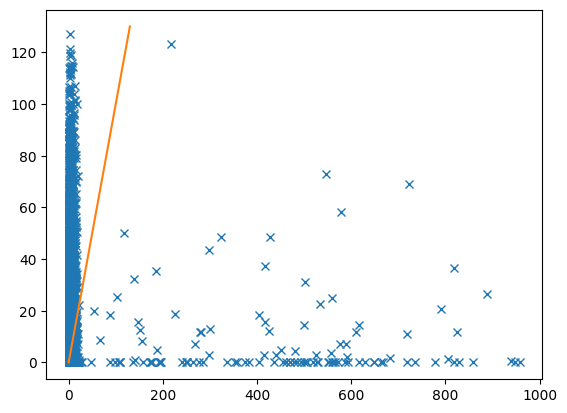

    15  -2.571  0.114E+00   159838   217.91  0.851   [Radiance 0.660 micron]
    16  -2.901  0.114E+00   159838   217.91  0.851   [Radiance 0.660 micron]
    17  -3.115  0.113E+00   159838   217.91  0.851   [Radiance 0.660 micron]
    18  -3.254  0.112E+00   159838   217.91  0.851   [Radiance 0.660 micron]
    19  -2.618  0.112E+00   159838   217.91  0.851   [Radiance 0.660 micron]
    20  -3.782  0.112E+00   159838   217.91  0.851   [Radiance 0.660 micron]
    21  -3.983  0.112E+00   159838   217.91  0.851   [Radiance 0.660 micron]
    22  -4.091  0.112E+00   159838   217.91  0.851   [Radiance 0.660 micron]
 ! Iterations:     22     Final Criterion:  0.000081   [Radiance 0.660 micron]


In [ ]:
plot(0, 0)